# Trainable activation layer implementations

In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import logging
import inspect
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2 as cv
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
from os import listdir
from os.path import isfile, join

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
models_path = "drive/MyDrive/master-thesis/models/experiments-reinforcement/"

In [ ]:
class FixedLayerActivation(keras.layers.Layer):
  def __init__(self, activation_functions, weights, *args, **kwargs):
    super(FixedLayerActivation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)
    self.fixed_weights = weights[0]

  def get_config(self):
    base_config = super().get_config()
    base_config['weights'] = [self.fixed_weights]
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.fixed_weights)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)
  
  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

In [ ]:
class LayerActivation(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super(LayerActivation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super().get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    self.w = self.add_weight(
        name="activation_weight",
        shape=(self.units, *([1] * len(input_shape))),
        initializer="zeros",
        trainable=True,
    )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)
  
  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

# Result plotting functions

In [ ]:
def is_activation_layer(layer):
  return 'activation' in layer.get_config()['name'] and layer.get_config().get('activation_functions', False)

In [ ]:
def softmax(x, axis=0):
  return np.exp(x) / np.sum(np.exp(x), axis=axis)

In [ ]:
import math

def plot_activation_function_bars(layer):
  config = layer.get_config()

  if "wo_softmax" in layer.get_config()['name']:
    weights = tf.convert_to_tensor(layer.get_weights())
  else:
    weights = softmax(np.array(layer.get_weights()), axis=1)

  plt.tight_layout()
  labels = list(map(lambda fn: keras.activations.serialize(fn)[:8], layer.activation_functions))
  index = tuple([0, slice(None)] + [0] * (len(weights.shape) - 2))
  if len(labels) > 4:
    plt.xticks(rotation=55, ha="right")
  plt.ylim(0, 1.0)
  plt.bar(labels, weights[index])

def plot_activation_functions_bars(models, width=10, height=4, mode='grid', n=2, m=2):
  if not models or len(models) == 0:
    print("No models to plot for")
    return

  width = width * len(models) # width - for each model / epoch
  height = height * len([layer for layer in models[0].layers if is_activation_layer(layer)]) # height - for each layer

  plt.figure(figsize=(width, height), dpi=300)
  count = 0
  for i, model in enumerate(models):
    activation_layers = [layer for layer in models[0].layers if is_activation_layer(layer)]
    for j, layer in enumerate(activation_layers):
      if mode == 'grid':
        plt.subplot(n, m, count + 1)
      else:
        plt.subplot(len(activation_layers), len(models), count + 1)
      plot_activation_function_bars(layer)
      plt.title(f'Activation layer {j + 1}')
      # plt.title(f'Model {i + 1} Layer {layer.get_config()["name"]}')
      count += 1

  plt.show()

In [ ]:
def plot_performance(history, val_acc_label='Test accuracy', test_accuracy=None):
  plt.figure(dpi=300)
  plt.grid(visible=True, axis='both', which='both')
  # test_acc_rounded = np.around(test_acc, decimals=1)
  # y_ticks = list(np.arange(0.1, test_acc_rounded, 0.1)) + [test_acc] + list(np.arange(test_acc_rounded, 1.0, 0.1))
  # label_doesnt_fit = abs(test_acc_rounded - test_acc) < 0.4
  # y_ticks_labels = list(map(lambda x: "{:.3f}".format(x) if type(x) != str else x, list(np.arange(0.1, test_acc_rounded, 0.1)) + [test_acc] + ([""] if label_doesnt_fit else [test_acc_rounded]) +
  #                           list(np.arange(test_acc_rounded + 0.1, 1.0, 0.1))))
  plt.yticks(np.arange(0.1, 1.1, 0.1))
  if history:
    # In case of val training
    if type(history) is list:
      epochs = range(1, len(history) + 1)
      plt.xticks(np.arange(1, len(history) + 1, 1))
      accuracy = [metric['accuracy'] for metric in history]
      plt.plot(epochs, accuracy, label='Train accuracy')

      if 'val_accuracy' in history[0]:
        val_accuracy = [metric['val_accuracy'] for metric in history]
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
    # Regular training
    else:
      plt.xticks(np.arange(1, len(history.history['accuracy']) + 1, 1))
      plt.plot(history.history['accuracy'], label='Train accuracy')
      plt.plot(history.history['val_accuracy'], label = val_acc_label)
    if test_accuracy:
      plt.axhline(y=test_accuracy, label='Test accuracy', color='r', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
  else:
    print("Could not plot performance: history not available")

In [ ]:
def plot_activation_function(layer, x_start, x_end, n=None):
  config = layer.get_config()
  x = np.arange(x_start * 10, x_end * 10) / 10
  initial_x_len = x.shape[0]
  x = x.reshape(tuple([x.shape[0]] + [1] * (len(layer.weights[0].shape) - 2)))
  y = np.array(layer(x))
  plt.tight_layout()
  plt.ylim(-10, 20)
  plt.plot(x.reshape(initial_x_len), y.reshape(initial_x_len))
  if n is None:
    plt.title(config['name'])
  else:
    plt.title(f'Activation layer {n + 1}')


def plot_activation_functions(models, x_start=-20, x_end=20, width=4, height=2, mode=None, n=2, m=2):
  if not models or len(models) == 0:
    print("No models to plot for")
    return

  activation_layers = [layer for layer in models[0].layers if is_activation_layer(layer)]
  n_activation_layers = len(activation_layers)
  plt.figure(figsize=(width * len(models), height * n_activation_layers), dpi=300)
  count = 0
  for model in models:
    activation_layers = [layer for layer in model.layers if is_activation_layer(layer)]
    for i, layer in enumerate(activation_layers):
      count += 1
      if mode == 'grid':
        plt.subplot(n, m, count)
      else:
        plt.subplot(n_activation_layers, len(models), count)
      plot_activation_function(layer, x_start, x_end, i)
  plt.show()

In [ ]:
def get_max_accuracy(history):
  if type(history) == list:
    max_test_acc = max(history, key=lambda x: x['val_accuracy'])['val_accuracy'].numpy()
    max_train_acc = max(history, key=lambda x: x['accuracy'])['accuracy'].numpy()
  else:
    max_test_acc = max(history.history['val_accuracy'])
    max_train_acc = max(history.history['accuracy'])

  return {'accuracy': max_train_acc, 'val_accuracy': max_test_acc}

In [ ]:
def load_model(filepath):
  custom_objects = {"LayerActivationWoSoftmax": LayerActivationWoSoftmax, "LayerActivation": LayerActivation, "NeuronActivation": NeuronActivation, "KernelActivation": KernelActivation}
  with keras.utils.custom_object_scope(custom_objects):
    return models.load_model(filepath)

In [ ]:
def load_history(filepath):
  import pickle
  return pickle.load(open(filepath, 'rb'))

In [ ]:
def plot_ppo_history(history, label=None):
  plt.plot(list(range(len(history))), [line['mean_return'] for line in history], label=label)
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.legend()
  plt.xlim(0, 50)
  plt.ylim(0, 210)

In [ ]:
def plot_dqn_history(history, label=None):
  indices = np.arange(0, 301, 6)
  history_mean = []
  prev_index = indices[0]
  for index in indices[1:]:
    history_mean.append(np.mean(history['episode_reward'][prev_index:index + 1]))
    prev_index = index + 1
  plt.plot(history_mean, label=label)
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.legend()
  plt.xlim(0, 50)
  plt.ylim(0, 210)

In [ ]:
from os import listdir
from os.path import isfile, join

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Tests

## Functions plotted

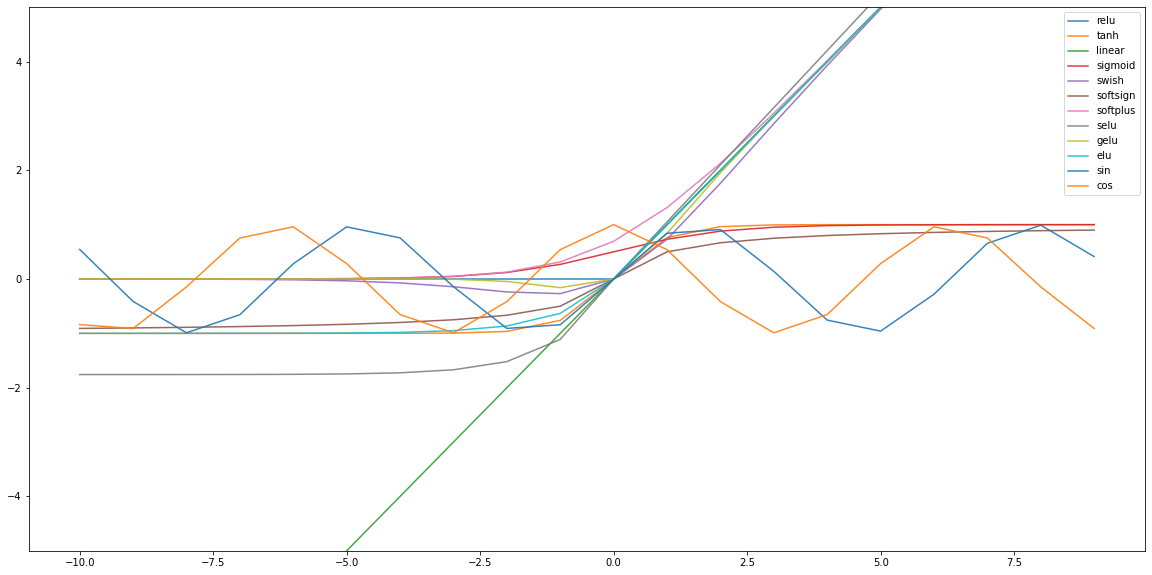

In [ ]:
plt.figure(figsize=(20, 10))
for fn in [
      keras.activations.relu,
      keras.activations.tanh,
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
]:
      x = np.arange(-10, 10, dtype=np.float64)
      y = fn(x)
      plt.ylim(-5, 5)
      plt.plot(x, y, alpha=0.9, label=str(fn).split()[1])
plt.legend()
plt.show()

In [ ]:
def agsig(a, alpha, beta):
  return alpha / (1 + np.exp(-beta*a))

def prelu(a, alpha):
  output = alpha * a
  output[a > 0] = a[a > 0]
  return output

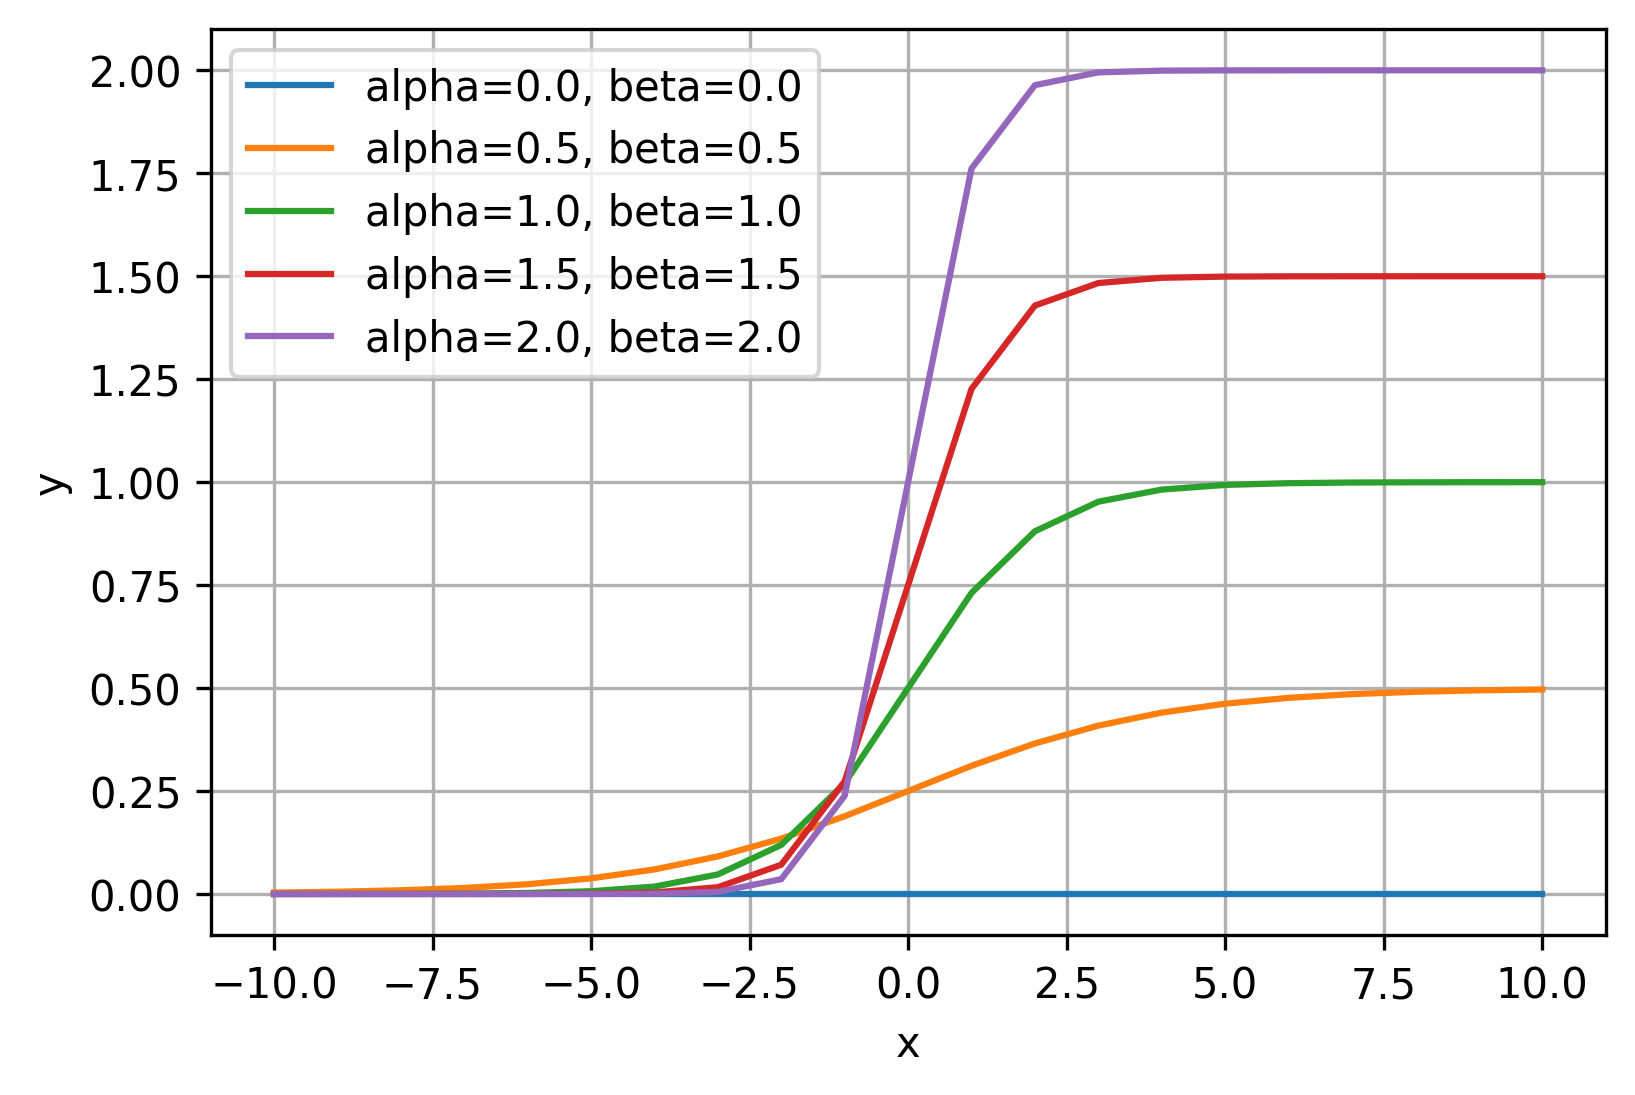

In [ ]:
x = np.arange(-10, 11)
a = [0.0, 0.5, 1.0, 1.5, 2.0]
plt.figure(dpi=300)
plt.xlabel('x')
plt.ylabel('y')
for alpha, beta in zip(a, a):
  y = agsig(x, alpha, beta)
  plt.plot(x, y, label=f"alpha={alpha}, beta={beta}")
  plt.grid()
  plt.legend()

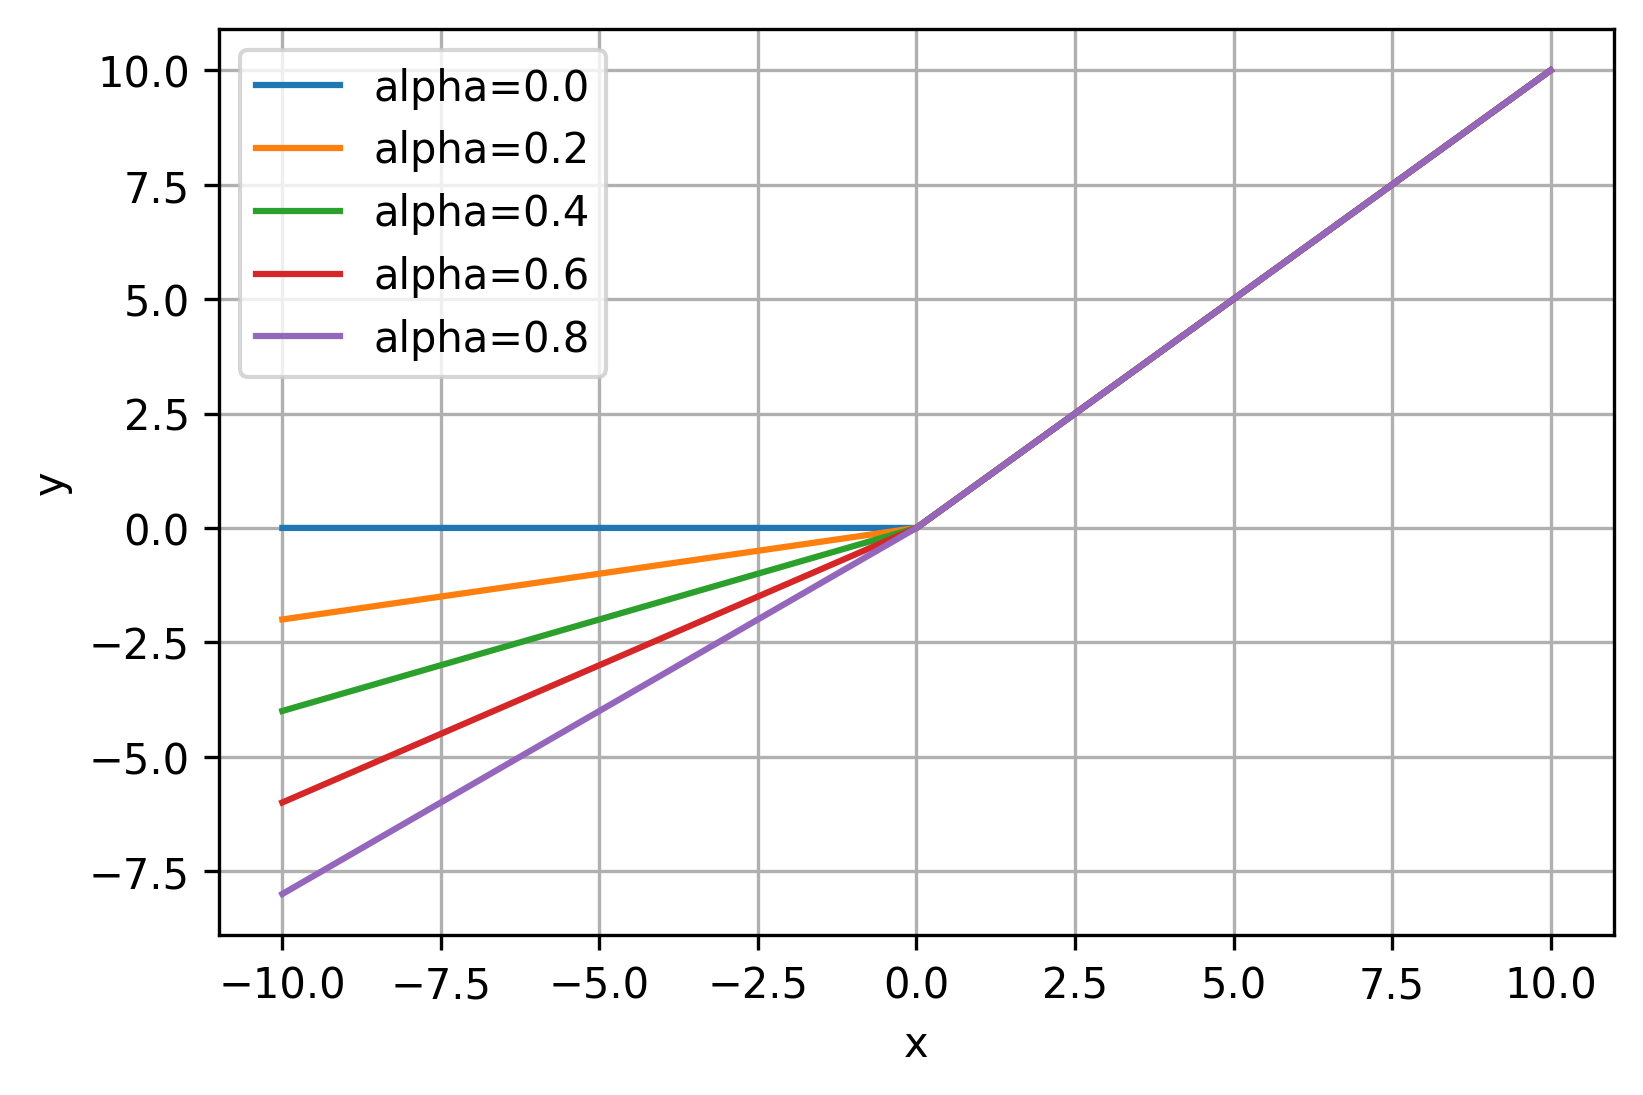

In [ ]:
x = np.arange(-10, 11)
a = [0.0, 0.2, 0.4, 0.6, 0.8]
plt.figure(dpi=300)
plt.xlabel('x')
plt.ylabel('y')
for alpha in a:
  y = prelu(x, alpha)
  plt.plot(x, y, label=f"alpha={alpha}")
  plt.grid()
  plt.legend()

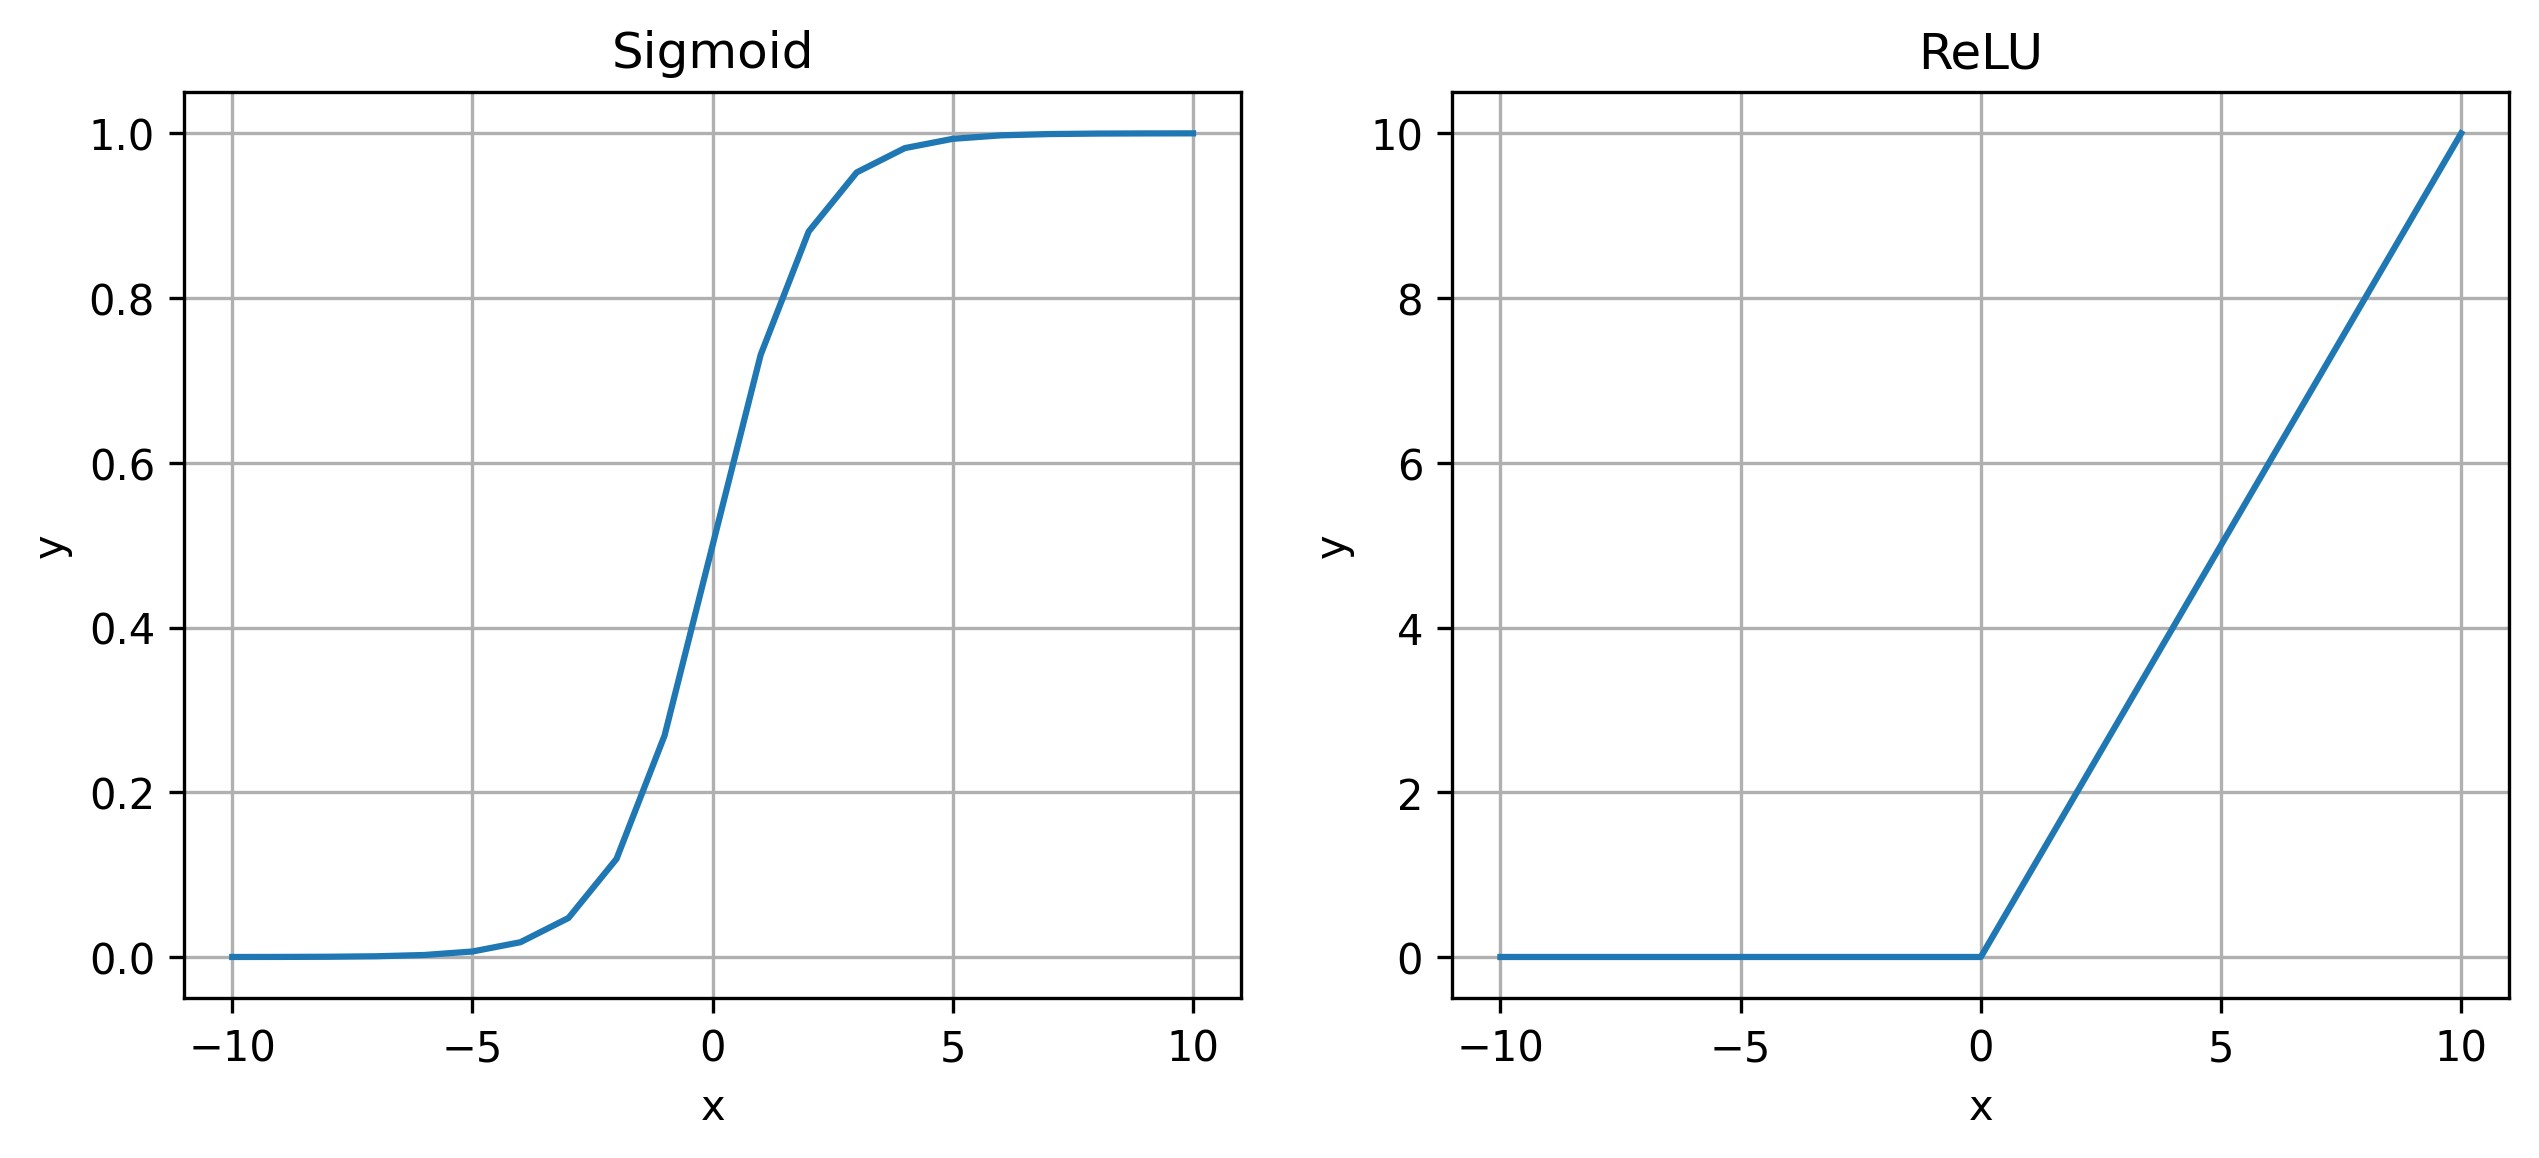

In [ ]:
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(1, 2, 1)
x = np.arange(-10, 11).astype('float32')
plt.plot(x, keras.activations.sigmoid(x))
plt.title('Sigmoid')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(x, keras.activations.relu(x))
plt.title('ReLU')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

## PPO

### Implementation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym
import scipy.signal
import time
import pickle

In [ ]:
def train(id, activation_layer, environment, activation_layers=None, hidden_sizes=(64, 64), epochs=30):
  """
  ## Functions and class
  """

  # https://keras.io/examples/rl/ppo_cartpole/

  def discounted_cumulative_sums(x, discount):
      # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
      return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


  class Buffer:
      # Buffer for storing trajectories
      def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
          # Buffer initialization
          self.observation_buffer = np.zeros(
              (size, observation_dimensions), dtype=np.float32
          )
          self.action_buffer = np.zeros(size, dtype=np.int32)
          self.advantage_buffer = np.zeros(size, dtype=np.float32)
          self.reward_buffer = np.zeros(size, dtype=np.float32)
          self.return_buffer = np.zeros(size, dtype=np.float32)
          self.value_buffer = np.zeros(size, dtype=np.float32)
          self.logprobability_buffer = np.zeros(size, dtype=np.float32)
          self.gamma, self.lam = gamma, lam
          self.pointer, self.trajectory_start_index = 0, 0

      def store(self, observation, action, reward, value, logprobability):
          # Append one step of agent-environment interaction
          self.observation_buffer[self.pointer] = observation
          self.action_buffer[self.pointer] = action
          self.reward_buffer[self.pointer] = reward
          self.value_buffer[self.pointer] = value
          self.logprobability_buffer[self.pointer] = logprobability
          self.pointer += 1

      def finish_trajectory(self, last_value=0):
          # Finish the trajectory by computing advantage estimates and rewards-to-go
          path_slice = slice(self.trajectory_start_index, self.pointer)
          rewards = np.append(self.reward_buffer[path_slice], last_value)
          values = np.append(self.value_buffer[path_slice], last_value)

          deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

          self.advantage_buffer[path_slice] = discounted_cumulative_sums(
              deltas, self.gamma * self.lam
          )
          self.return_buffer[path_slice] = discounted_cumulative_sums(
              rewards, self.gamma
          )[:-1]

          self.trajectory_start_index = self.pointer

      def get(self):
          # Get all data of the buffer and normalize the advantages
          self.pointer, self.trajectory_start_index = 0, 0
          advantage_mean, advantage_std = (
              np.mean(self.advantage_buffer),
              np.std(self.advantage_buffer),
          )
          self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
          return (
              self.observation_buffer,
              self.action_buffer,
              self.advantage_buffer,
              self.return_buffer,
              self.logprobability_buffer,
          )


  def mlp(x, sizes, activation_layer, activation_layers, output_activation=None):
      # Build a feedforward neural network
      if activation_layer is not None:
        for size in sizes[:-1]:
            x = layers.Dense(units=size)(x)
            x = activation_layer()(x)
      else:
        for size, act_layer in zip(sizes[:-1], activation_layers):
            x = layers.Dense(units=size)(x)
            x = act_layer(x)
      return layers.Dense(units=sizes[-1], activation=output_activation)(x)


  def logprobabilities(logits, a):
      # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
      logprobabilities_all = tf.nn.log_softmax(logits)
      logprobability = tf.reduce_sum(
          tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
      )
      return logprobability


  # Sample action from actor
  @tf.function
  def sample_action(observation):
      logits = actor(observation)
      action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
      return logits, action


  # Train the policy by maxizing the PPO-Clip objective
  @tf.function
  def train_policy(
      observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
  ):

      with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
          ratio = tf.exp(
              logprobabilities(actor(observation_buffer), action_buffer)
              - logprobability_buffer
          )
          min_advantage = tf.where(
              advantage_buffer > 0,
              (1 + clip_ratio) * advantage_buffer,
              (1 - clip_ratio) * advantage_buffer,
          )

          policy_loss = -tf.reduce_mean(
              tf.minimum(ratio * advantage_buffer, min_advantage)
          )
      policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
      policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

      kl = tf.reduce_mean(
          logprobability_buffer
          - logprobabilities(actor(observation_buffer), action_buffer)
      )
      kl = tf.reduce_sum(kl)
      return kl


  # Train the value function by regression on mean-squared error
  @tf.function
  def train_value_function(observation_buffer, return_buffer):
      with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
          value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
      value_grads = tape.gradient(value_loss, critic.trainable_variables)
      value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))


  """
  ## Hyperparameters
  """

  # Hyperparameters of the PPO algorithm
  steps_per_epoch = 1000
  gamma = 0.90
  clip_ratio = 0.2
  policy_learning_rate = 3e-3
  value_function_learning_rate = 1e-2
  train_policy_iterations = 80
  train_value_iterations = 80
  lam = 0.97
  target_kl = 0.01

  # True if you want to render the environment
  render = False

  """
  ## Initializations
  """

  # Initialize the environment and get the dimensionality of the
  # observation space and the number of possible actions
  env = gym.make(environment)
  observation_dimensions = env.observation_space.shape[0]
  num_actions = env.action_space.n

  # Initialize the buffer
  buffer = Buffer(observation_dimensions, steps_per_epoch)

  # Initialize the actor and the critic as keras models
  observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)
  logits = mlp(observation_input, list(hidden_sizes) + [num_actions], activation_layer, activation_layers, None)
  actor = keras.Model(inputs=observation_input, outputs=logits)
  value = tf.squeeze(
      mlp(observation_input, list(hidden_sizes) + [1], activation_layer, activation_layers, None), axis=1
  )
  critic = keras.Model(inputs=observation_input, outputs=value)

  # Initialize the policy and the value function optimizers
  policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
  value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

  # Initialize the observation, episode return and episode length
  observation, episode_return, episode_length = env.reset(), 0, 0

  """
  ## Train
  """

  history = []
  n = 0
  # Iterate over the number of epochs
  for epoch in range(epochs):
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0

    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        if render:
            env.render()

        # Get the logits, action, and take one step in the environment
        observation = observation.reshape(1, -1)
        logits, action = sample_action(observation)
        observation_new, reward, done, _ = env.step(action[0].numpy())
        episode_return += reward
        episode_length += 1

        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation, action, reward, value_t, logprobability_t)

        # Update the observation
        observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            observation, episode_return, episode_length = env.reset(), 0, 0

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer, return_buffer)

    mean_return = sum_return / num_episodes
    mean_length = sum_length / num_episodes
    history.append({"mean_return": mean_return, "mean_length": mean_length})
    # Print mean return and length for each epoch
    print(
        f" Epoch: {epoch + 1}. Mean Return: {mean_return}. Mean Length: {mean_length}"
    )
    
  actor.save(f"{models_path}/ppo-{id}-{environment}-actor.hdf5")
  critic.save(f"{models_path}/ppo-{id}-{environment}-critic.hdf5")
  pickle.dump(history, open(f"{models_path}/ppo-{id}-{environment}-history.pickle", "wb"))

  return history, actor, critic

### Baseline

In [ ]:
history, actor, critic = train('relu-1', activation_layer=lambda: keras.layers.Activation(tf.tanh), environment="CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 17.857142857142858. Mean Length: 17.857142857142858
 Epoch: 2. Mean Return: 23.80952380952381. Mean Length: 23.80952380952381
 Epoch: 3. Mean Return: 35.714285714285715. Mean Length: 35.714285714285715
 Epoch: 4. Mean Return: 50.0. Mean Length: 50.0
 Epoch: 5. Mean Return: 62.5. Mean Length: 62.5
 Epoch: 6. Mean Return: 83.33333333333333. Mean Length: 83.33333333333333
 Epoch: 7. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 8. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 9. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 17. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 18. Mean Ret

In [ ]:
history, actor, critic = train('relu-2', activation_layer=lambda: keras.layers.Activation(tf.tanh), environment="CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 24.390243902439025. Mean Length: 24.390243902439025
 Epoch: 2. Mean Return: 37.03703703703704. Mean Length: 37.03703703703704
 Epoch: 3. Mean Return: 47.61904761904762. Mean Length: 47.61904761904762
 Epoch: 4. Mean Return: 58.8235294117647. Mean Length: 58.8235294117647
 Epoch: 5. Mean Return: 71.42857142857143. Mean Length: 71.42857142857143
 Epoch: 6. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 7. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 8. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 9. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 17. Mean Retu

In [ ]:
history, actor, critic = train('relu-3', activation_layer=lambda: keras.layers.Activation(tf.tanh), environment="CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 17.54385964912281. Mean Length: 17.54385964912281
 Epoch: 2. Mean Return: 22.727272727272727. Mean Length: 22.727272727272727
 Epoch: 3. Mean Return: 29.41176470588235. Mean Length: 29.41176470588235
 Epoch: 4. Mean Return: 38.46153846153846. Mean Length: 38.46153846153846
 Epoch: 5. Mean Return: 66.66666666666667. Mean Length: 66.66666666666667
 Epoch: 6. Mean Return: 62.5. Mean Length: 62.5
 Epoch: 7. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 8. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 9. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 10. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 11. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 166.66666666666666. Mean Length: 166.666666666

In [ ]:
history, actor, critic = train('relu-4', activation_layer=lambda: keras.layers.Activation(tf.tanh), environment="CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 18.181818181818183. Mean Length: 18.181818181818183
 Epoch: 2. Mean Return: 22.727272727272727. Mean Length: 22.727272727272727
 Epoch: 3. Mean Return: 29.41176470588235. Mean Length: 29.41176470588235
 Epoch: 4. Mean Return: 62.5. Mean Length: 62.5
 Epoch: 5. Mean Return: 76.92307692307692. Mean Length: 76.92307692307692
 Epoch: 6. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 7. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 8. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 9. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 10. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 17. Mean 

In [ ]:
history, actor, critic = train('relu-5', activation_layer=lambda: keras.layers.Activation(tf.tanh), environment="CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 23.80952380952381. Mean Length: 23.80952380952381
 Epoch: 2. Mean Return: 30.303030303030305. Mean Length: 30.303030303030305
 Epoch: 3. Mean Return: 35.714285714285715. Mean Length: 35.714285714285715
 Epoch: 4. Mean Return: 58.8235294117647. Mean Length: 58.8235294117647
 Epoch: 5. Mean Return: 76.92307692307692. Mean Length: 76.92307692307692
 Epoch: 6. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 7. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 8. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 9. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 14. Mean Return: 166.66666666666666. Mean Length: 166.666666

### Layer

In [ ]:
history, actor, critic = train('basic-1', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
]), "CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 20.833333333333332. Mean Length: 20.833333333333332
 Epoch: 2. Mean Return: 27.77777777777778. Mean Length: 27.77777777777778
 Epoch: 3. Mean Return: 45.45454545454545. Mean Length: 45.45454545454545
 Epoch: 4. Mean Return: 34.48275862068966. Mean Length: 34.48275862068966
 Epoch: 5. Mean Return: 35.714285714285715. Mean Length: 35.714285714285715
 Epoch: 6. Mean Return: 83.33333333333333. Mean Length: 83.33333333333333
 Epoch: 7. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 8. Mean Return: 62.5. Mean Length: 62.5
 Epoch: 9. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 10. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 11. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 14. Mean Return: 166.66666666666666. Mean Length: 166.66666666

In [ ]:
history, actor, critic = train('basic-2', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
]), "CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 15.151515151515152. Mean Length: 15.151515151515152
 Epoch: 2. Mean Return: 19.607843137254903. Mean Length: 19.607843137254903
 Epoch: 3. Mean Return: 25.641025641025642. Mean Length: 25.641025641025642
 Epoch: 4. Mean Return: 29.41176470588235. Mean Length: 29.41176470588235
 Epoch: 5. Mean Return: 43.47826086956522. Mean Length: 43.47826086956522
 Epoch: 6. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 7. Mean Return: 55.55555555555556. Mean Length: 55.55555555555556
 Epoch: 8. Mean Return: 58.8235294117647. Mean Length: 58.8235294117647
 Epoch: 9. Mean Return: 71.42857142857143. Mean Length: 71.42857142857143
 Epoch: 10. Mean Return: 90.9090909090909. Mean Length: 90.9090909090909
 Epoch: 11. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 14. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 

In [ ]:
history, actor, critic = train('basic-3', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
]), "CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 21.27659574468085. Mean Length: 21.27659574468085
 Epoch: 2. Mean Return: 25.641025641025642. Mean Length: 25.641025641025642
 Epoch: 3. Mean Return: 29.41176470588235. Mean Length: 29.41176470588235
 Epoch: 4. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 5. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 6. Mean Return: 76.92307692307692. Mean Length: 76.92307692307692
 Epoch: 7. Mean Return: 76.92307692307692. Mean Length: 76.92307692307692
 Epoch: 8. Mean Return: 90.9090909090909. Mean Length: 90.9090909090909
 Epoch: 9. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 10. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 11. Mean Return: 76.92307692307692. Mean Length: 76.92307692307692
 Epoch: 12. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 13. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 20

In [ ]:
history, actor, critic = train('basic-4', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
]), "CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 21.73913043478261. Mean Length: 21.73913043478261
 Epoch: 2. Mean Return: 25.641025641025642. Mean Length: 25.641025641025642
 Epoch: 3. Mean Return: 24.390243902439025. Mean Length: 24.390243902439025
 Epoch: 4. Mean Return: 28.571428571428573. Mean Length: 28.571428571428573
 Epoch: 5. Mean Return: 38.46153846153846. Mean Length: 38.46153846153846
 Epoch: 6. Mean Return: 50.0. Mean Length: 50.0
 Epoch: 7. Mean Return: 33.333333333333336. Mean Length: 33.333333333333336
 Epoch: 8. Mean Return: 41.666666666666664. Mean Length: 41.666666666666664
 Epoch: 9. Mean Return: 66.66666666666667. Mean Length: 66.66666666666667
 Epoch: 10. Mean Return: 50.0. Mean Length: 50.0
 Epoch: 11. Mean Return: 83.33333333333333. Mean Length: 83.33333333333333
 Epoch: 12. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 13. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 14. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 15. Mean Retu

In [ ]:
history, actor, critic = train('basic-5', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
]), "CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 20.833333333333332. Mean Length: 20.833333333333332
 Epoch: 2. Mean Return: 30.303030303030305. Mean Length: 30.303030303030305
 Epoch: 3. Mean Return: 35.714285714285715. Mean Length: 35.714285714285715
 Epoch: 4. Mean Return: 50.0. Mean Length: 50.0
 Epoch: 5. Mean Return: 76.92307692307692. Mean Length: 76.92307692307692
 Epoch: 6. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 7. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 8. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 9. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 10. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 16. Me

In [ ]:
history, actor, critic = train('normal-1', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
]), "CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 21.73913043478261. Mean Length: 21.73913043478261
 Epoch: 2. Mean Return: 27.027027027027028. Mean Length: 27.027027027027028
 Epoch: 3. Mean Return: 29.41176470588235. Mean Length: 29.41176470588235
 Epoch: 4. Mean Return: 31.25. Mean Length: 31.25
 Epoch: 5. Mean Return: 50.0. Mean Length: 50.0
 Epoch: 6. Mean Return: 47.61904761904762. Mean Length: 47.61904761904762
 Epoch: 7. Mean Return: 71.42857142857143. Mean Length: 71.42857142857143
 Epoch: 8. Mean Return: 55.55555555555556. Mean Length: 55.55555555555556
 Epoch: 9. Mean Return: 76.92307692307692. Mean Length: 76.92307692307692
 Epoch: 10. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 11. Mean Return: 90.9090909090909. Mean Length: 90.9090909090909
 Epoch: 12. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 13. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 20

In [ ]:
history, actor, critic = train('normal-2', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
]), "CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 22.22222222222222. Mean Length: 22.22222222222222
 Epoch: 2. Mean Return: 28.571428571428573. Mean Length: 28.571428571428573
 Epoch: 3. Mean Return: 35.714285714285715. Mean Length: 35.714285714285715
 Epoch: 4. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 5. Mean Return: 71.42857142857143. Mean Length: 71.42857142857143
 Epoch: 6. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 7. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 8. Mean Return: 66.66666666666667. Mean Length: 66.66666666666667
 Epoch: 9. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 10. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 11. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 200.0. Mean Length: 

In [ ]:
history, actor, critic = train('normal-3', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
]), "CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 19.23076923076923. Mean Length: 19.23076923076923
 Epoch: 2. Mean Return: 22.727272727272727. Mean Length: 22.727272727272727
 Epoch: 3. Mean Return: 40.0. Mean Length: 40.0
 Epoch: 4. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 5. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 6. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 7. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 8. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 9. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 10. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 17. Mean Re

In [ ]:
history, actor, critic = train('normal-4', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
]), "CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 16.666666666666668. Mean Length: 16.666666666666668
 Epoch: 2. Mean Return: 25.0. Mean Length: 25.0
 Epoch: 3. Mean Return: 25.0. Mean Length: 25.0
 Epoch: 4. Mean Return: 35.714285714285715. Mean Length: 35.714285714285715
 Epoch: 5. Mean Return: 45.45454545454545. Mean Length: 45.45454545454545
 Epoch: 6. Mean Return: 47.61904761904762. Mean Length: 47.61904761904762
 Epoch: 7. Mean Return: 58.8235294117647. Mean Length: 58.8235294117647
 Epoch: 8. Mean Return: 76.92307692307692. Mean Length: 76.92307692307692
 Epoch: 9. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 10. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 11. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return:

In [ ]:
history, actor, critic = train('normal-5', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
]), "CartPole-v0", epochs=50)

 Epoch: 1. Mean Return: 26.31578947368421. Mean Length: 26.31578947368421
 Epoch: 2. Mean Return: 23.25581395348837. Mean Length: 23.25581395348837
 Epoch: 3. Mean Return: 28.571428571428573. Mean Length: 28.571428571428573
 Epoch: 4. Mean Return: 41.666666666666664. Mean Length: 41.666666666666664
 Epoch: 5. Mean Return: 35.714285714285715. Mean Length: 35.714285714285715
 Epoch: 6. Mean Return: 32.25806451612903. Mean Length: 32.25806451612903
 Epoch: 7. Mean Return: 55.55555555555556. Mean Length: 55.55555555555556
 Epoch: 8. Mean Return: 58.8235294117647. Mean Length: 58.8235294117647
 Epoch: 9. Mean Return: 50.0. Mean Length: 50.0
 Epoch: 10. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 11. Mean Return: 66.66666666666667. Mean Length: 66.66666666666667
 Epoch: 12. Mean Return: 76.92307692307692. Mean Length: 76.92307692307692
 Epoch: 13. Mean Return: 71.42857142857143. Mean Length: 71.42857142857143
 Epoch: 14. Mean Return: 83.33333333333333. Mean Length:

In [ ]:
model_path = f"{models_path}/ppo-basic-3-CartPole-v0-actor.hdf5"
model = load_model(model_path)
activation_layers = []
for layer in model.layers:
  if is_activation_layer(layer):
    layer.trainable = False
    layer.trainable = False
    activation_layers.append(layer)

In [ ]:
history, actor, critic = train('basic-3-fixed-1', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 25.0. Mean Length: 25.0
 Epoch: 2. Mean Return: 38.46153846153846. Mean Length: 38.46153846153846
 Epoch: 3. Mean Return: 55.55555555555556. Mean Length: 55.55555555555556
 Epoch: 4. Mean Return: 83.33333333333333. Mean Length: 83.33333333333333
 Epoch: 5. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 6. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 7. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 8. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 9. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 166.66666666666666.

In [ ]:
history, actor, critic = train('basic-3-fixed-2', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 23.80952380952381. Mean Length: 23.80952380952381
 Epoch: 2. Mean Return: 43.47826086956522. Mean Length: 43.47826086956522
 Epoch: 3. Mean Return: 55.55555555555556. Mean Length: 55.55555555555556
 Epoch: 4. Mean Return: 83.33333333333333. Mean Length: 83.33333333333333
 Epoch: 5. Mean Return: 90.9090909090909. Mean Length: 90.9090909090909
 Epoch: 6. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 7. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 8. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 9. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 10. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 11. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 14. Mean Ret

In [ ]:
history, actor, critic = train('basic-3-fixed-3', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 24.390243902439025. Mean Length: 24.390243902439025
 Epoch: 2. Mean Return: 25.641025641025642. Mean Length: 25.641025641025642
 Epoch: 3. Mean Return: 38.46153846153846. Mean Length: 38.46153846153846
 Epoch: 4. Mean Return: 45.45454545454545. Mean Length: 45.45454545454545
 Epoch: 5. Mean Return: 58.8235294117647. Mean Length: 58.8235294117647
 Epoch: 6. Mean Return: 58.8235294117647. Mean Length: 58.8235294117647
 Epoch: 7. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 8. Mean Return: 66.66666666666667. Mean Length: 66.66666666666667
 Epoch: 9. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 10. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.

In [ ]:
history, actor, critic = train('basic-3-fixed-4', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 25.641025641025642. Mean Length: 25.641025641025642
 Epoch: 2. Mean Return: 47.61904761904762. Mean Length: 47.61904761904762
 Epoch: 3. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 4. Mean Return: 76.92307692307692. Mean Length: 76.92307692307692
 Epoch: 5. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 6. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 7. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 8. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 9. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 200.0. Mean Len

In [ ]:
history, actor, critic = train('basic-3-fixed-5', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 20.0. Mean Length: 20.0
 Epoch: 2. Mean Return: 29.41176470588235. Mean Length: 29.41176470588235
 Epoch: 3. Mean Return: 45.45454545454545. Mean Length: 45.45454545454545
 Epoch: 4. Mean Return: 66.66666666666667. Mean Length: 66.66666666666667
 Epoch: 5. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 6. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 7. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 8. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 9. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 14. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 15. Mean Return: 200.0. Mean Length

In [ ]:
model_path = f"{models_path}/ppo-normal-1-CartPole-v0-actor.hdf5"
model = load_model(model_path)
activation_layers = []
for layer in model.layers:
  if is_activation_layer(layer):
    layer.trainable = False
    i_max = np.argmax(layer.get_weights())
    act_fn = layer.get_config()['activation_functions'][i_max]
    activation_layers.append(keras.layers.Activation(act_fn))

In [ ]:
history, actor, critic = train('normal-1-fixed-1', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 20.0. Mean Length: 20.0
 Epoch: 2. Mean Return: 25.0. Mean Length: 25.0
 Epoch: 3. Mean Return: 34.48275862068966. Mean Length: 34.48275862068966
 Epoch: 4. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 5. Mean Return: 66.66666666666667. Mean Length: 66.66666666666667
 Epoch: 6. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 7. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 8. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 9. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 17. Mean Retu

In [ ]:
history, actor, critic = train('normal-1-fixed-2', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 21.73913043478261. Mean Length: 21.73913043478261
 Epoch: 2. Mean Return: 31.25. Mean Length: 31.25
 Epoch: 3. Mean Return: 41.666666666666664. Mean Length: 41.666666666666664
 Epoch: 4. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 5. Mean Return: 83.33333333333333. Mean Length: 83.33333333333333
 Epoch: 6. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 7. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 8. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 9. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 10. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 14. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 15. Mea

In [ ]:
history, actor, critic = train('normal-1-fixed-3', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 21.73913043478261. Mean Length: 21.73913043478261
 Epoch: 2. Mean Return: 29.41176470588235. Mean Length: 29.41176470588235
 Epoch: 3. Mean Return: 40.0. Mean Length: 40.0
 Epoch: 4. Mean Return: 58.8235294117647. Mean Length: 58.8235294117647
 Epoch: 5. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 6. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 7. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 8. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 9. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 15. Mean Return: 200.0. Mean Length: 

In [ ]:
history, actor, critic = train('normal-1-fixed-4', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 22.727272727272727. Mean Length: 22.727272727272727
 Epoch: 2. Mean Return: 32.25806451612903. Mean Length: 32.25806451612903
 Epoch: 3. Mean Return: 50.0. Mean Length: 50.0
 Epoch: 4. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 5. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 6. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 7. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 8. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 9. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 14. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 15. M

In [ ]:
history, actor, critic = train('normal-1-fixed-5', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 24.390243902439025. Mean Length: 24.390243902439025
 Epoch: 2. Mean Return: 35.714285714285715. Mean Length: 35.714285714285715
 Epoch: 3. Mean Return: 62.5. Mean Length: 62.5
 Epoch: 4. Mean Return: 90.9090909090909. Mean Length: 90.9090909090909
 Epoch: 5. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 6. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 7. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 8. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 9. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 200.0. Mean Lengt

In [ ]:
model_path = f"{models_path}/ppo-normal-1-CartPole-v0-actor.hdf5"
model = load_model(model_path)
activation_layers = []
for layer in model.layers:
  if is_activation_layer(layer):
    layer.trainable = False
    activation_layers.append(layer)

In [ ]:
history, actor, critic = train('normal-1-fixed-all-1', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 25.641025641025642. Mean Length: 25.641025641025642
 Epoch: 2. Mean Return: 45.45454545454545. Mean Length: 45.45454545454545
 Epoch: 3. Mean Return: 58.8235294117647. Mean Length: 58.8235294117647
 Epoch: 4. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 5. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 6. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 7. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 8. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 9. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 10. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 200.0. Mean Lengt

In [ ]:
history, actor, critic = train('normal-1-fixed-all-2', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 27.027027027027028. Mean Length: 27.027027027027028
 Epoch: 2. Mean Return: 45.45454545454545. Mean Length: 45.45454545454545
 Epoch: 3. Mean Return: 55.55555555555556. Mean Length: 55.55555555555556
 Epoch: 4. Mean Return: 76.92307692307692. Mean Length: 76.92307692307692
 Epoch: 5. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 6. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 7. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 8. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 9. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 14. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 166.6666666666666

In [ ]:
history, actor, critic = train('normal-1-fixed-all-3', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 20.833333333333332. Mean Length: 20.833333333333332
 Epoch: 2. Mean Return: 33.333333333333336. Mean Length: 33.333333333333336
 Epoch: 3. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 4. Mean Return: 50.0. Mean Length: 50.0
 Epoch: 5. Mean Return: 111.11111111111111. Mean Length: 111.11111111111111
 Epoch: 6. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 7. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 8. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 9. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 10. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 11. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 200.0. Mean Len

In [ ]:
history, actor, critic = train('normal-1-fixed-all-4', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 20.0. Mean Length: 20.0
 Epoch: 2. Mean Return: 33.333333333333336. Mean Length: 33.333333333333336
 Epoch: 3. Mean Return: 35.714285714285715. Mean Length: 35.714285714285715
 Epoch: 4. Mean Return: 62.5. Mean Length: 62.5
 Epoch: 5. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 6. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 7. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 8. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 9. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 12. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 17. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 18. Mean Return: 200.0. Mean Lengt

In [ ]:
history, actor, critic = train('normal-1-fixed-all-5', None, "CartPole-v0", activation_layers=activation_layers, epochs=50)

 Epoch: 1. Mean Return: 20.408163265306122. Mean Length: 20.408163265306122
 Epoch: 2. Mean Return: 26.31578947368421. Mean Length: 26.31578947368421
 Epoch: 3. Mean Return: 45.45454545454545. Mean Length: 45.45454545454545
 Epoch: 4. Mean Return: 52.63157894736842. Mean Length: 52.63157894736842
 Epoch: 5. Mean Return: 100.0. Mean Length: 100.0
 Epoch: 6. Mean Return: 142.85714285714286. Mean Length: 142.85714285714286
 Epoch: 7. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 8. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 9. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 10. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 11. Mean Return: 125.0. Mean Length: 125.0
 Epoch: 12. Mean Return: 166.66666666666666. Mean Length: 166.66666666666666
 Epoch: 13. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 14. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 15. Mean Return: 200.0. Mean Length: 200.0
 Epoch: 16. Mean Return: 200.0. Mean Lengt

## DQN

### Implementation

In [ ]:
!pip install keras-rl2

     |████████████████████████████████| 52 kB 767 kB/s 
     |████████████████████████████████| 462 kB 9.8 MB/s 


In [ ]:
def do_dqn(id, environment_name, activation_function, activation_function_weights=None, layers=[64, 64], steps=10000):
  # Get the environment and extract the number of actions.
  import gym
  import pickle
  from rl.agents.dqn import DQNAgent
  from rl.policy import BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
  from rl.memory import SequentialMemory
  from rl.callbacks import Callback

  class EarlyStopCallback(Callback):
    def __init__(self):
      super().__init__()
      self.n = 0

    def on_episode_end(self, episode, logs={}):
      reward = logs.get('episode_reward', None)
      if reward is not None:
        if reward == 200:
          self.n += 1
        else:
          self.n = 0
      if self.n >= 5:
        raise KeyboardInterrupt()

  env = gym.make(environment_name)
  nb_actions = env.action_space.n

  # Next, we build a very simple model.
  model = Sequential()
  model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
  for n in layers:
    model.add(Dense(n))
    if activation_function_weights is not None:
      model.add(activation_function(activation_function_weights.pop(0)))
    else:
      model.add(activation_function())
  model.add(Dense(env.action_space.n))
  model.add(Activation('linear'))
  print(model.summary())
  dqn = DQNAgent(
    model=model,
    nb_actions=env.action_space.n,
    memory=SequentialMemory(limit=50000, window_length=1),
    nb_steps_warmup=1000,
    target_model_update=1e-2,
    policy=BoltzmannQPolicy(),
    custom_model_objects={"LayerActivationWoSoftmax": LayerActivationWoSoftmax, "LayerActivation": LayerActivation, "FixedLayerActivation": FixedLayerActivation, "NeuronActivation": NeuronActivation, "KernelActivation": KernelActivation})
  
  dqn.compile(Adam(lr=1e-3), metrics=['mae'])
  history = dqn.fit(env, nb_steps=steps, visualize=False, verbose=2)

  # After training is done, we save the final weights.
  # dqn.save_weights(f'{models_path}/dqn_{environment_name}_weights.h5f', overwrite=True)
  pickle.dump(history.history, open(f'{models_path}/dqn_{environment_name}_{id}_history.pickle', 'wb'))
  model.save(f'{models_path}/dqn_{environment_name}_{id}.h5f')

  # Finally, evaluate our algorithm for 5 episodes.
  dqn.test(env, nb_episodes=10, visualize=False)

  return dqn, model, history

### Baseline

In [ ]:
dqn, model, history = do_dqn('tanh-1', 'CartPole-v0', lambda: keras.layers.Activation('tanh'), layers=[64, 64], steps=50000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    77/50000: episode: 1, duration: 1.515s, episode steps:  77, steps per second:  51, episode reward: 77.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    88/50000: episode: 2, duration: 0.017s, episode steps:  11, steps per second: 649, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   103/50000: episode: 3, duration: 0.022s, episode steps:  15, steps per second: 694, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   119/50000: episode: 4, duration: 0.023s, episode steps:  16, steps per second: 708, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   136/50000: episode: 5, duration: 0.024s, episode steps:  17, steps per second: 705, episode reward: 17.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1035/50000: episode: 45, duration: 1.520s, episode steps:  43, steps per second:  28, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.535 [0.000, 1.000],  loss: 0.332482, mae: 0.529030, mean_q: 0.324966
  1052/50000: episode: 46, duration: 0.189s, episode steps:  17, steps per second:  90, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: 0.051038, mae: 0.581668, mean_q: 0.946752
  1074/50000: episode: 47, duration: 0.244s, episode steps:  22, steps per second:  90, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.003429, mae: 0.651154, mean_q: 1.280465
  1100/50000: episode: 48, duration: 0.290s, episode steps:  26, steps per second:  90, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.423 [0.000, 1.000],  loss: 0.002997, mae: 0.707579, mean_q: 1.377909
  1116/50000: episode: 49, duration: 0.187s, episode steps:  16,

In [ ]:
dqn, model, history = do_dqn('tanh-2', 'CartPole-v0', lambda: keras.layers.Activation('tanh'), layers=[64, 64], steps=50000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...
    17/50000: episode: 1, duration: 0.103s, episode steps:  17, steps per second: 165, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.412 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    50/50000: episode: 2, duration: 0.049s, episode steps:  33, steps per second: 679, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.576 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    66/50000: episode: 3, duration: 0.023s, episode steps:  16, steps per second: 695, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   120/50000: episode: 4, duration: 0.082s, episode steps:  54, steps per second: 658, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.537 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   171/50000: episode: 5, duration: 0.071s, episode steps:  51, steps per second: 718, episode reward: 51.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.451 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   191/50000: episode: 6, duration: 0.028s, episode steps:  20, steps per second: 705, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   214/50000: episode: 7, duration: 0.033s, episode steps:  23, steps per second: 704, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.609 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   241/50000: episode: 8, duration: 0.047s, episode steps:  27, steps per second: 577, episode reward: 27.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1028/50000: episode: 39, duration: 0.856s, episode steps:  28, steps per second:  33, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.464 [0.000, 1.000],  loss: 0.362599, mae: 0.536577, mean_q: 0.249016
  1044/50000: episode: 40, duration: 0.201s, episode steps:  16, steps per second:  80, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 0.079480, mae: 0.553701, mean_q: 0.793401
  1135/50000: episode: 41, duration: 1.017s, episode steps:  91, steps per second:  89, episode reward: 91.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 0.006483, mae: 0.741438, mean_q: 1.436743
  1147/50000: episode: 42, duration: 0.139s, episode steps:  12, steps per second:  86, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 0.009309, mae: 0.916287, mean_q: 1.807334
  1178/50000: episode: 43, duration: 0.367s, episode steps:  31,

In [ ]:
dqn, model, history = do_dqn('tanh-3', 'CartPole-v0', lambda: keras.layers.Activation('tanh'), layers=[64, 64], steps=50000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...
    55/50000: episode: 1, duration: 0.185s, episode steps:  55, steps per second: 297, episode reward: 55.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.491 [0.000, 1.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    76/50000: episode: 2, duration: 0.038s, episode steps:  21, steps per second: 549, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    88/50000: episode: 3, duration: 0.018s, episode steps:  12, steps per second: 658, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   114/50000: episode: 4, duration: 0.038s, episode steps:  26, steps per second: 693, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   128/50000: episode: 5, duration: 0.021s, episode steps:  14, steps per second: 673, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.786 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   146/50000: episode: 6, duration: 0.026s, episode steps:  18, steps per second: 695, episode reward: 18.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1004/50000: episode: 48, duration: 0.760s, episode steps:  18, steps per second:  24, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 0.520435, mae: 0.563845, mean_q: 0.053842
  1028/50000: episode: 49, duration: 0.294s, episode steps:  24, steps per second:  82, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: 0.325904, mae: 0.548260, mean_q: 0.332406
  1060/50000: episode: 50, duration: 0.394s, episode steps:  32, steps per second:  81, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.531 [0.000, 1.000],  loss: 0.039126, mae: 0.621318, mean_q: 1.087896
  1077/50000: episode: 51, duration: 0.196s, episode steps:  17, steps per second:  87, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.294 [0.000, 1.000],  loss: 0.007597, mae: 0.680506, mean_q: 1.380772
  1092/50000: episode: 52, duration: 0.179s, episode steps:  15,

In [ ]:
dqn, model, history = do_dqn('tanh-4', 'CartPole-v0', lambda: keras.layers.Activation('tanh'), layers=[64, 64], steps=50000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense_72 (Dense)            (None, 64)                320       
                                                                 
 activation_10 (Activation)  (None, 64)                0         
                                                                 
 dense_73 (Dense)            (None, 64)                4160      
                                                                 
 activation_11 (Activation)  (None, 64)                0         
                                                                 
 dense_74 (Dense)            (None, 2)                 130       
                                                                 
 activation_12 (Activation)  (None, 2)                 0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...
    19/50000: episode: 1, duration: 0.066s, episode steps:  19, steps per second: 289, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    31/50000: episode: 2, duration: 0.013s, episode steps:  12, steps per second: 928, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    61/50000: episode: 3, duration: 0.042s, episode steps:  30, steps per second: 707, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.567 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    77/50000: episode: 4, duration: 0.019s, episode steps:  16, steps per second: 841, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    92/50000: episode: 5, duration: 0.016s, episode steps:  15, steps per second: 915, episode reward: 15.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   128/50000: episode: 7, duration: 0.033s, episode steps:  22, steps per second: 669, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.591 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   146/50000: episode: 8, duration: 0.042s, episode steps:  18, steps per second: 425, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   167/50000: episode: 9, duration: 0.035s, episode steps:  21, steps per second: 592, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.619 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   182/50000: episode: 10, duration: 0.025s, episode steps:  15, steps per second: 595, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   220/50000: episode: 11, duration: 0.069s, episode steps:  38, steps per second: 552, episode reward: 38.000, mean reward:  1.000 [ 1.000

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1013/50000: episode: 43, duration: 0.857s, episode steps:  16, steps per second:  19, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 0.464395, mae: 0.552683, mean_q: 0.148494
  1037/50000: episode: 44, duration: 0.220s, episode steps:  24, steps per second: 109, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 0.225029, mae: 0.534502, mean_q: 0.435736
  1059/50000: episode: 45, duration: 0.182s, episode steps:  22, steps per second: 121, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.409 [0.000, 1.000],  loss: 0.015081, mae: 0.599171, mean_q: 1.095778
  1077/50000: episode: 46, duration: 0.152s, episode steps:  18, steps per second: 118, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.003452, mae: 0.677644, mean_q: 1.337466
  1094/50000: episode: 47, duration: 0.142s, episode steps:  17,

In [ ]:
dqn, model, history = do_dqn('tanh-5', 'CartPole-v0', lambda: keras.layers.Activation('tanh'), layers=[64, 64], steps=50000)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_75 (Dense)            (None, 64)                320       
                                                                 
 activation_13 (Activation)  (None, 64)                0         
                                                                 
 dense_76 (Dense)            (None, 64)                4160      
                                                                 
 activation_14 (Activation)  (None, 64)                0         
                                                                 
 dense_77 (Dense)            (None, 2)                 130       
                                                                 
 activation_15 (Activation)  (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...
    13/50000: episode: 1, duration: 0.087s, episode steps:  13, steps per second: 149, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    26/50000: episode: 2, duration: 0.015s, episode steps:  13, steps per second: 873, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    41/50000: episode: 3, duration: 0.017s, episode steps:  15, steps per second: 873, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.467 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    73/50000: episode: 4, duration: 0.037s, episode steps:  32, steps per second: 871, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.562 [0.000, 1.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   114/50000: episode: 5, duration: 0.049s, episode steps:  41, steps per second: 830, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.463 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   141/50000: episode: 6, duration: 0.029s, episode steps:  27, steps per second: 939, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   155/50000: episode: 7, duration: 0.044s, episode steps:  14, steps per second: 318, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   181/50000: episode: 8, duration: 0.063s, episode steps:  26, steps per second: 415, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   196/50000: episode: 9, duration: 0.033s, episode steps:  15, steps per second: 458, episode reward: 15.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1005/50000: episode: 48, duration: 0.819s, episode steps:  28, steps per second:  34, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 0.518099, mae: 0.555838, mean_q: 0.115081
  1021/50000: episode: 49, duration: 0.147s, episode steps:  16, steps per second: 109, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 0.376900, mae: 0.538764, mean_q: 0.247878
  1041/50000: episode: 50, duration: 0.193s, episode steps:  20, steps per second: 103, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 0.125183, mae: 0.550026, mean_q: 0.692744
  1057/50000: episode: 51, duration: 0.141s, episode steps:  16, steps per second: 113, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 0.009521, mae: 0.637153, mean_q: 1.220395
  1091/50000: episode: 52, duration: 0.285s, episode steps:  34,

### Layer

In [ ]:
dqn, model, history = do_dqn('basic-1', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid
]), layers=[64, 64], steps=50000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    22/50000: episode: 1, duration: 0.212s, episode steps:  22, steps per second: 104, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.409 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    36/50000: episode: 2, duration: 0.027s, episode steps:  14, steps per second: 522, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    50/50000: episode: 3, duration: 0.027s, episode steps:  14, steps per second: 525, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    64/50000: episode: 4, duration: 0.034s, episode steps:  14, steps per second: 409, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.714 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    89/50000: episode: 5, duration: 0.044s, episode steps:  25, steps per second: 574, episode reward: 25.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1011/50000: episode: 46, duration: 1.248s, episode steps:  15, steps per second:  12, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 0.384459, mae: 0.517576, mean_q: 0.196196
  1035/50000: episode: 47, duration: 0.349s, episode steps:  24, steps per second:  69, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: 0.035059, mae: 0.544036, mean_q: 0.954253
  1055/50000: episode: 48, duration: 0.279s, episode steps:  20, steps per second:  72, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 0.004570, mae: 0.650555, mean_q: 1.272699
  1086/50000: episode: 49, duration: 0.434s, episode steps:  31, steps per second:  71, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.452 [0.000, 1.000],  loss: 0.008980, mae: 0.759627, mean_q: 1.458232
  1109/50000: episode: 50, duration: 0.357s, episode steps:  23,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('basic-2', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid
]), layers=[64, 64], steps=50000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    18/50000: episode: 1, duration: 0.253s, episode steps:  18, steps per second:  71, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    29/50000: episode: 2, duration: 0.020s, episode steps:  11, steps per second: 545, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    45/50000: episode: 3, duration: 0.036s, episode steps:  16, steps per second: 449, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    56/50000: episode: 4, duration: 0.020s, episode steps:  11, steps per second: 552, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.818 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    82/50000: episode: 5, duration: 0.045s, episode steps:  26, steps per second: 575, episode reward: 26.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1009/50000: episode: 48, duration: 1.281s, episode steps:  14, steps per second:  11, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 0.417056, mae: 0.505777, mean_q: 0.063209
  1023/50000: episode: 49, duration: 0.191s, episode steps:  14, steps per second:  73, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 0.086461, mae: 0.482526, mean_q: 0.597300
  1033/50000: episode: 50, duration: 0.145s, episode steps:  10, steps per second:  69, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.800 [0.000, 1.000],  loss: 0.003896, mae: 0.550982, mean_q: 1.045001
  1061/50000: episode: 51, duration: 0.384s, episode steps:  28, steps per second:  73, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.393 [0.000, 1.000],  loss: 0.006270, mae: 0.650504, mean_q: 1.235785
  1075/50000: episode: 52, duration: 0.189s, episode steps:  14,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-2.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-2.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('basic-3', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid
]), layers=[64, 64], steps=50000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    29/50000: episode: 1, duration: 0.312s, episode steps:  29, steps per second:  93, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    42/50000: episode: 2, duration: 0.024s, episode steps:  13, steps per second: 544, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    51/50000: episode: 3, duration: 0.018s, episode steps:   9, steps per second: 498, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.889 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    69/50000: episode: 4, duration: 0.033s, episode steps:  18, steps per second: 547, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   117/50000: episode: 5, duration: 0.085s, episode steps:  48, steps per second: 568, episode reward: 48.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1032/50000: episode: 36, duration: 1.736s, episode steps:  52, steps per second:  30, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 0.173378, mae: 0.720682, mean_q: 1.167746
  1044/50000: episode: 37, duration: 0.167s, episode steps:  12, steps per second:  72, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 0.012704, mae: 0.860561, mean_q: 1.669086
  1059/50000: episode: 38, duration: 0.211s, episode steps:  15, steps per second:  71, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 0.014030, mae: 0.909045, mean_q: 1.762480
  1085/50000: episode: 39, duration: 0.366s, episode steps:  26, steps per second:  71, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 0.017620, mae: 0.998566, mean_q: 1.950440
  1113/50000: episode: 40, duration: 0.397s, episode steps:  28,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-3.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-3.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('basic-4', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid
]), layers=[64, 64], steps=50000)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 4)                 0         
                                                                 
 dense_78 (Dense)            (None, 64)                320       
                                                                 
 layer_activation_22 (LayerA  (None, 64)               4         
 ctivation)                                                      
                                                                 
 dense_79 (Dense)            (None, 64)                4160      
                                                                 
 layer_activation_23 (LayerA  (None, 64)               4         
 ctivation)                                                      
                                                                 
 dense_80 (Dense)            (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...
    21/50000: episode: 1, duration: 0.149s, episode steps:  21, steps per second: 141, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    34/50000: episode: 2, duration: 0.018s, episode steps:  13, steps per second: 713, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.231 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    48/50000: episode: 3, duration: 0.021s, episode steps:  14, steps per second: 654, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    61/50000: episode: 4, duration: 0.024s, episode steps:  13, steps per second: 536, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   107/50000: episode: 5, duration: 0.060s, episode steps:  46, steps per second: 767, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   150/50000: episode: 6, duration: 0.056s, episode steps:  43, steps per second: 766, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.535 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   162/50000: episode: 7, duration: 0.017s, episode steps:  12, steps per second: 716, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   175/50000: episode: 8, duration: 0.021s, episode steps:  13, steps per second: 621, episode reward: 13.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1034/50000: episode: 42, duration: 1.049s, episode steps:  53, steps per second:  51, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.472 [0.000, 1.000],  loss: 0.131035, mae: 0.565572, mean_q: 0.762363
  1048/50000: episode: 43, duration: 0.145s, episode steps:  14, steps per second:  96, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.714 [0.000, 1.000],  loss: 0.005092, mae: 0.697065, mean_q: 1.353104
  1064/50000: episode: 44, duration: 0.171s, episode steps:  16, steps per second:  93, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.688 [0.000, 1.000],  loss: 0.008694, mae: 0.741676, mean_q: 1.397564
  1075/50000: episode: 45, duration: 0.122s, episode steps:  11, steps per second:  90, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: 0.008222, mae: 0.810981, mean_q: 1.562837
  1132/50000: episode: 46, duration: 0.582s, episode steps:  57,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-4.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-4.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('basic-5', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid
]), layers=[64, 64], steps=50000)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 4)                 0         
                                                                 
 dense_81 (Dense)            (None, 64)                320       
                                                                 
 layer_activation_26 (LayerA  (None, 64)               4         
 ctivation)                                                      
                                                                 
 dense_82 (Dense)            (None, 64)                4160      
                                                                 
 layer_activation_27 (LayerA  (None, 64)               4         
 ctivation)                                                      
                                                                 
 dense_83 (Dense)            (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...
    20/50000: episode: 1, duration: 0.176s, episode steps:  20, steps per second: 114, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    36/50000: episode: 2, duration: 0.022s, episode steps:  16, steps per second: 730, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    49/50000: episode: 3, duration: 0.026s, episode steps:  13, steps per second: 494, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.231 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    75/50000: episode: 4, duration: 0.035s, episode steps:  26, steps per second: 753, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.423 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    88/50000: episode: 5, duration: 0.018s, episode steps:  13, steps per second: 722, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   104/50000: episode: 6, duration: 0.022s, episode steps:  16, steps per second: 728, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   120/50000: episode: 7, duration: 0.022s, episode steps:  16, steps per second: 727, episode reward: 16.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1018/50000: episode: 61, duration: 1.043s, episode steps:  26, steps per second:  25, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.358622, mae: 0.589591, mean_q: 0.684795
  1044/50000: episode: 62, duration: 0.267s, episode steps:  26, steps per second:  97, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 0.028567, mae: 0.752440, mean_q: 1.483208
  1081/50000: episode: 63, duration: 0.367s, episode steps:  37, steps per second: 101, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.405 [0.000, 1.000],  loss: 0.030424, mae: 0.905079, mean_q: 1.714140
  1094/50000: episode: 64, duration: 0.136s, episode steps:  13, steps per second:  96, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 0.035066, mae: 1.005819, mean_q: 1.924322
  1114/50000: episode: 65, duration: 0.201s, episode steps:  20,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-5.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-5.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-1', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
]), layers=[64, 64], steps=50000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    17/50000: episode: 1, duration: 0.368s, episode steps:  17, steps per second:  46, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    27/50000: episode: 2, duration: 0.023s, episode steps:  10, steps per second: 430, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.800 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    49/50000: episode: 3, duration: 0.048s, episode steps:  22, steps per second: 455, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.591 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    95/50000: episode: 4, duration: 0.103s, episode steps:  46, steps per second: 446, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.587 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   105/50000: episode: 5, duration: 0.023s, episode steps:  10, steps per second: 436, episode reward: 10.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1008/50000: episode: 48, duration: 2.093s, episode steps:  12, steps per second:   6, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000, 1.000],  loss: 0.424646, mae: 0.619401, mean_q: 0.582337
  1024/50000: episode: 49, duration: 0.272s, episode steps:  16, steps per second:  59, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000, 1.000],  loss: 0.061749, mae: 0.711077, mean_q: 1.326495
  1049/50000: episode: 50, duration: 0.410s, episode steps:  25, steps per second:  61, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 0.017076, mae: 0.867228, mean_q: 1.668334
  1074/50000: episode: 51, duration: 0.401s, episode steps:  25, steps per second:  62, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 0.016666, mae: 0.955739, mean_q: 1.837342
  1089/50000: episode: 52, duration: 0.246s, episode steps:  15,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-1.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-1.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-2', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
]), layers=[64, 64], steps=50000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    16/50000: episode: 1, duration: 0.467s, episode steps:  16, steps per second:  34, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    26/50000: episode: 2, duration: 0.025s, episode steps:  10, steps per second: 406, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    34/50000: episode: 3, duration: 0.020s, episode steps:   8, steps per second: 392, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: --, mae: --, mean_q: --
    46/50000: episode: 4, duration: 0.029s, episode steps:  12, steps per second: 415, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    68/50000: episode: 5, duration: 0.050s, episode steps:  22, steps per second: 439, episode reward: 22.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1004/50000: episode: 60, duration: 2.103s, episode steps:  14, steps per second:   7, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 1.000],  loss: 0.743527, mae: 0.740819, mean_q: 0.140185
  1032/50000: episode: 61, duration: 0.462s, episode steps:  28, steps per second:  61, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.607 [0.000, 1.000],  loss: 0.152568, mae: 0.575395, mean_q: 0.866826
  1050/50000: episode: 62, duration: 0.309s, episode steps:  18, steps per second:  58, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: 0.006406, mae: 0.733985, mean_q: 1.441116
  1063/50000: episode: 63, duration: 0.217s, episode steps:  13, steps per second:  60, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 0.006149, mae: 0.755870, mean_q: 1.447489
  1084/50000: episode: 64, duration: 0.343s, episode steps:  21,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-3', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
]), layers=[64, 64], steps=50000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    11/50000: episode: 1, duration: 2.294s, episode steps:  11, steps per second:   5, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    29/50000: episode: 2, duration: 0.038s, episode steps:  18, steps per second: 479, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    69/50000: episode: 3, duration: 0.079s, episode steps:  40, steps per second: 504, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.525 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    97/50000: episode: 4, duration: 0.062s, episode steps:  28, steps per second: 451, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   118/50000: episode: 5, duration: 0.046s, episode steps:  21, steps per second: 454, episode reward: 21.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1011/50000: episode: 41, duration: 2.326s, episode steps:  11, steps per second:   5, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000, 1.000],  loss: 0.292956, mae: 0.465480, mean_q: 0.149368
  1027/50000: episode: 42, duration: 0.266s, episode steps:  16, steps per second:  60, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 0.013674, mae: 0.515379, mean_q: 0.921421
  1040/50000: episode: 43, duration: 0.200s, episode steps:  13, steps per second:  65, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692 [0.000, 1.000],  loss: 0.002229, mae: 0.593214, mean_q: 1.157863
  1068/50000: episode: 44, duration: 0.427s, episode steps:  28, steps per second:  66, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.536 [0.000, 1.000],  loss: 0.003543, mae: 0.650334, mean_q: 1.256060
  1087/50000: episode: 45, duration: 0.332s, episode steps:  19,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-3.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-3.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-4', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
]), layers=[64, 64], steps=50000)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 4)                 0         
                                                                 
 dense_84 (Dense)            (None, 64)                320       
                                                                 
 layer_activation_30 (LayerA  (None, 64)               11        
 ctivation)                                                      
                                                                 
 dense_85 (Dense)            (None, 64)                4160      
                                                                 
 layer_activation_31 (LayerA  (None, 64)               11        
 ctivation)                                                      
                                                                 
 dense_86 (Dense)            (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    21/50000: episode: 1, duration: 0.275s, episode steps:  21, steps per second:  76, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.381 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    46/50000: episode: 2, duration: 0.044s, episode steps:  25, steps per second: 573, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    63/50000: episode: 3, duration: 0.030s, episode steps:  17, steps per second: 563, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   101/50000: episode: 4, duration: 0.067s, episode steps:  38, steps per second: 565, episode reward: 38.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   139/50000: episode: 5, duration: 0.069s, episode steps:  38, steps per second: 551, episode reward: 38.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1001/50000: episode: 40, duration: 1.285s, episode steps:  22, steps per second:  17, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: --, mae: --, mean_q: --
  1018/50000: episode: 41, duration: 0.217s, episode steps:  17, steps per second:  79, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.294 [0.000, 1.000],  loss: 0.178646, mae: 0.406039, mean_q: 0.199527
  1032/50000: episode: 42, duration: 0.167s, episode steps:  14, steps per second:  84, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: 0.003040, mae: 0.461373, mean_q: 0.876165
  1055/50000: episode: 43, duration: 0.261s, episode steps:  23, steps per second:  88, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.565 [0.000, 1.000],  loss: 0.002345, mae: 0.530350, mean_q: 1.023275
  1069/50000: episode: 44, duration: 0.163s, episode steps:  14, steps per second:

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-4.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-4.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-5', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
]), layers=[64, 64], steps=50000)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 4)                 0         
                                                                 
 dense_87 (Dense)            (None, 64)                320       
                                                                 
 layer_activation_34 (LayerA  (None, 64)               11        
 ctivation)                                                      
                                                                 
 dense_88 (Dense)            (None, 64)                4160      
                                                                 
 layer_activation_35 (LayerA  (None, 64)               11        
 ctivation)                                                      
                                                                 
 dense_89 (Dense)            (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    20/50000: episode: 1, duration: 0.329s, episode steps:  20, steps per second:  61, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.350 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    31/50000: episode: 2, duration: 0.019s, episode steps:  11, steps per second: 571, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    40/50000: episode: 3, duration: 0.016s, episode steps:   9, steps per second: 569, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    48/50000: episode: 4, duration: 0.014s, episode steps:   8, steps per second: 570, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: --, mae: --, mean_q: --
    58/50000: episode: 5, duration: 0.017s, episode steps:  10, steps per second: 576, episode reward: 10.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1027/50000: episode: 68, duration: 1.843s, episode steps:  28, steps per second:  15, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.321 [0.000, 1.000],  loss: 0.324678, mae: 0.645049, mean_q: 1.285504
  1060/50000: episode: 69, duration: 0.387s, episode steps:  33, steps per second:  85, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 0.026817, mae: 0.953928, mean_q: 1.854049
  1070/50000: episode: 70, duration: 0.123s, episode steps:  10, steps per second:  82, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: 0.024706, mae: 1.056074, mean_q: 2.030385
  1105/50000: episode: 71, duration: 0.415s, episode steps:  35, steps per second:  84, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.629 [0.000, 1.000],  loss: 0.038675, mae: 1.147383, mean_q: 2.137396
  1145/50000: episode: 72, duration: 0.479s, episode steps:  40,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-5.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-5.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('all-1', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
]), layers=[64, 64], steps=50000)

In [ ]:
dqn, model, history = do_dqn('all-2', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
]), layers=[64, 64], steps=50000)

In [ ]:
dqn, model, history = do_dqn('all-3', 'CartPole-v0', lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
]), layers=[64, 64], steps=50000)

In [ ]:
model_path = f"{models_path}/dqn_CartPole-v0_basic-1.h5f"
model = load_model(model_path)
act_weights = []
for layer in model.layers:
  if is_activation_layer(layer):
    act_weights.append(layer.get_weights())

In [ ]:
print(act_weights[1])

[array([[[-3.1763246]],

       [[ 3.342222 ]],

       [[-1.5365117]],

       [[-2.2911994]]], dtype=float32)]


In [ ]:
dqn, model, history = do_dqn('basic-1-fixed-1', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 4)                 0         
                                                                 
 dense_43 (Dense)            (None, 64)                320       
                                                                 
 fixed_layer_activation_17 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_44 (Dense)            (None, 64)                4160      
                                                                 
 fixed_layer_activation_18 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_45 (Dense)            (None, 2)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


     9/50000: episode: 1, duration: 0.679s, episode steps:   9, steps per second:  13, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.778 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    20/50000: episode: 2, duration: 0.017s, episode steps:  11, steps per second: 642, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.818 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    31/50000: episode: 3, duration: 0.017s, episode steps:  11, steps per second: 642, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.818 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    42/50000: episode: 4, duration: 0.017s, episode steps:  11, steps per second: 653, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.273 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    58/50000: episode: 5, duration: 0.023s, episode steps:  16, steps per second: 682, episode reward: 16.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1016/50000: episode: 56, duration: 2.673s, episode steps:  32, steps per second:  12, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 0.364899, mae: 0.600525, mean_q: 0.502559
  1027/50000: episode: 57, duration: 0.128s, episode steps:  11, steps per second:  86, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 0.054477, mae: 0.608593, mean_q: 1.148189
  1049/50000: episode: 58, duration: 0.242s, episode steps:  22, steps per second:  91, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.545 [0.000, 1.000],  loss: 0.016533, mae: 0.772487, mean_q: 1.486632
  1089/50000: episode: 59, duration: 0.434s, episode steps:  40, steps per second:  92, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: 0.019061, mae: 0.873244, mean_q: 1.669229
  1137/50000: episode: 60, duration: 0.532s, episode steps:  48,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1-fixed-1.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1-fixed-1.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 139.000, steps: 139
Episode 2: reward: 138.000, steps: 138
Episode 3: reward: 132.000, steps: 132
Episode 4: reward: 111.000, steps: 111
Episode 5: reward: 106.000, steps: 106
Episode 6: reward: 110.000, steps: 110
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 108.000, steps: 108
Episode 9: reward: 120.000, steps: 120
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('basic-1-fixed-2', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 4)                 0         
                                                                 
 dense_46 (Dense)            (None, 64)                320       
                                                                 
 fixed_layer_activation_21 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_47 (Dense)            (None, 64)                4160      
                                                                 
 fixed_layer_activation_22 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_48 (Dense)            (None, 2)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    28/50000: episode: 1, duration: 0.762s, episode steps:  28, steps per second:  37, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    48/50000: episode: 2, duration: 0.030s, episode steps:  20, steps per second: 669, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.450 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    61/50000: episode: 3, duration: 0.020s, episode steps:  13, steps per second: 660, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.231 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    77/50000: episode: 4, duration: 0.024s, episode steps:  16, steps per second: 675, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    91/50000: episode: 5, duration: 0.021s, episode steps:  14, steps per second: 667, episode reward: 14.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1027/50000: episode: 52, duration: 2.918s, episode steps:  35, steps per second:  12, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.314 [0.000, 1.000],  loss: 0.234272, mae: 0.532983, mean_q: 0.627032
  1070/50000: episode: 53, duration: 0.485s, episode steps:  43, steps per second:  89, episode reward: 43.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.535 [0.000, 1.000],  loss: 0.006756, mae: 0.682373, mean_q: 1.338478
  1085/50000: episode: 54, duration: 0.191s, episode steps:  15, steps per second:  78, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000],  loss: 0.008597, mae: 0.807360, mean_q: 1.563978
  1126/50000: episode: 55, duration: 0.468s, episode steps:  41, steps per second:  88, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.512 [0.000, 1.000],  loss: 0.014967, mae: 0.931942, mean_q: 1.795876
  1146/50000: episode: 56, duration: 0.229s, episode steps:  20,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1-fixed-2.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1-fixed-2.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('basic-1-fixed-3', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_22 (Flatten)        (None, 4)                 0         
                                                                 
 dense_49 (Dense)            (None, 64)                320       
                                                                 
 fixed_layer_activation_25 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_50 (Dense)            (None, 64)                4160      
                                                                 
 fixed_layer_activation_26 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_51 (Dense)            (None, 2)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    18/50000: episode: 1, duration: 0.813s, episode steps:  18, steps per second:  22, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.611 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    30/50000: episode: 2, duration: 0.021s, episode steps:  12, steps per second: 572, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.167 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    43/50000: episode: 3, duration: 0.019s, episode steps:  13, steps per second: 669, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    57/50000: episode: 4, duration: 0.022s, episode steps:  14, steps per second: 648, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    76/50000: episode: 5, duration: 0.028s, episode steps:  19, steps per second: 681, episode reward: 19.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1010/50000: episode: 41, duration: 2.942s, episode steps:  21, steps per second:   7, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 0.411507, mae: 0.625505, mean_q: 0.448816
  1022/50000: episode: 42, duration: 0.136s, episode steps:  12, steps per second:  88, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 0.117630, mae: 0.655496, mean_q: 0.914280
  1033/50000: episode: 43, duration: 0.143s, episode steps:  11, steps per second:  77, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.182 [0.000, 1.000],  loss: 0.008513, mae: 0.717740, mean_q: 1.399192
  1056/50000: episode: 44, duration: 0.258s, episode steps:  23, steps per second:  89, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.391 [0.000, 1.000],  loss: 0.006494, mae: 0.803923, mean_q: 1.582064
  1088/50000: episode: 45, duration: 0.363s, episode steps:  32,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1-fixed-3.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1-fixed-3.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('basic-1-fixed-4', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 4)                 0         
                                                                 
 dense_90 (Dense)            (None, 64)                320       
                                                                 
 fixed_layer_activation_2 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_91 (Dense)            (None, 64)                4160      
                                                                 
 fixed_layer_activation_3 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_92 (Dense)            (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    18/50000: episode: 1, duration: 0.408s, episode steps:  18, steps per second:  44, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    32/50000: episode: 2, duration: 0.021s, episode steps:  14, steps per second: 677, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    67/50000: episode: 3, duration: 0.048s, episode steps:  35, steps per second: 736, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    91/50000: episode: 4, duration: 0.033s, episode steps:  24, steps per second: 737, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   126/50000: episode: 5, duration: 0.047s, episode steps:  35, steps per second: 746, episode reward: 35.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1008/50000: episode: 45, duration: 1.819s, episode steps:  11, steps per second:   6, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 0.514484, mae: 0.600855, mean_q: 0.308938
  1045/50000: episode: 46, duration: 0.402s, episode steps:  37, steps per second:  92, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 0.076459, mae: 0.658552, mean_q: 1.104209
  1059/50000: episode: 47, duration: 0.149s, episode steps:  14, steps per second:  94, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 0.008446, mae: 0.791224, mean_q: 1.574575
  1088/50000: episode: 48, duration: 0.301s, episode steps:  29, steps per second:  96, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 0.011124, mae: 0.846198, mean_q: 1.635213
  1100/50000: episode: 49, duration: 0.125s, episode steps:  12,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1-fixed-4.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1-fixed-4.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('basic-1-fixed-5', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 4)                 0         
                                                                 
 dense_93 (Dense)            (None, 64)                320       
                                                                 
 fixed_layer_activation_6 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_94 (Dense)            (None, 64)                4160      
                                                                 
 fixed_layer_activation_7 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_95 (Dense)            (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    12/50000: episode: 1, duration: 0.539s, episode steps:  12, steps per second:  22, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    33/50000: episode: 2, duration: 0.031s, episode steps:  21, steps per second: 677, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.714 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    52/50000: episode: 3, duration: 0.026s, episode steps:  19, steps per second: 725, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.632 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    65/50000: episode: 4, duration: 0.019s, episode steps:  13, steps per second: 699, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.769 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   101/50000: episode: 5, duration: 0.052s, episode steps:  36, steps per second: 695, episode reward: 36.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1016/50000: episode: 49, duration: 2.124s, episode steps:  19, steps per second:   9, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.684 [0.000, 1.000],  loss: 0.331765, mae: 0.531372, mean_q: 0.405090
  1042/50000: episode: 50, duration: 0.286s, episode steps:  26, steps per second:  91, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 0.045806, mae: 0.615690, mean_q: 1.149752
  1053/50000: episode: 51, duration: 0.127s, episode steps:  11, steps per second:  86, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000, 1.000],  loss: 0.008623, mae: 0.722325, mean_q: 1.427647
  1081/50000: episode: 52, duration: 0.289s, episode steps:  28, steps per second:  97, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.011905, mae: 0.776421, mean_q: 1.528370
  1095/50000: episode: 53, duration: 0.169s, episode steps:  14,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1-fixed-5.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_basic-1-fixed-5.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
weights = [[np.array([[[ 1.0 ]], [[ 0.0 ]]])], [np.array([[[ 0.0 ]], [[ 1.0 ]]])]]

In [ ]:
weights = [[np.array([[[ 1.0 ]], [[ 0.0 ]]])], [np.array([[[ 0.0 ]], [[ 1.0 ]]])]]
dqn, model, history = do_dqn('normal-2-fixed-1', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.selu,
      keras.activations.elu
], weights=weights), activation_function_weights=list(weights), layers=[64, 64], steps=50000)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 fixed_layer_activation_5 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 fixed_layer_activation_6 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_5 (Dense)             (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...
    52/50000: episode: 1, duration: 0.144s, episode steps:  52, steps per second: 361, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    74/50000: episode: 2, duration: 0.029s, episode steps:  22, steps per second: 770, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.591 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    91/50000: episode: 3, duration: 0.022s, episode steps:  17, steps per second: 782, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.588 [0.000, 1.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   120/50000: episode: 4, duration: 0.045s, episode steps:  29, steps per second: 651, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   134/50000: episode: 5, duration: 0.020s, episode steps:  14, steps per second: 718, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.714 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   145/50000: episode: 6, duration: 0.015s, episode steps:  11, steps per second: 730, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.364 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   173/50000: episode: 7, duration: 0.035s, episode steps:  28, steps per second: 799, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.571 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   183/50000: episode: 8, duration: 0.013s, episode steps:  10, steps per second: 770, episode reward: 10.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1038/50000: episode: 34, duration: 0.893s, episode steps:  58, steps per second:  65, episode reward: 58.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.552 [0.000, 1.000],  loss: 0.281012, mae: 0.576001, mean_q: 0.551645
  1052/50000: episode: 35, duration: 0.134s, episode steps:  14, steps per second: 105, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: 0.010482, mae: 0.674119, mean_q: 1.301880
  1069/50000: episode: 36, duration: 0.165s, episode steps:  17, steps per second: 103, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 0.006639, mae: 0.724336, mean_q: 1.422567
  1090/50000: episode: 37, duration: 0.190s, episode steps:  21, steps per second: 110, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.381 [0.000, 1.000],  loss: 0.007102, mae: 0.765066, mean_q: 1.468914
  1132/50000: episode: 38, duration: 0.396s, episode steps:  42,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-1.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-1.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-2', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.selu,
      keras.activations.elu
], weights=weights), activation_function_weights=list(weights), layers=[64, 64], steps=50000)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 4)                 0         
                                                                 
 dense_6 (Dense)             (None, 64)                320       
                                                                 
 fixed_layer_activation_9 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 fixed_layer_activation_10 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_8 (Dense)             (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...
    24/50000: episode: 1, duration: 0.164s, episode steps:  24, steps per second: 146, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.458 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    44/50000: episode: 2, duration: 0.025s, episode steps:  20, steps per second: 811, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    92/50000: episode: 3, duration: 0.070s, episode steps:  48, steps per second: 685, episode reward: 48.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   125/50000: episode: 4, duration: 0.042s, episode steps:  33, steps per second: 779, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   149/50000: episode: 5, duration: 0.033s, episode steps:  24, steps per second: 733, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.542 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   203/50000: episode: 6, duration: 0.067s, episode steps:  54, steps per second: 805, episode reward: 54.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   226/50000: episode: 7, duration: 0.028s, episode steps:  23, steps per second: 808, episode reward: 23.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1006/50000: episode: 35, duration: 0.729s, episode steps:  14, steps per second:  19, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.643 [0.000, 1.000],  loss: 0.700415, mae: 0.651809, mean_q: 0.221775
  1022/50000: episode: 36, duration: 0.153s, episode steps:  16, steps per second: 104, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.402774, mae: 0.562477, mean_q: 0.418875
  1054/50000: episode: 37, duration: 0.310s, episode steps:  32, steps per second: 103, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: 0.084232, mae: 0.681418, mean_q: 1.209108
  1067/50000: episode: 38, duration: 0.125s, episode steps:  13, steps per second: 104, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: 0.010397, mae: 0.776197, mean_q: 1.533866
  1081/50000: episode: 39, duration: 0.140s, episode steps:  14,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-2.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-2.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-3', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.selu,
      keras.activations.elu
], weights=weights), activation_function_weights=list(weights), layers=[64, 64], steps=50000)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 4)                 0         
                                                                 
 dense_9 (Dense)             (None, 64)                320       
                                                                 
 fixed_layer_activation_13 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 fixed_layer_activation_14 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_11 (Dense)            (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...
    14/50000: episode: 1, duration: 0.171s, episode steps:  14, steps per second:  82, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.214 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    26/50000: episode: 2, duration: 0.016s, episode steps:  12, steps per second: 765, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    35/50000: episode: 3, duration: 0.012s, episode steps:   9, steps per second: 747, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    47/50000: episode: 4, duration: 0.021s, episode steps:  12, steps per second: 580, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    61/50000: episode: 5, duration: 0.021s, episode steps:  14, steps per second: 652, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.214 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    72/50000: episode: 6, duration: 0.015s, episode steps:  11, steps per second: 753, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.818 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    82/50000: episode: 7, duration: 0.013s, episode steps:  10, steps per second: 762, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    98/50000: episode: 8, duration: 0.023s, episode steps:  16, steps per second: 681, episode reward: 16.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1011/50000: episode: 70, duration: 0.917s, episode steps:  14, steps per second:  15, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.214 [0.000, 1.000],  loss: 0.729235, mae: 0.811558, mean_q: 0.515616
  1028/50000: episode: 71, duration: 0.160s, episode steps:  17, steps per second: 106, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.294 [0.000, 1.000],  loss: 0.425762, mae: 0.657799, mean_q: 0.768277
  1037/50000: episode: 72, duration: 0.102s, episode steps:   9, steps per second:  88, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.889 [0.000, 1.000],  loss: 0.236112, mae: 0.631378, mean_q: 1.053568
  1051/50000: episode: 73, duration: 0.138s, episode steps:  14, steps per second: 102, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 1.000],  loss: 0.084265, mae: 0.696622, mean_q: 1.287985
  1081/50000: episode: 74, duration: 0.293s, episode steps:  30,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-3.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-3.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-4', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.selu,
      keras.activations.elu
], weights=weights), activation_function_weights=list(weights), layers=[64, 64], steps=50000)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 4)                 0         
                                                                 
 dense_96 (Dense)            (None, 64)                320       
                                                                 
 fixed_layer_activation_10 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_97 (Dense)            (None, 64)                4160      
                                                                 
 fixed_layer_activation_11 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_98 (Dense)            (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    15/50000: episode: 1, duration: 0.550s, episode steps:  15, steps per second:  27, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    35/50000: episode: 2, duration: 0.033s, episode steps:  20, steps per second: 600, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    59/50000: episode: 3, duration: 0.036s, episode steps:  24, steps per second: 668, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    68/50000: episode: 4, duration: 0.014s, episode steps:   9, steps per second: 663, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    80/50000: episode: 5, duration: 0.018s, episode steps:  12, steps per second: 670, episode reward: 12.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1010/50000: episode: 56, duration: 2.225s, episode steps:  10, steps per second:   4, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.900 [0.000, 1.000],  loss: 0.583318, mae: 0.633930, mean_q: 0.294052
  1034/50000: episode: 57, duration: 0.266s, episode steps:  24, steps per second:  90, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 0.307955, mae: 0.559319, mean_q: 0.527500
  1063/50000: episode: 58, duration: 0.320s, episode steps:  29, steps per second:  91, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.379 [0.000, 1.000],  loss: 0.045497, mae: 0.682969, mean_q: 1.248545
  1074/50000: episode: 59, duration: 0.138s, episode steps:  11, steps per second:  80, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.818 [0.000, 1.000],  loss: 0.018937, mae: 0.764831, mean_q: 1.548344
  1088/50000: episode: 60, duration: 0.161s, episode steps:  14,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-4.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-4.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-5', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.selu,
      keras.activations.elu
], weights=weights), activation_function_weights=list(weights), layers=[64, 64], steps=50000)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 4)                 0         
                                                                 
 dense_99 (Dense)            (None, 64)                320       
                                                                 
 fixed_layer_activation_14 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_100 (Dense)           (None, 64)                4160      
                                                                 
 fixed_layer_activation_15 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_101 (Dense)           (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    20/50000: episode: 1, duration: 0.579s, episode steps:  20, steps per second:  35, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    32/50000: episode: 2, duration: 0.018s, episode steps:  12, steps per second: 682, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.417 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    54/50000: episode: 3, duration: 0.030s, episode steps:  22, steps per second: 731, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    74/50000: episode: 4, duration: 0.027s, episode steps:  20, steps per second: 729, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   159/50000: episode: 5, duration: 0.117s, episode steps:  85, steps per second: 726, episode reward: 85.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1012/50000: episode: 27, duration: 2.263s, episode steps:  17, steps per second:   8, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: 0.523085, mae: 0.589240, mean_q: 0.289017
  1044/50000: episode: 28, duration: 0.331s, episode steps:  32, steps per second:  97, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.438 [0.000, 1.000],  loss: 0.173125, mae: 0.616142, mean_q: 0.858243
  1079/50000: episode: 29, duration: 0.367s, episode steps:  35, steps per second:  95, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.457 [0.000, 1.000],  loss: 0.009586, mae: 0.765605, mean_q: 1.465876
  1098/50000: episode: 30, duration: 0.205s, episode steps:  19, steps per second:  92, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.579 [0.000, 1.000],  loss: 0.005738, mae: 0.825362, mean_q: 1.628121
  1109/50000: episode: 31, duration: 0.138s, episode steps:  11,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-5.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-5.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
model_path = f"{models_path}/dqn_CartPole-v0_normal-2.h5f"
model = load_model(model_path)
act_weights = []
for layer in model.layers:
  if is_activation_layer(layer):
    act_weights.append(layer.get_weights())

In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-all-2-1', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 fixed_layer_activation_1 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 fixed_layer_activation_2 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_2 (Dense)             (None, 2)                 1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    16/50000: episode: 1, duration: 2.258s, episode steps:  16, steps per second:   7, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    34/50000: episode: 2, duration: 0.038s, episode steps:  18, steps per second: 473, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    52/50000: episode: 3, duration: 0.038s, episode steps:  18, steps per second: 470, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    86/50000: episode: 4, duration: 0.068s, episode steps:  34, steps per second: 501, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   107/50000: episode: 5, duration: 0.049s, episode steps:  21, steps per second: 429, episode reward: 21.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1015/50000: episode: 50, duration: 1.976s, episode steps:  19, steps per second:  10, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: 0.312761, mae: 0.581625, mean_q: 0.492784
  1028/50000: episode: 51, duration: 0.196s, episode steps:  13, steps per second:  66, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 0.016669, mae: 0.640967, mean_q: 1.186179
  1038/50000: episode: 52, duration: 0.160s, episode steps:  10, steps per second:  63, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.300 [0.000, 1.000],  loss: 0.009347, mae: 0.765677, mean_q: 1.489460
  1057/50000: episode: 53, duration: 0.296s, episode steps:  19, steps per second:  64, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: 0.006464, mae: 0.756771, mean_q: 1.465161
  1079/50000: episode: 54, duration: 0.314s, episode steps:  22,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-2-1.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-2-1.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 193.000, steps: 193
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 199.000, steps: 199
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-all-2-2', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 fixed_layer_activation_5 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 fixed_layer_activation_6 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_5 (Dense)             (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...
    22/50000: episode: 1, duration: 0.178s, episode steps:  22, steps per second: 124, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    38/50000: episode: 2, duration: 0.041s, episode steps:  16, steps per second: 395, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.688 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    63/50000: episode: 3, duration: 0.054s, episode steps:  25, steps per second: 466, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.560 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    87/50000: episode: 4, duration: 0.048s, episode steps:  24, steps per second: 499, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   121/50000: episode: 5, duration: 0.069s, episode steps:  34, steps per second: 491, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   140/50000: episode: 6, duration: 0.041s, episode steps:  19, steps per second: 459, episode reward: 19.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1020/50000: episode: 60, duration: 1.236s, episode steps:  35, steps per second:  28, episode reward: 35.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.486 [0.000, 1.000],  loss: 0.257371, mae: 0.607669, mean_q: 0.886624
  1034/50000: episode: 61, duration: 0.218s, episode steps:  14, steps per second:  64, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.286 [0.000, 1.000],  loss: 0.014610, mae: 0.769885, mean_q: 1.515453
  1055/50000: episode: 62, duration: 0.318s, episode steps:  21, steps per second:  66, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 0.015419, mae: 0.859753, mean_q: 1.630614
  1088/50000: episode: 63, duration: 0.487s, episode steps:  33, steps per second:  68, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.606 [0.000, 1.000],  loss: 0.017698, mae: 0.956309, mean_q: 1.840067
  1108/50000: episode: 64, duration: 0.291s, episode steps:  20,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-2-2.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-2-2.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-all-2-3', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 4)                 0         
                                                                 
 dense_6 (Dense)             (None, 64)                320       
                                                                 
 fixed_layer_activation_9 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 fixed_layer_activation_10 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_8 (Dense)             (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    16/50000: episode: 1, duration: 0.218s, episode steps:  16, steps per second:  73, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.688 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    48/50000: episode: 2, duration: 0.077s, episode steps:  32, steps per second: 415, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.594 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    89/50000: episode: 3, duration: 0.081s, episode steps:  41, steps per second: 504, episode reward: 41.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.585 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   106/50000: episode: 4, duration: 0.036s, episode steps:  17, steps per second: 475, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.529 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   130/50000: episode: 5, duration: 0.056s, episode steps:  24, steps per second: 427, episode reward: 24.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1015/50000: episode: 50, duration: 1.396s, episode steps:  32, steps per second:  23, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.656 [0.000, 1.000],  loss: 0.331461, mae: 0.582909, mean_q: 0.613654
  1027/50000: episode: 51, duration: 0.198s, episode steps:  12, steps per second:  61, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.583 [0.000, 1.000],  loss: 0.042904, mae: 0.614466, mean_q: 1.229787
  1040/50000: episode: 52, duration: 0.201s, episode steps:  13, steps per second:  65, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 0.011728, mae: 0.739558, mean_q: 1.465430
  1063/50000: episode: 53, duration: 0.344s, episode steps:  23, steps per second:  67, episode reward: 23.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.609 [0.000, 1.000],  loss: 0.017635, mae: 0.810233, mean_q: 1.619082
  1106/50000: episode: 54, duration: 0.607s, episode steps:  43,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-2-3.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-2-3.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-all-1', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_39 (Dense)            (None, 64)                320       
                                                                 
 fixed_layer_activation_5 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_40 (Dense)            (None, 64)                4160      
                                                                 
 fixed_layer_activation_6 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_41 (Dense)            (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    12/50000: episode: 1, duration: 0.306s, episode steps:  12, steps per second:  39, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    30/50000: episode: 2, duration: 0.061s, episode steps:  18, steps per second: 293, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.444 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    41/50000: episode: 3, duration: 0.040s, episode steps:  11, steps per second: 275, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.636 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    55/50000: episode: 4, duration: 0.054s, episode steps:  14, steps per second: 260, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    71/50000: episode: 5, duration: 0.061s, episode steps:  16, steps per second: 262, episode reward: 16.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1027/50000: episode: 37, duration: 2.520s, episode steps:  37, steps per second:  15, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 0.199492, mae: 0.586836, mean_q: 0.716145
  1071/50000: episode: 38, duration: 0.941s, episode steps:  44, steps per second:  47, episode reward: 44.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.008830, mae: 0.758117, mean_q: 1.446253
  1092/50000: episode: 39, duration: 0.493s, episode steps:  21, steps per second:  43, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 0.009167, mae: 0.877317, mean_q: 1.712680
  1104/50000: episode: 40, duration: 0.318s, episode steps:  12, steps per second:  38, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.667 [0.000, 1.000],  loss: 0.021354, mae: 0.965671, mean_q: 1.842686
  1124/50000: episode: 41, duration: 0.476s, episode steps:  20,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-1.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-1.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 107.000, steps: 107
Episode 2: reward: 115.000, steps: 115
Episode 3: reward: 110.000, steps: 110
Episode 4: reward: 110.000, steps: 110
Episode 5: reward: 110.000, steps: 110
Episode 6: reward: 110.000, steps: 110
Episode 7: reward: 117.000, steps: 117
Episode 8: reward: 103.000, steps: 103
Episode 9: reward: 112.000, steps: 112
Episode 10: reward: 112.000, steps: 112


In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-all-2', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 4)                 0         
                                                                 
 dense_42 (Dense)            (None, 64)                320       
                                                                 
 fixed_layer_activation_9 (F  (None, 64)               0         
 ixedLayerActivation)                                            
                                                                 
 dense_43 (Dense)            (None, 64)                4160      
                                                                 
 fixed_layer_activation_10 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_44 (Dense)            (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    18/50000: episode: 1, duration: 0.240s, episode steps:  18, steps per second:  75, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    75/50000: episode: 2, duration: 0.116s, episode steps:  57, steps per second: 493, episode reward: 57.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.421 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   100/50000: episode: 3, duration: 0.053s, episode steps:  25, steps per second: 470, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   113/50000: episode: 4, duration: 0.030s, episode steps:  13, steps per second: 433, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.385 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   128/50000: episode: 5, duration: 0.037s, episode steps:  15, steps per second: 402, episode reward: 15.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1004/50000: episode: 46, duration: 1.258s, episode steps:  13, steps per second:  10, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.154 [0.000, 1.000],  loss: 0.515083, mae: 0.597901, mean_q: 0.286567
  1046/50000: episode: 47, duration: 0.632s, episode steps:  42, steps per second:  66, episode reward: 42.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.054157, mae: 0.715270, mean_q: 1.255831
  1058/50000: episode: 48, duration: 0.185s, episode steps:  12, steps per second:  65, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.750 [0.000, 1.000],  loss: 0.007012, mae: 0.814752, mean_q: 1.585131
  1084/50000: episode: 49, duration: 0.389s, episode steps:  26, steps per second:  67, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.462 [0.000, 1.000],  loss: 0.010985, mae: 0.906201, mean_q: 1.755200
  1109/50000: episode: 50, duration: 0.403s, episode steps:  25,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-2.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-2.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-all-3', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 4)                 0         
                                                                 
 dense_45 (Dense)            (None, 64)                320       
                                                                 
 fixed_layer_activation_13 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 fixed_layer_activation_14 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_47 (Dense)            (None, 2)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    11/50000: episode: 1, duration: 0.292s, episode steps:  11, steps per second:  38, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.091 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    21/50000: episode: 2, duration: 0.023s, episode steps:  10, steps per second: 434, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    30/50000: episode: 3, duration: 0.021s, episode steps:   9, steps per second: 426, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    43/50000: episode: 4, duration: 0.028s, episode steps:  13, steps per second: 461, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    53/50000: episode: 5, duration: 0.023s, episode steps:  10, steps per second: 440, episode reward: 10.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1006/50000: episode: 70, duration: 1.540s, episode steps:  17, steps per second:  11, episode reward: 17.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.706 [0.000, 1.000],  loss: 0.621801, mae: 0.704248, mean_q: 0.497048
  1015/50000: episode: 71, duration: 0.142s, episode steps:   9, steps per second:  64, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.329111, mae: 0.552168, mean_q: 1.020986
  1025/50000: episode: 72, duration: 0.161s, episode steps:  10, steps per second:  62, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.800 [0.000, 1.000],  loss: 0.113591, mae: 0.549159, mean_q: 1.288496
  1047/50000: episode: 73, duration: 0.367s, episode steps:  22, steps per second:  60, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: 0.051016, mae: 0.772868, mean_q: 1.636085
  1061/50000: episode: 74, duration: 0.232s, episode steps:  14,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-3.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-3.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-all-4', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 4)                 0         
                                                                 
 dense_102 (Dense)           (None, 64)                320       
                                                                 
 fixed_layer_activation_18 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_103 (Dense)           (None, 64)                4160      
                                                                 
 fixed_layer_activation_19 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_104 (Dense)           (None, 2)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


     9/50000: episode: 1, duration: 0.757s, episode steps:   9, steps per second:  12, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    19/50000: episode: 2, duration: 0.021s, episode steps:  10, steps per second: 476, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.100 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    35/50000: episode: 3, duration: 0.028s, episode steps:  16, steps per second: 563, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.375 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    80/50000: episode: 4, duration: 0.083s, episode steps:  45, steps per second: 543, episode reward: 45.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.422 [0.000, 1.000],  loss: --, mae: --, mean_q: --
   121/50000: episode: 5, duration: 0.071s, episode steps:  41, steps per second: 581, episode reward: 41.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1010/50000: episode: 50, duration: 2.997s, episode steps:  12, steps per second:   4, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.404145, mae: 0.574136, mean_q: 0.366975
  1035/50000: episode: 51, duration: 0.297s, episode steps:  25, steps per second:  84, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 0.035144, mae: 0.633553, mean_q: 1.175456
  1057/50000: episode: 52, duration: 0.276s, episode steps:  22, steps per second:  80, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.591 [0.000, 1.000],  loss: 0.008879, mae: 0.767099, mean_q: 1.465366
  1076/50000: episode: 53, duration: 0.238s, episode steps:  19, steps per second:  80, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.316 [0.000, 1.000],  loss: 0.010543, mae: 0.839634, mean_q: 1.636231
  1100/50000: episode: 54, duration: 0.290s, episode steps:  24,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-4.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-4.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


In [ ]:
dqn, model, history = do_dqn('normal-2-fixed-all-5', 'CartPole-v0', lambda weights: FixedLayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
], weights=weights), activation_function_weights=list(act_weights), layers=[64, 64], steps=50000)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 4)                 0         
                                                                 
 dense_105 (Dense)           (None, 64)                320       
                                                                 
 fixed_layer_activation_22 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_106 (Dense)           (None, 64)                4160      
                                                                 
 fixed_layer_activation_23 (  (None, 64)               0         
 FixedLayerActivation)                                           
                                                                 
 dense_107 (Dense)           (None, 2)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    32/50000: episode: 1, duration: 0.855s, episode steps:  32, steps per second:  37, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    42/50000: episode: 2, duration: 0.023s, episode steps:  10, steps per second: 427, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.800 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    52/50000: episode: 3, duration: 0.019s, episode steps:  10, steps per second: 536, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.900 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    61/50000: episode: 4, duration: 0.017s, episode steps:   9, steps per second: 533, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.222 [0.000, 1.000],  loss: --, mae: --, mean_q: --
    77/50000: episode: 5, duration: 0.032s, episode steps:  16, steps per second: 497, episode reward: 16.000, mean reward:  1.000 [ 1.000, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1017/50000: episode: 60, duration: 3.260s, episode steps:  19, steps per second:   6, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.526 [0.000, 1.000],  loss: 0.309594, mae: 0.627652, mean_q: 0.671964
  1029/50000: episode: 61, duration: 0.171s, episode steps:  12, steps per second:  70, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.833 [0.000, 1.000],  loss: 0.024267, mae: 0.707119, mean_q: 1.455117
  1103/50000: episode: 62, duration: 0.935s, episode steps:  74, steps per second:  79, episode reward: 74.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 0.025943, mae: 0.925571, mean_q: 1.807613
  1134/50000: episode: 63, duration: 0.387s, episode steps:  31, steps per second:  80, episode reward: 31.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.581 [0.000, 1.000],  loss: 0.044678, mae: 1.149372, mean_q: 2.214343
  1144/50000: episode: 64, duration: 0.130s, episode steps:  10,

INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-5.h5f/assets


INFO:tensorflow:Assets written to: drive/MyDrive/master-thesis/models/experiments-reinforcement//dqn_CartPole-v0_normal-2-fixed-all-5.h5f/assets


Testing for 10 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200


## Analysis

relu (173.36913621266487, 3.243501771085593)
173.4 $\pm$ 3.2
basic (158.43972774116142, 9.179181591645543)
158.4 $\pm$ 9.2
normal (161.5768216032569, 11.66622061246139)
161.6 $\pm$ 11.7
basic-3-fixed (172.88590755940388, 8.659603759268476)
172.9 $\pm$ 8.7
normal-1-fixed (175.6978495901033, 4.095724306086941)
175.7 $\pm$ 4.1
normal-1-fixed-all (174.52385816079757, 3.4427362104636283)
174.5 $\pm$ 3.4


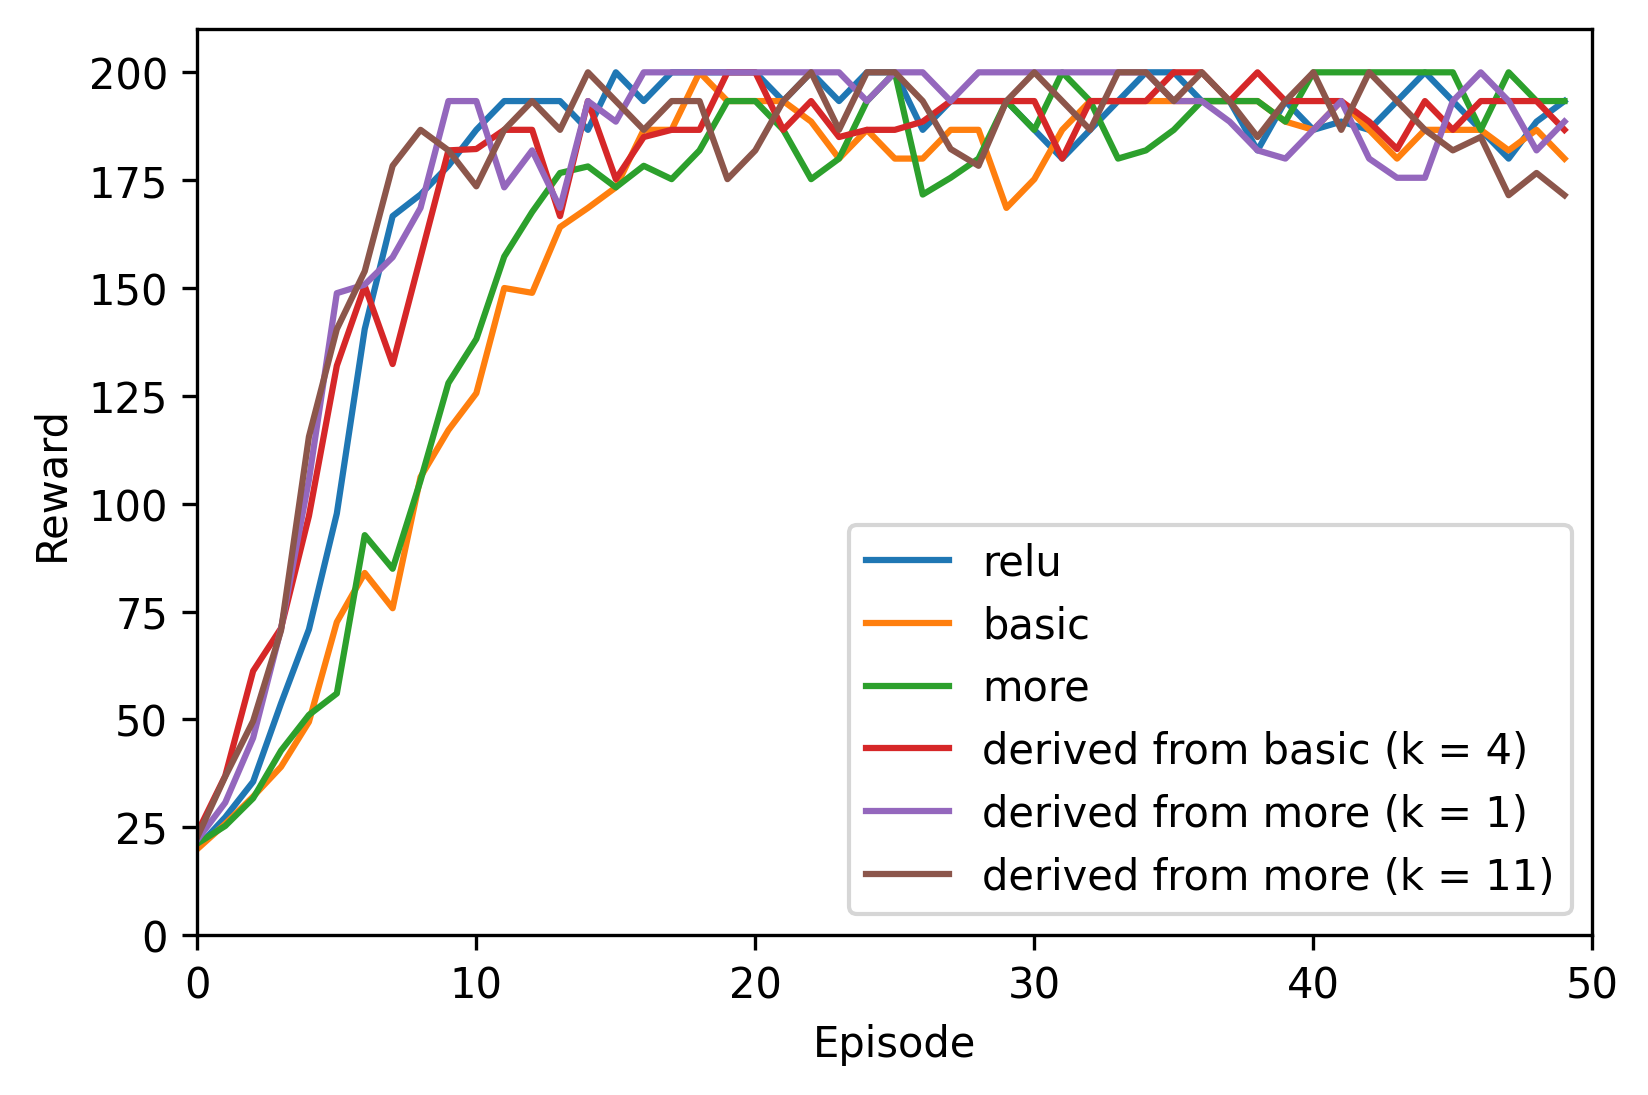

In [ ]:
plt.figure(dpi=300)
for model_name in ['relu', 'basic', 'normal', 'basic-3-fixed', 'normal-1-fixed', 'normal-1-fixed-all']:
  avgs = []
  returns = []
  histories = []
  for id in range(1, 6):
    history_path = f"{models_path}/ppo-{model_name}-{id}-CartPole-v0-history.pickle"
    history = load_history(history_path)
    mean_returns = [line['mean_return'] for line in history]
    returns += mean_returns
    histories.append(mean_returns)
  history_mean = np.mean(histories, axis=0)
  plot_ppo_history([{'mean_return': h} for h in history_mean], label={'normal': 'more', 'basic-3-fixed': 'derived from basic (k = 4)', 'normal-1-fixed': 'derived from more (k = 1)',  'normal-1-fixed-all': 'derived from more (k = 11)' }.get(model_name, model_name))
  mean_rewards_by_run = np.mean(histories, axis=1)
  mean_reward = np.mean(mean_rewards_by_run)
  std = np.std(mean_rewards_by_run)
  print(model_name, (mean_reward, std))
  print(f"{mean_reward:.1f}", '$\pm$', f"{std:.1f}")

In [1]:
returns_by_type = {}
for model_name in ['tanh', 'basic', 'normal', 'basic-1-fixed', 'normal-2-fixed', 'normal-2-fixed-all']:
  avgs = []
  returns = []
  histories = []
  for id in range(1, 6):
    history_path = f"{models_path}/dqn_CartPole-v0_{model_name}-{id}_history.pickle"
    history = load_history(history_path)
    returns.append(np.mean(history['episode_reward'][:300]))
  returns_by_type[model_name] = returns

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

print("DQN")
for model_name_1 in ['tanh']:
    for model_name_2 in ['tanh', 'basic', 'normal', 'basic-1-fixed', 'normal-2-fixed', 'normal-2-fixed-all']:
      x = returns_by_type[model_name_1]
      y = returns_by_type[model_name_2]
      #res = stats.ttest_ind(x, y, alternative='less')
      res = stats.permutation_test((x, y), statistic, n_resamples=np.inf, vectorized=True, alternative='less')
      dqn_less_than_baseline.append([model_name_1, model_name_2, round(res.pvalue, 3)])
      print(model_name_1, '<', model_name_2.ljust(20), f"{res.pvalue:.3f}")

print()
print(pd.DataFrame(dqn_less_than_baseline).to_latex(index=False))

DQN
tanh < tanh                 0.556
tanh < basic                0.976
tanh < normal               0.960
tanh < basic-1-fixed        0.504
tanh < normal-2-fixed       0.131
tanh < normal-2-fixed-all   0.730

egin{tabular}{llr}
	oprule
   0 &                  1 &     2 \
\midrule
tanh &               tanh & 0.556 \
tanh &              basic & 0.976 \
tanh &             normal & 0.960 \
tanh &      basic-1-fixed & 0.504 \
tanh &     normal-2-fixed & 0.131 \
tanh & normal-2-fixed-all & 0.730 \
ottomrule
\end{tabular}


In [ ]:
returns_by_type = {}
for model_name in ['relu', 'basic', 'normal', 'basic-3-fixed', 'normal-1-fixed', 'normal-1-fixed-all']:
  avgs = []
  returns = []
  histories = []
  for id in range(1, 6):
    history_path = f"{models_path}/ppo-{model_name}-{id}-CartPole-v0-history.pickle"
    history = load_history(history_path)
    returns.append(np.mean([line['mean_return'] for line in history]))
  returns_by_type[model_name] = returns

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

ppo_less_than_baseline = list()
print("\n\n\nPPO")
for model_name_1 in ['relu']:
    for model_name_2 in ['relu', 'basic', 'normal', 'basic-3-fixed', 'normal-1-fixed', 'normal-1-fixed-all']:
      x = returns_by_type[model_name_1]
      y = returns_by_type[model_name_2]
      #res = stats.ttest_ind(x, y, alternative='less')
      res = stats.permutation_test((x, y), statistic, n_resamples=np.inf, vectorized=True, alternative='less')
      ppo_less_than_baseline.append([model_name_1, model_name_2, round(res.pvalue, 3)])
      print(model_name_1, '<', model_name_2.ljust(20), f"{res.pvalue:.3f}")

print()
print(pd.DataFrame(ppo_less_than_baseline).to_latex(index=False))

PPO
relu < relu                 0.563
relu < basic                0.992
relu < normal               0.972
relu < basic-3-fixed        0.524
relu < normal-1-fixed       0.214
relu < normal-1-fixed-all   0.317

egin{tabular}{llr}
	oprule
   0 &                  1 &     2 \
\midrule
relu &               relu & 0.563 \
relu &              basic & 0.992 \
relu &             normal & 0.972 \
relu &      basic-3-fixed & 0.524 \
relu &     normal-1-fixed & 0.214 \
relu & normal-1-fixed-all & 0.317 \
ottomrule
\end{tabular}


tanh (135.7326666666667, 6.451301815223894)
135.7 $\pm$ 6.5
basic (121.88400000000001, 10.799092842559611)
121.9 $\pm$ 10.8
normal (124.45466666666667, 9.924229071654215)
124.5 $\pm$ 9.9
basic-1-fixed (135.72266666666664, 8.840865819841655)
135.7 $\pm$ 8.8
normal-2-fixed (145.34066666666666, 15.515158093511857)
145.3 $\pm$ 15.5
normal-2-fixed-all (131.808, 9.643296946584192)
131.8 $\pm$ 9.6


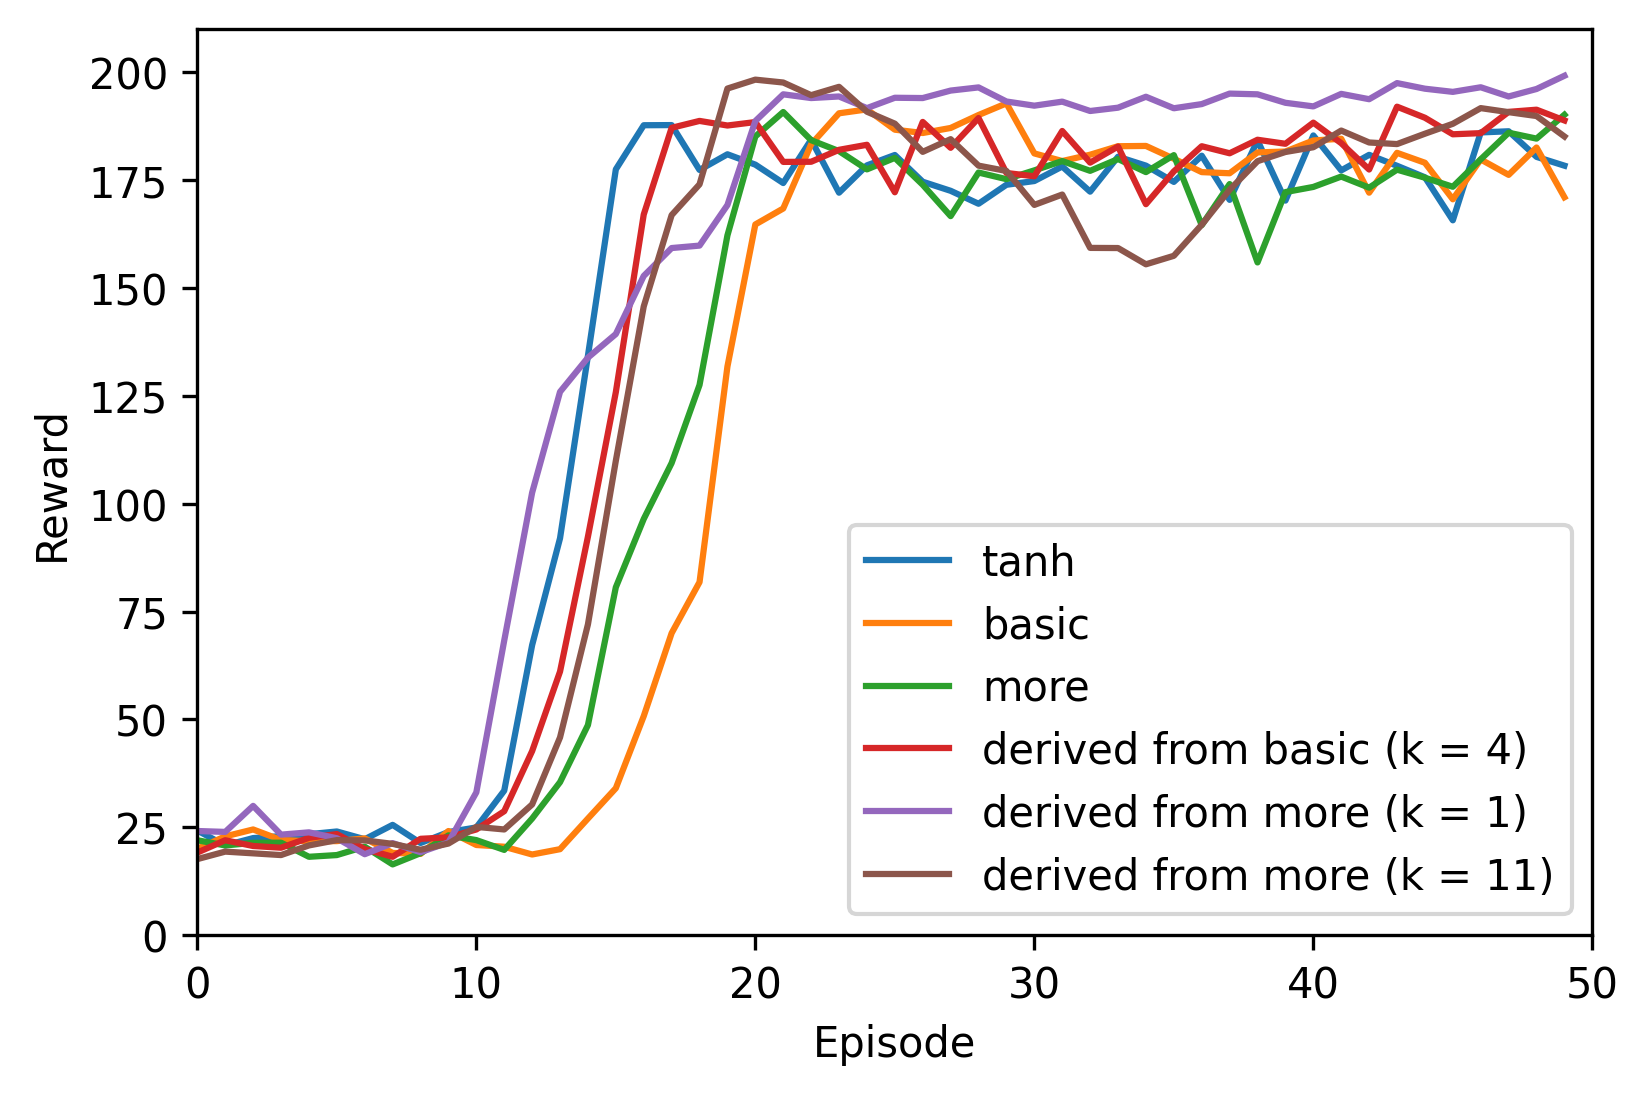

In [ ]:
plt.figure(dpi=300)
for model_name in ['tanh', 'basic', 'normal', 'basic-1-fixed', 'normal-2-fixed', 'normal-2-fixed-all']:
  avgs = []
  returns = []
  histories = []
  mean_returns = []
  for id in range(1, 6):
    history_path = f"{models_path}/dqn_CartPole-v0_{model_name}-{id}_history.pickle"
    history = load_history(history_path)
    histories.append(history['episode_reward'][:300])
    returns += history['episode_reward'][:300]
    mean_returns.append(np.mean(history['episode_reward'][:300]))
  history_mean = np.mean(histories, axis=0)
  plot_dqn_history({'episode_reward': history_mean}, label={"normal": "more", "basic-1-fixed": "derived from basic (k = 4)", "normal-2-fixed": "derived from more (k = 1)", "normal-2-fixed-all": "derived from more (k = 11)"}.get(model_name, model_name))
  mean_reward = np.mean(mean_returns)
  std = np.std(mean_returns)
  print(model_name, (mean_reward, std))
  print(f"{mean_reward:.1f}", '$\pm$', f"{std:.1f}")

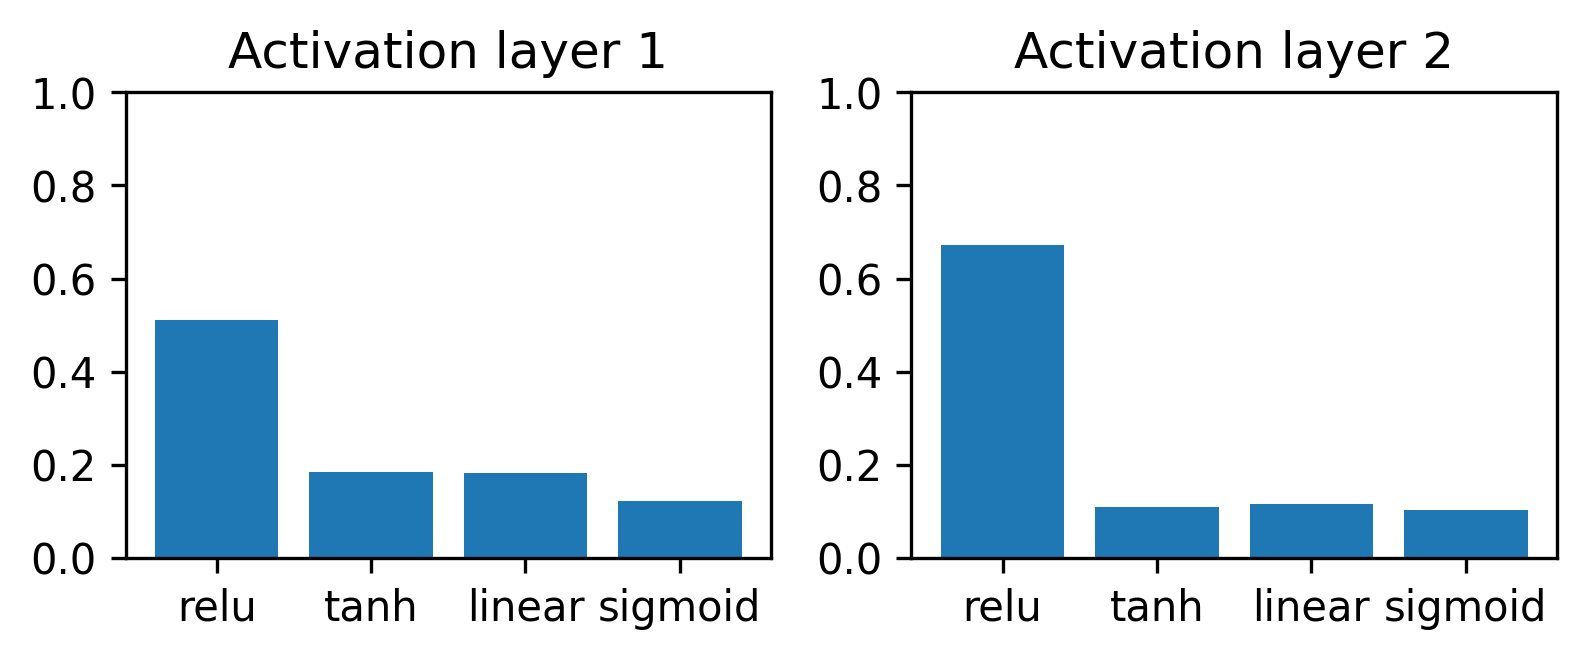

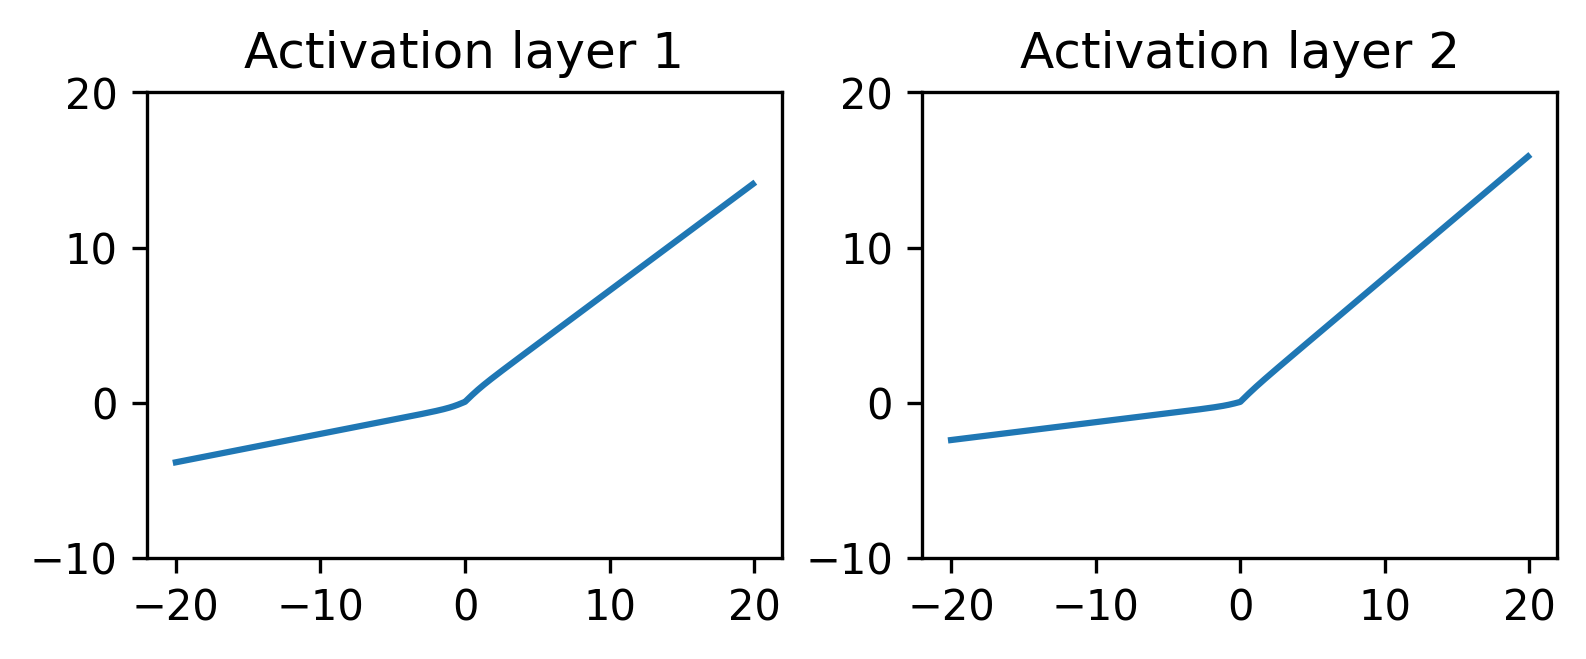

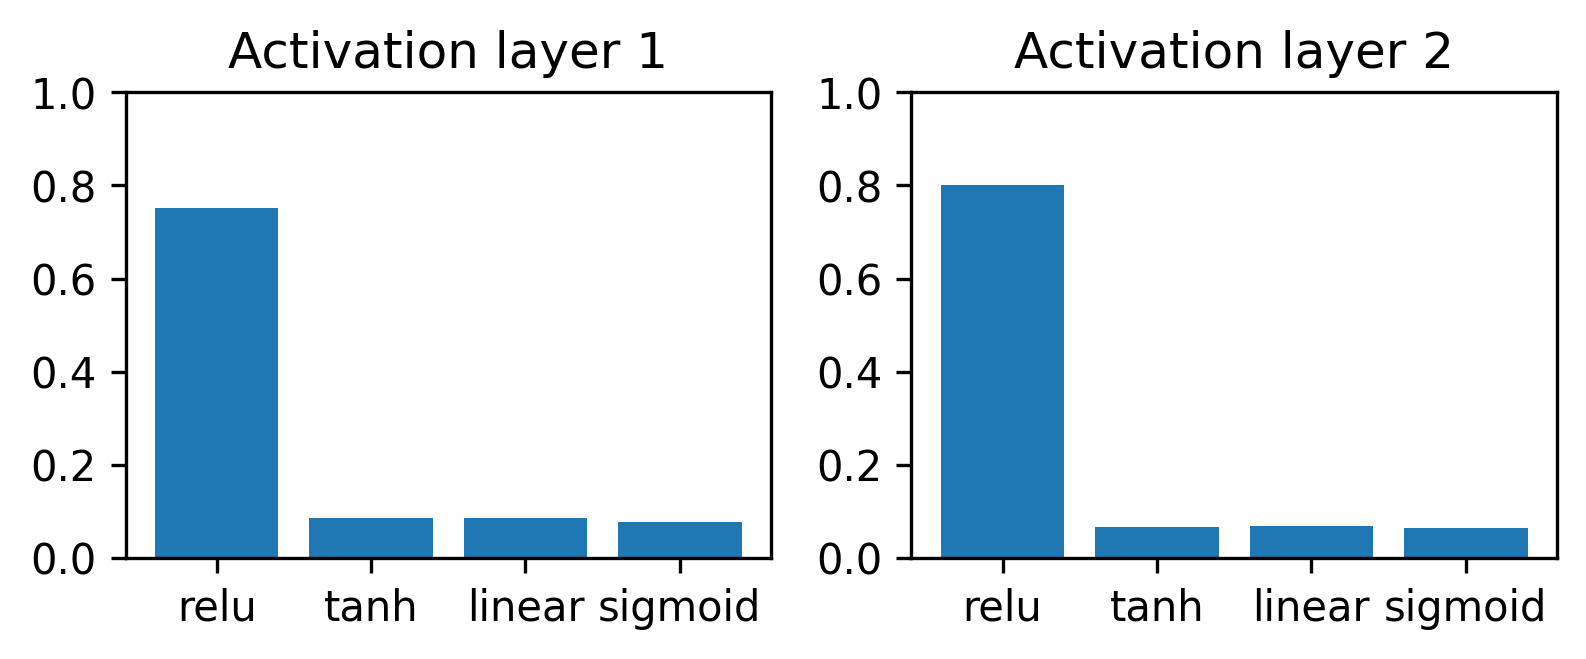

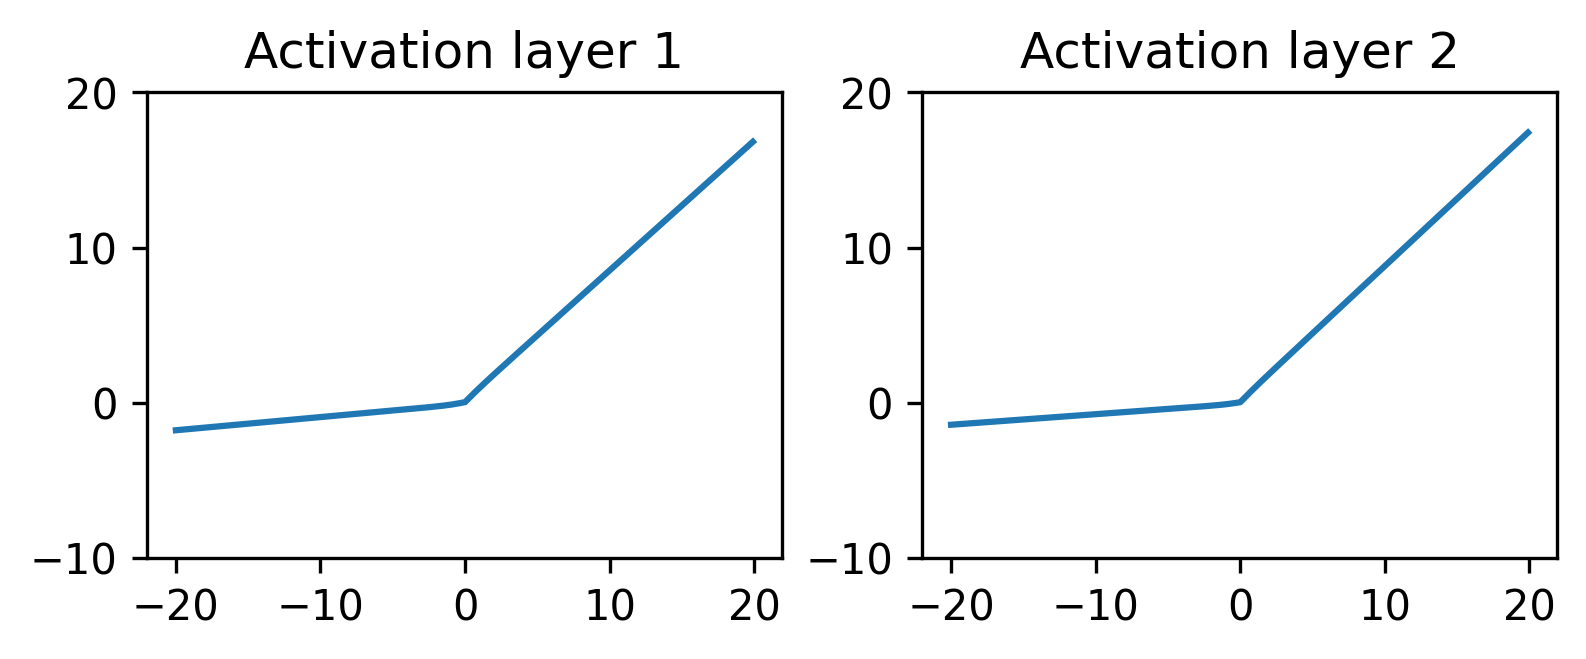

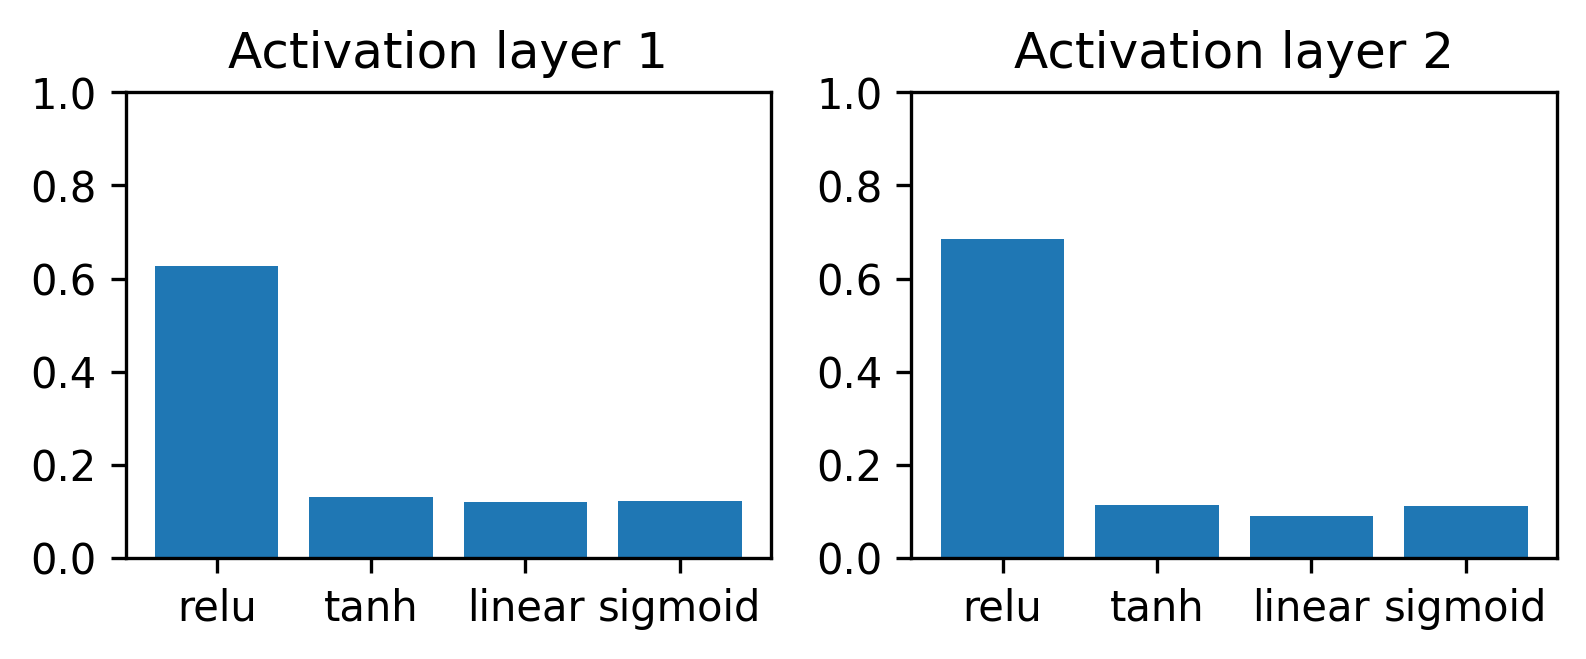

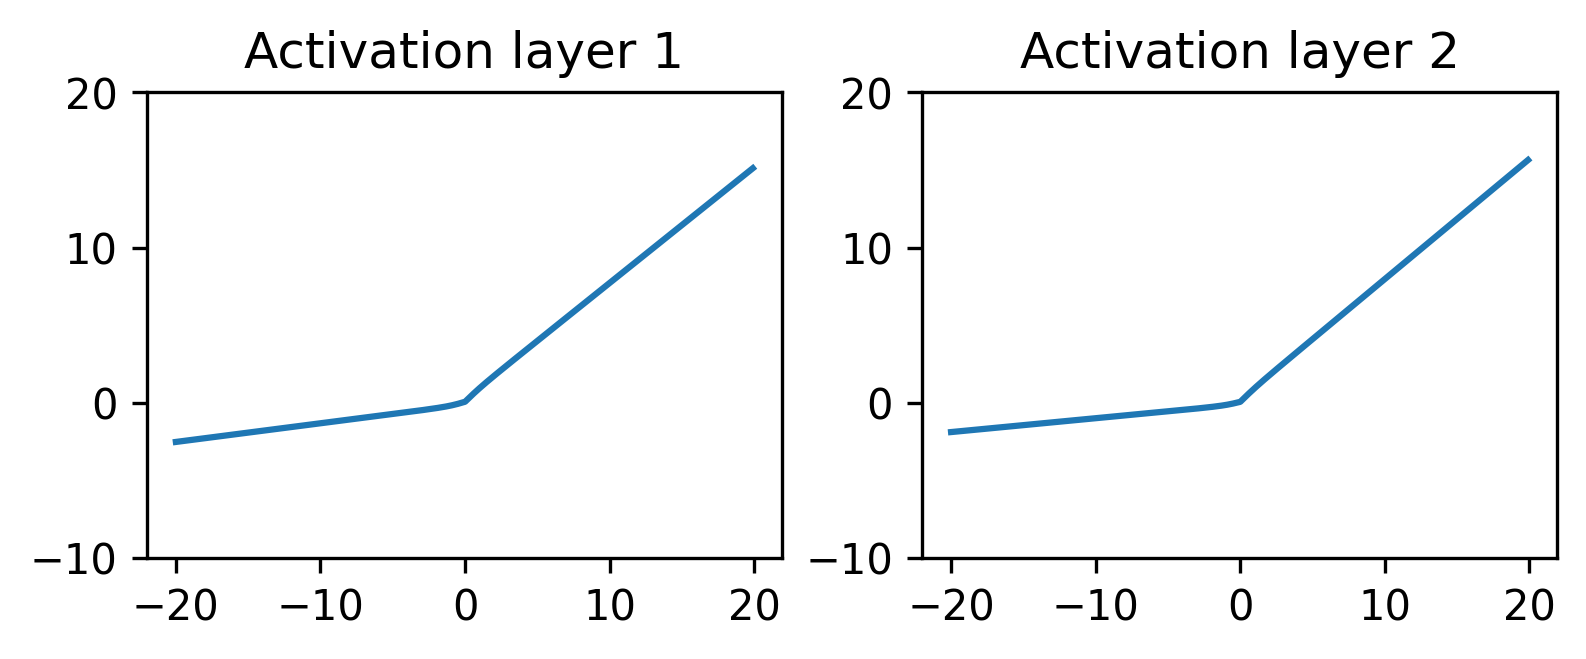

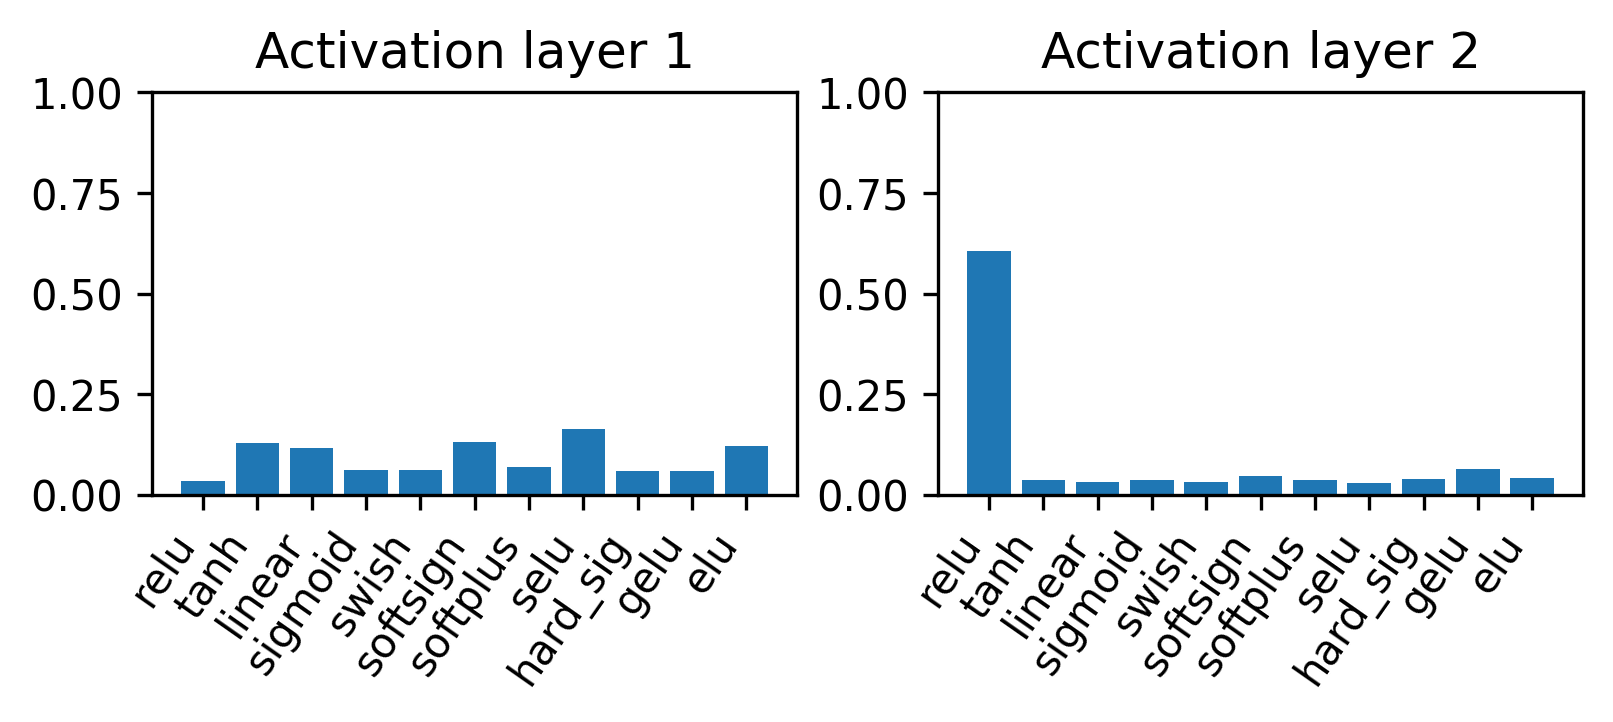

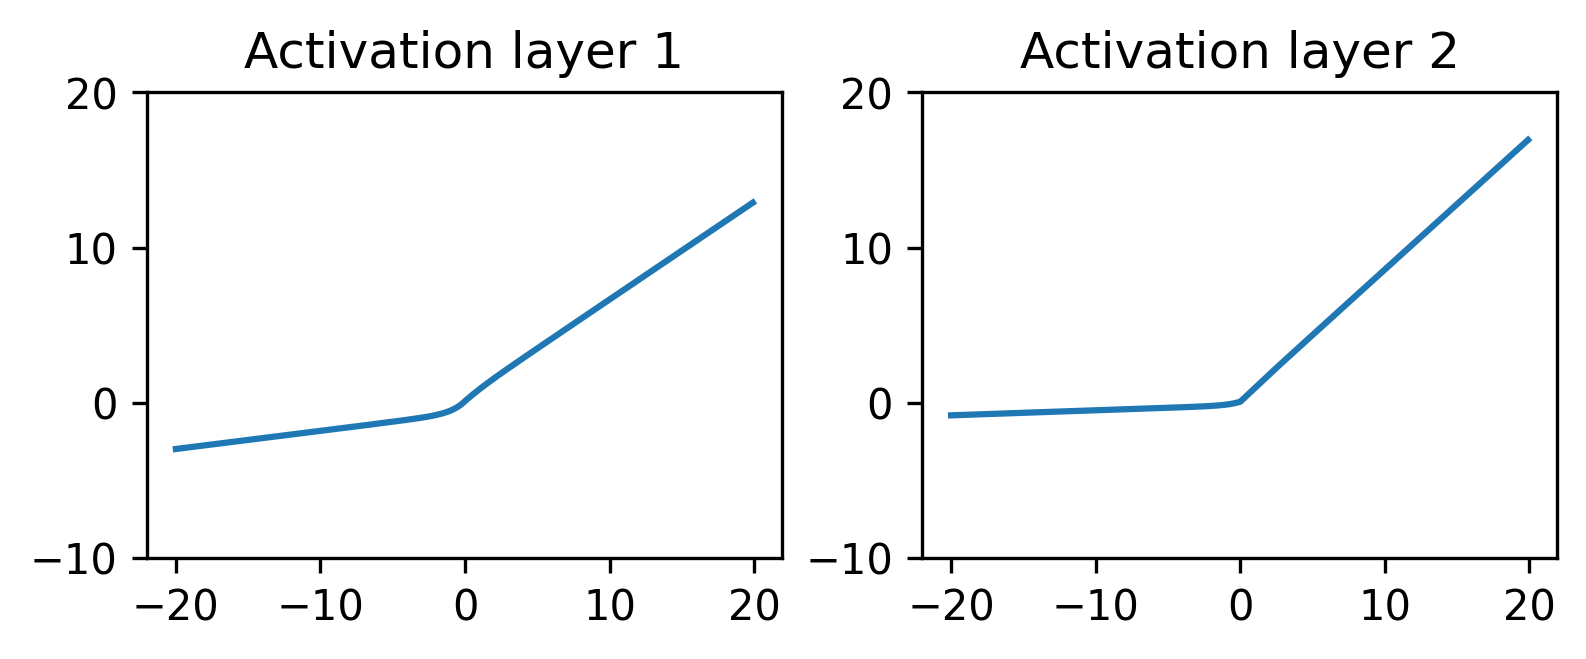

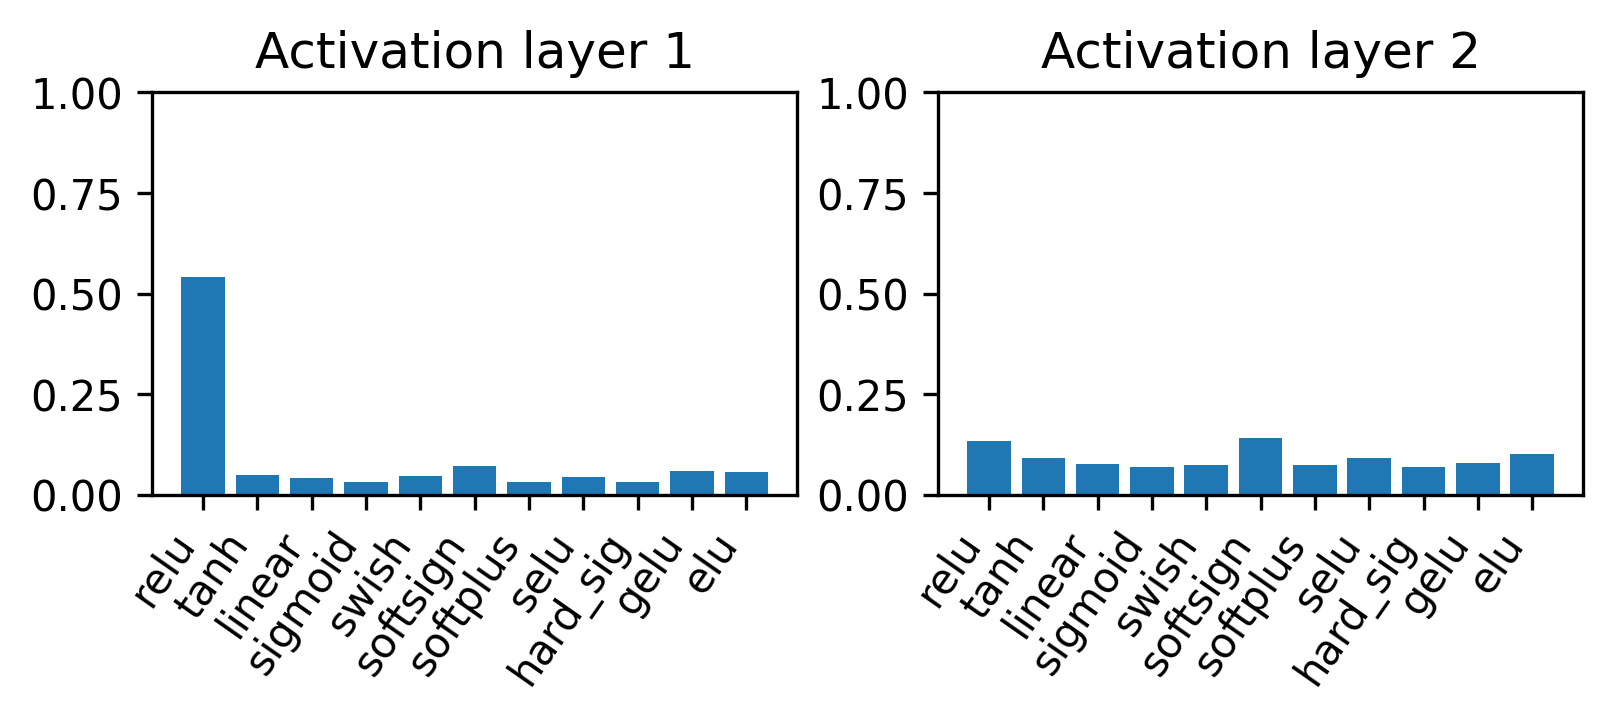

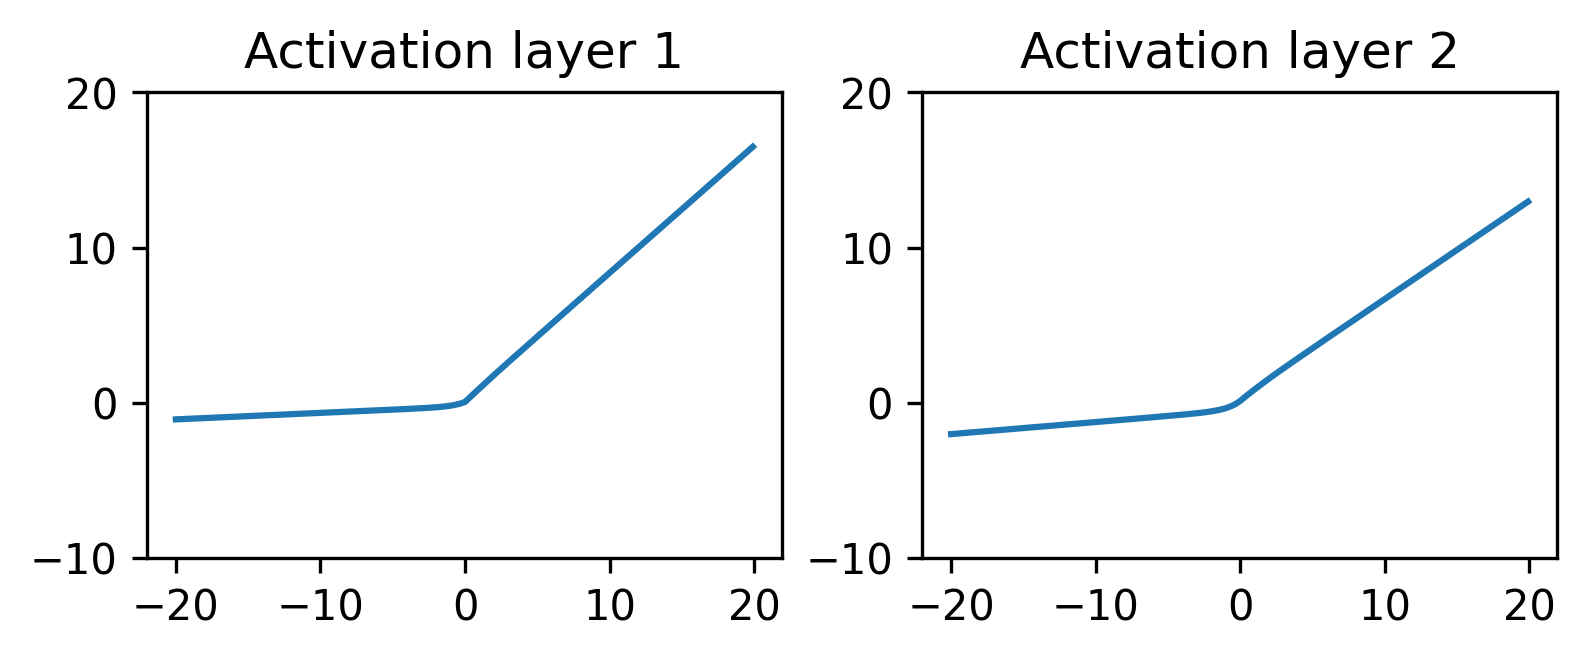

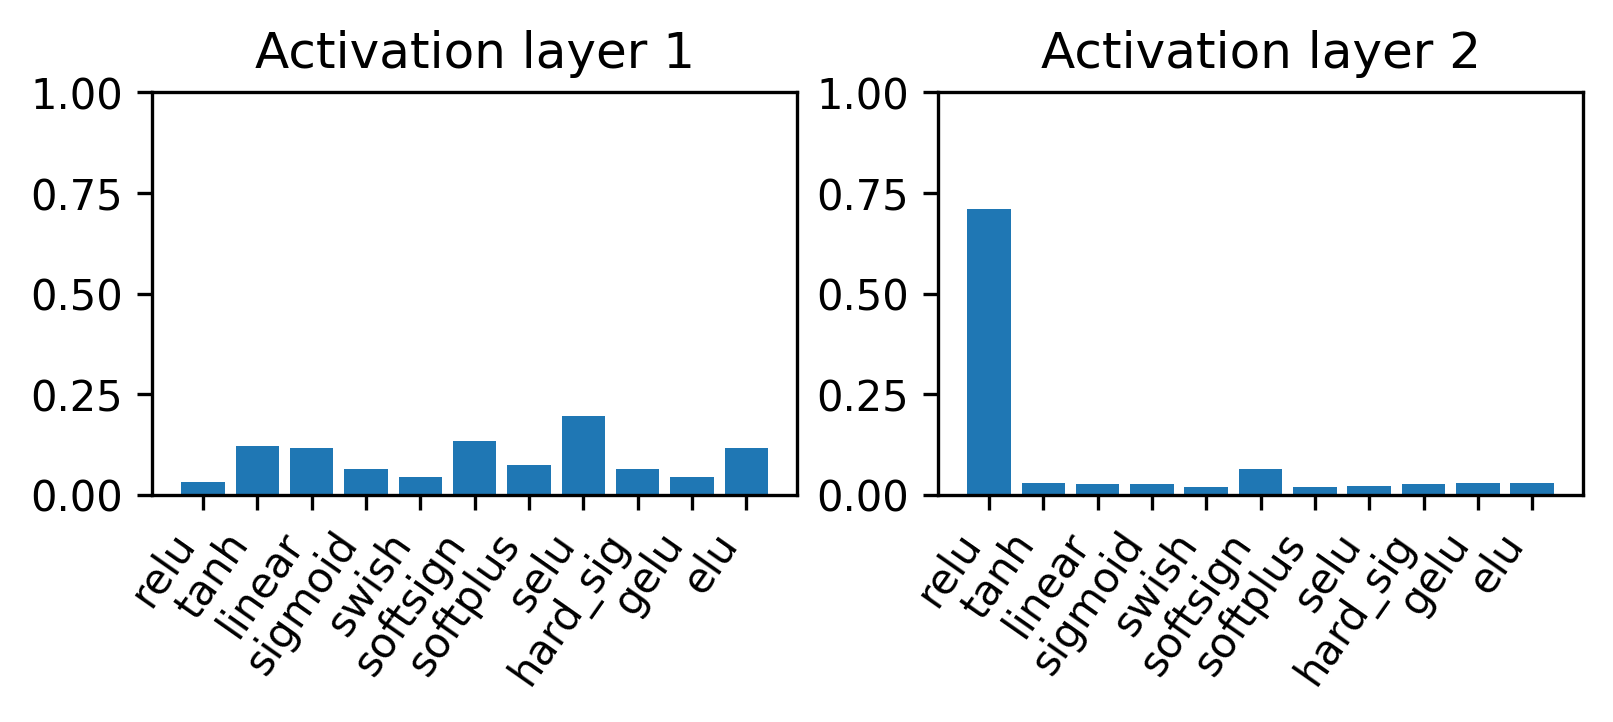

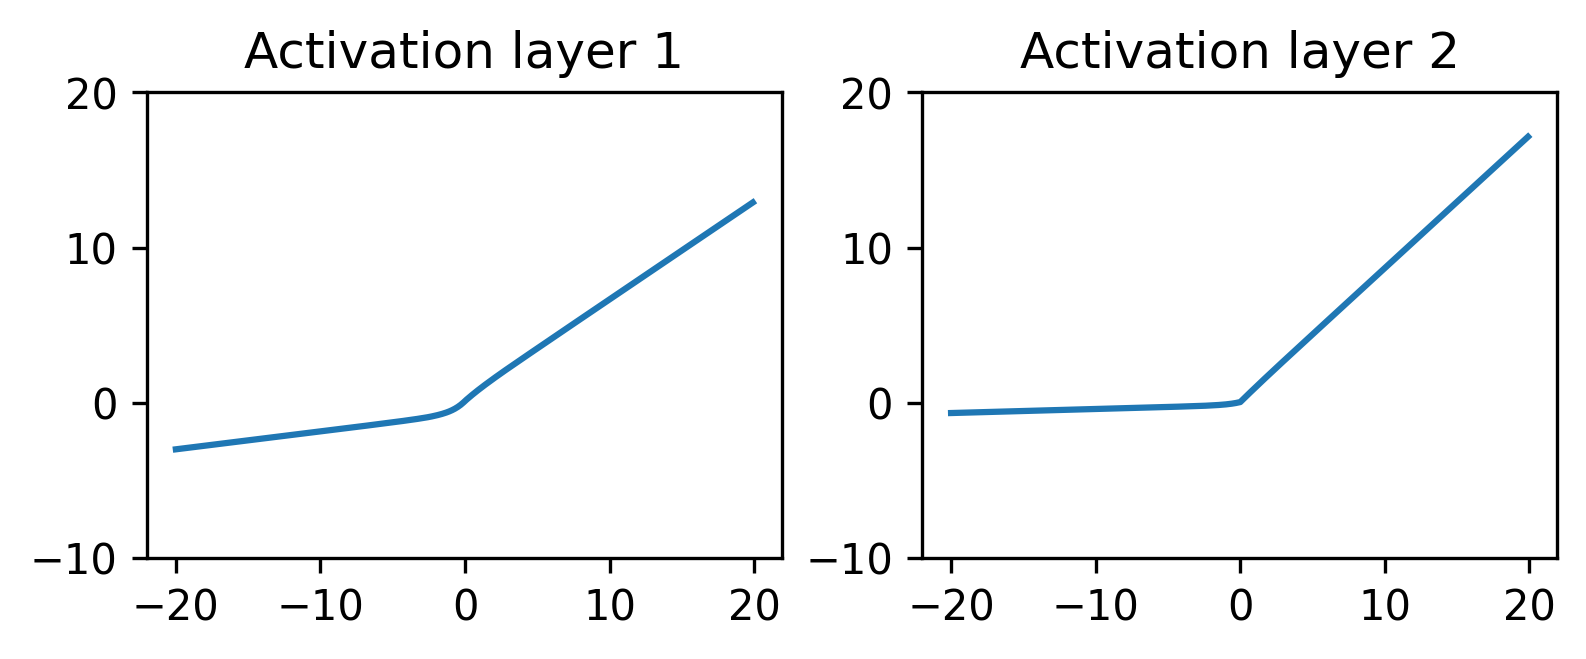

In [ ]:
for model_name in ['basic', 'normal']:
  for id in range(1, 4):
    model_path = f"{models_path}/ppo-{model_name}-{id}-CartPole-v0-actor.hdf5"
    history_path = f"{models_path}/ppo-{model_name}-{id}-CartPole-v0-history.pickle"
    model = load_model(model_path)
    plot_activation_functions_bars([model], width=5.5, height=2, mode='grid', n=2, m=2)
    plot_activation_functions([model], width=5.5, height=2, mode='grid')

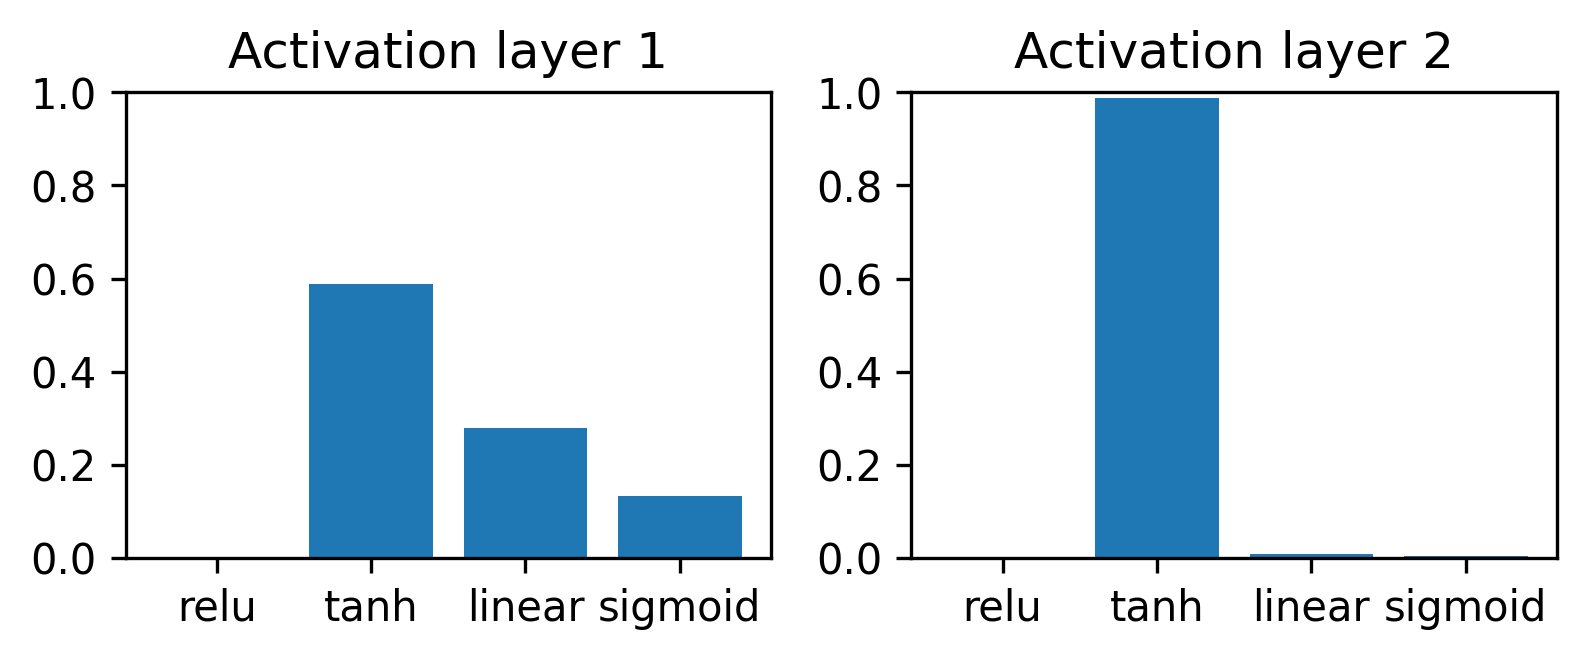

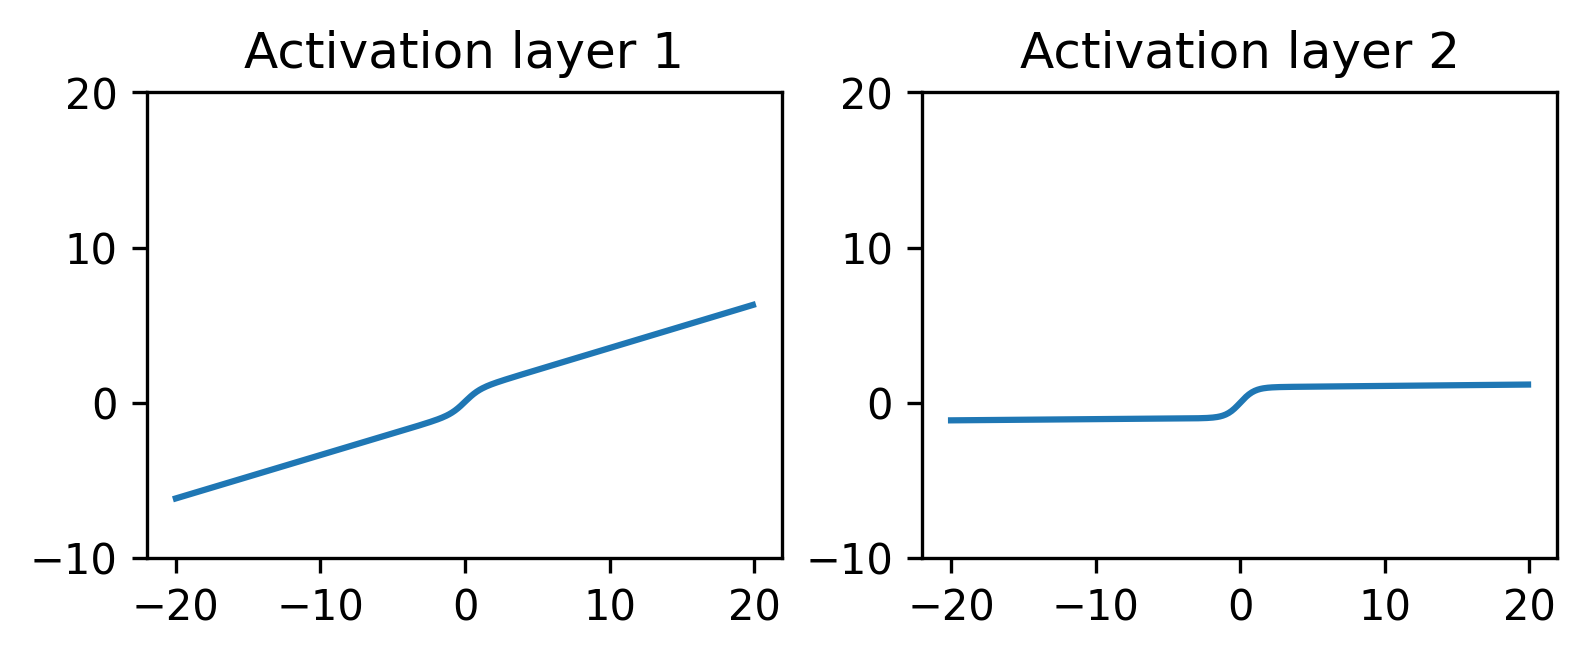

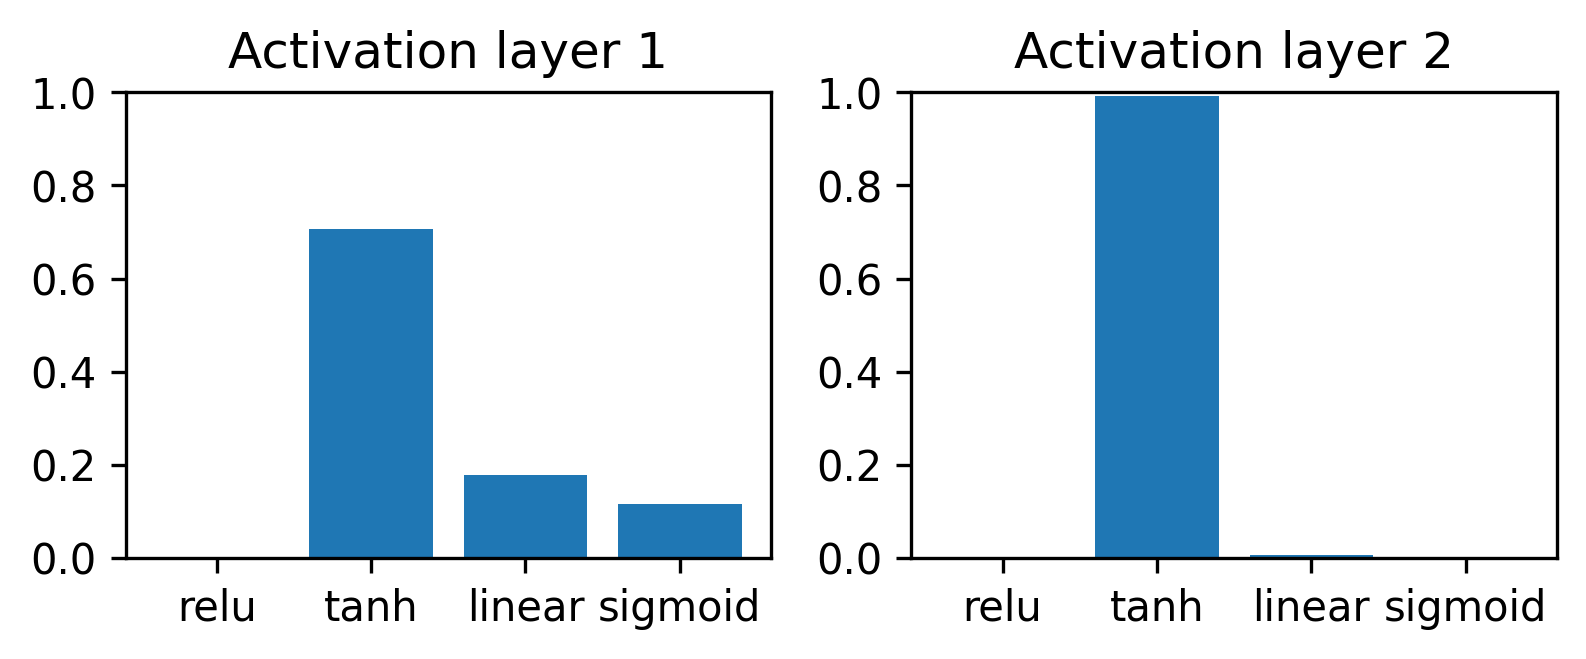

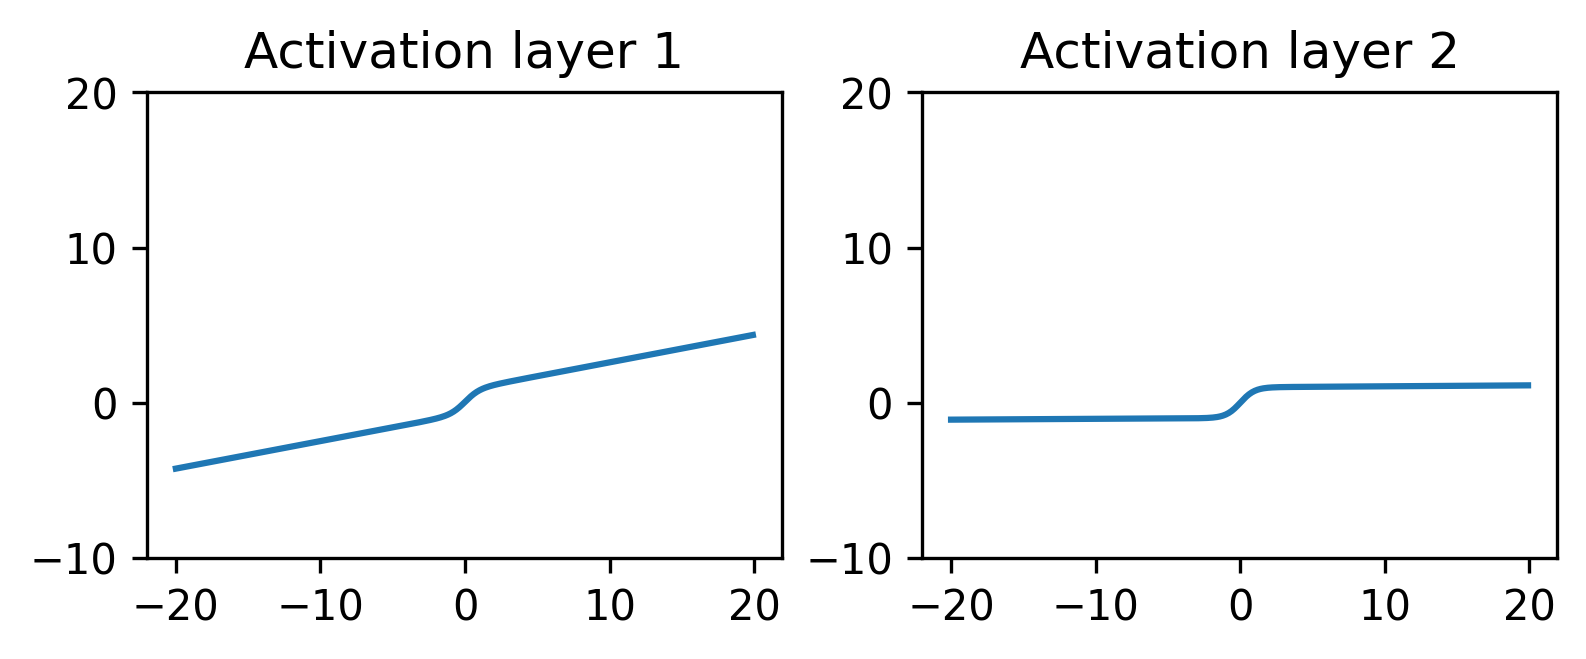

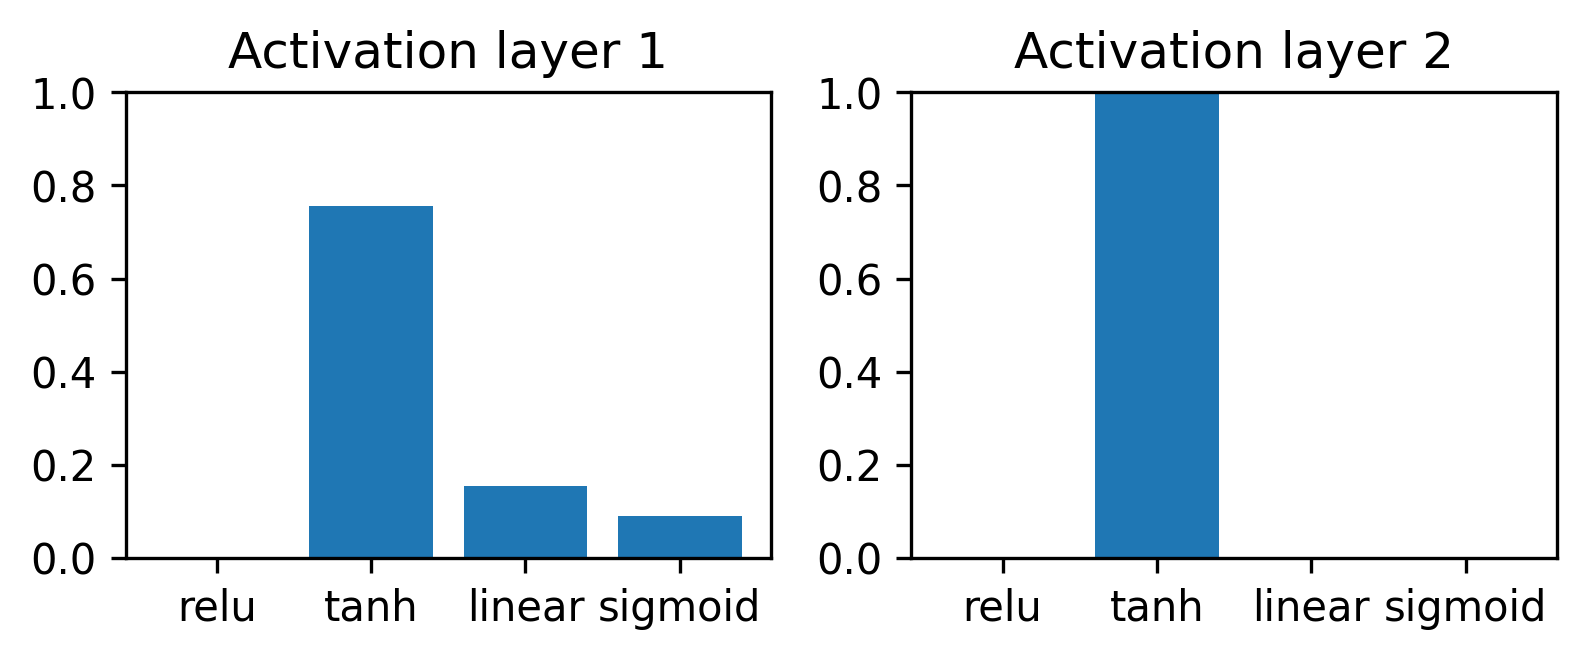

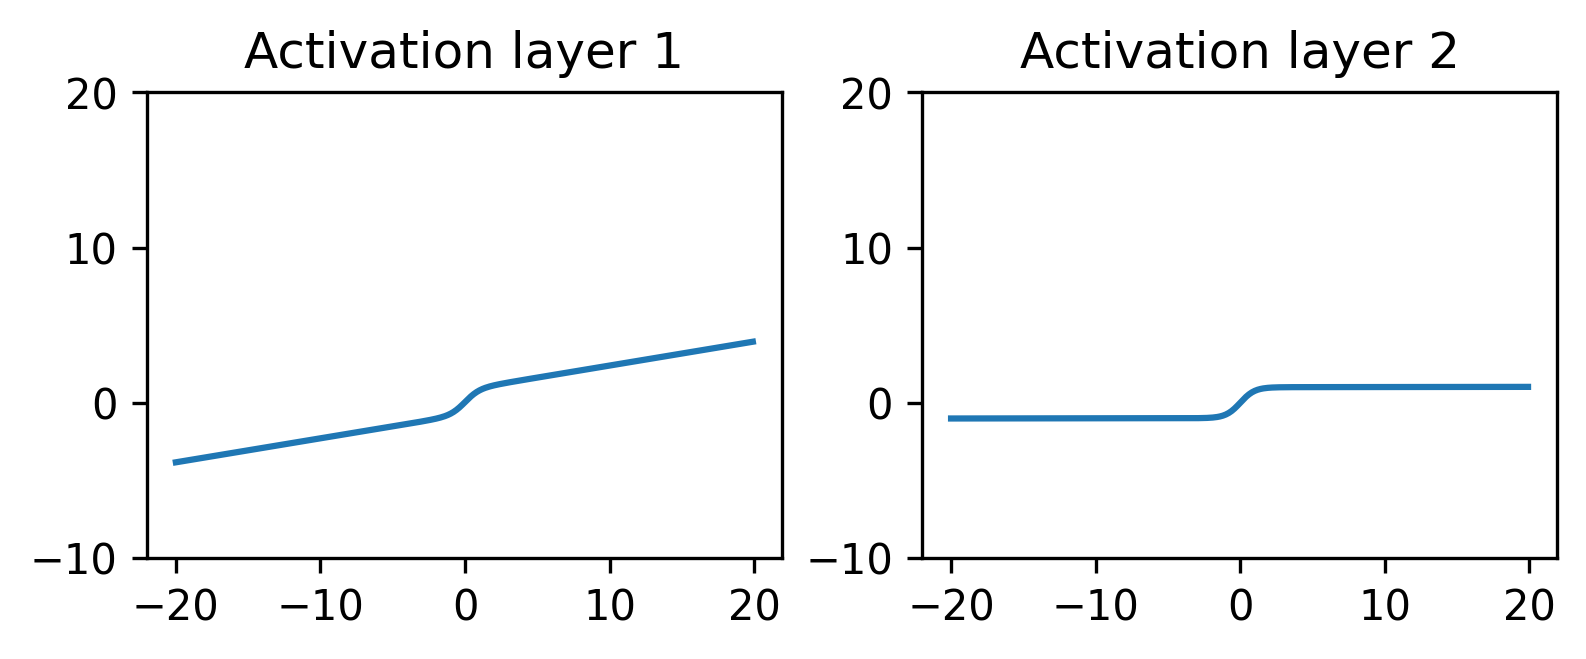

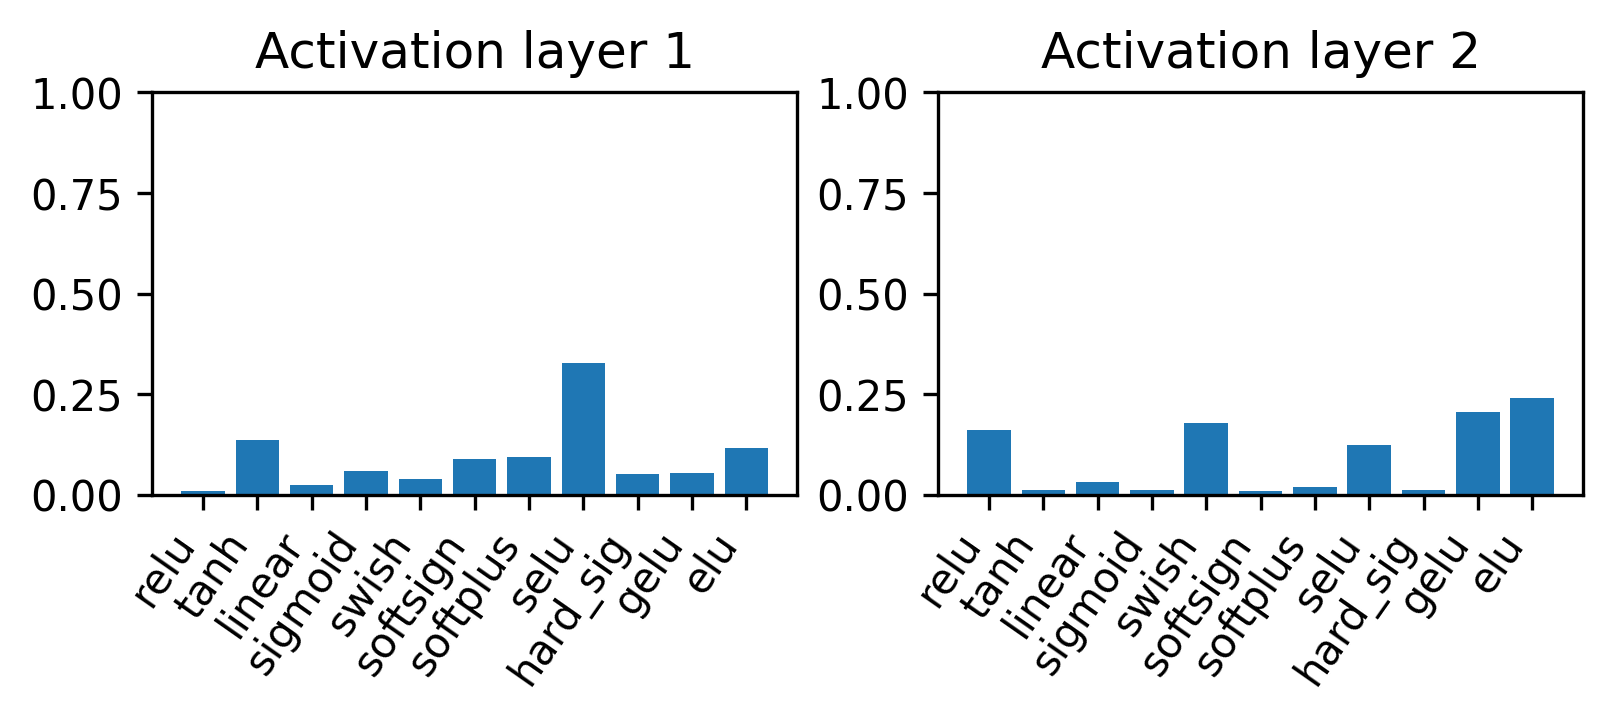

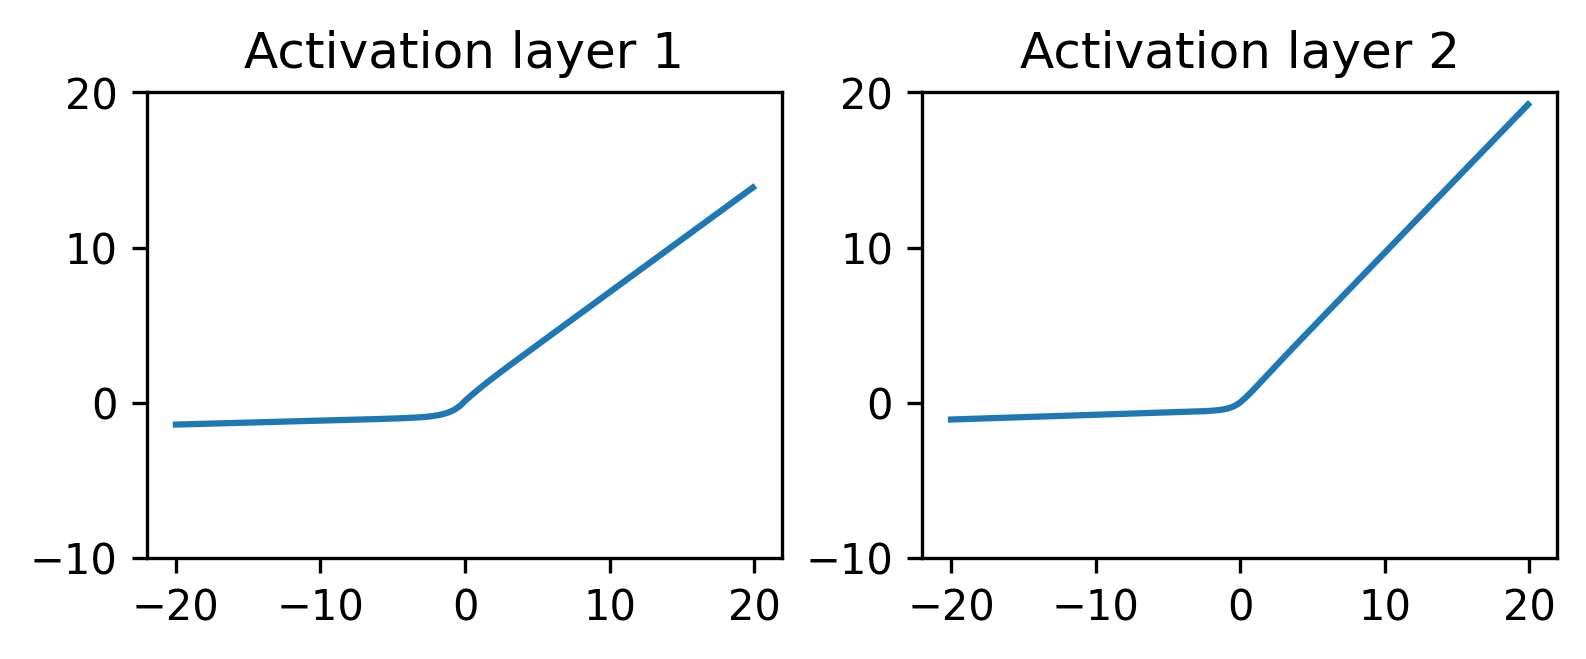

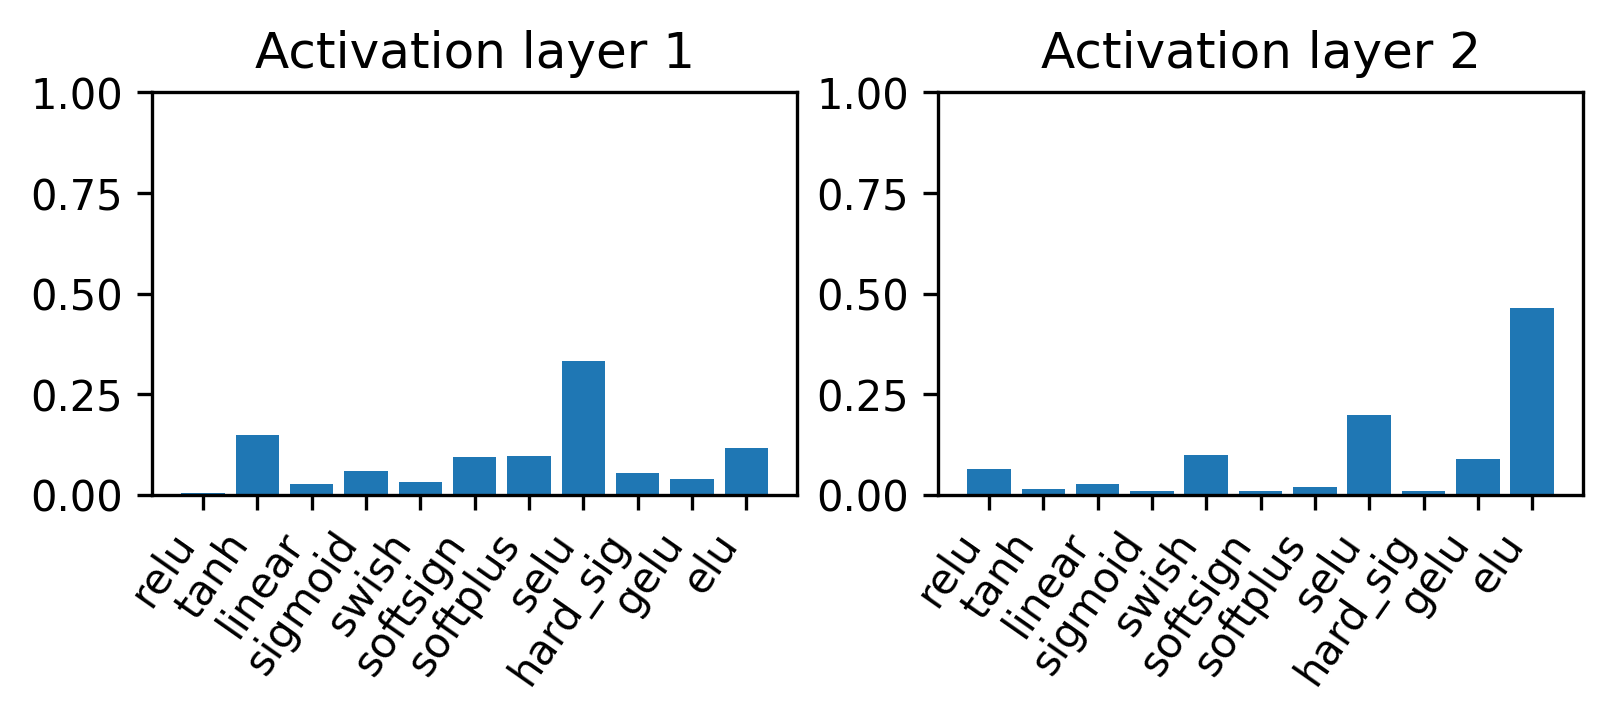

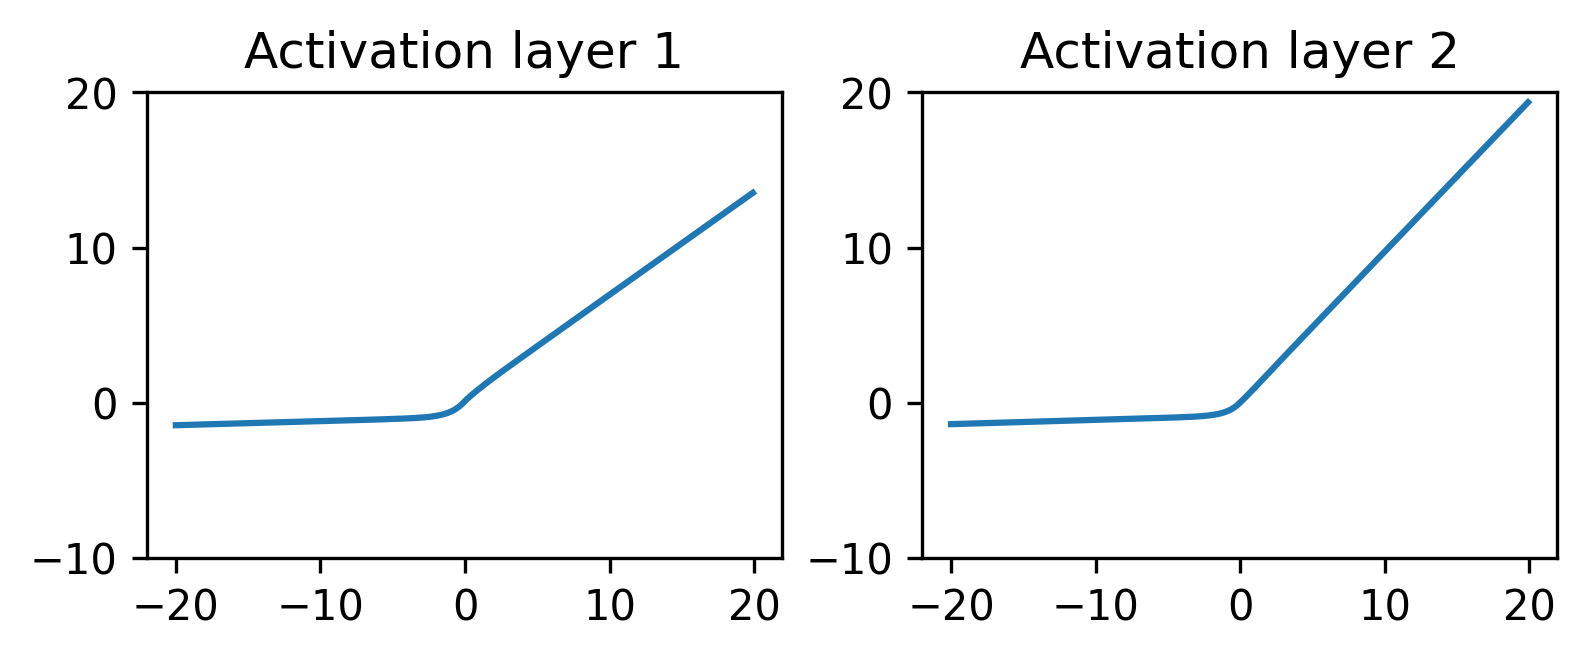

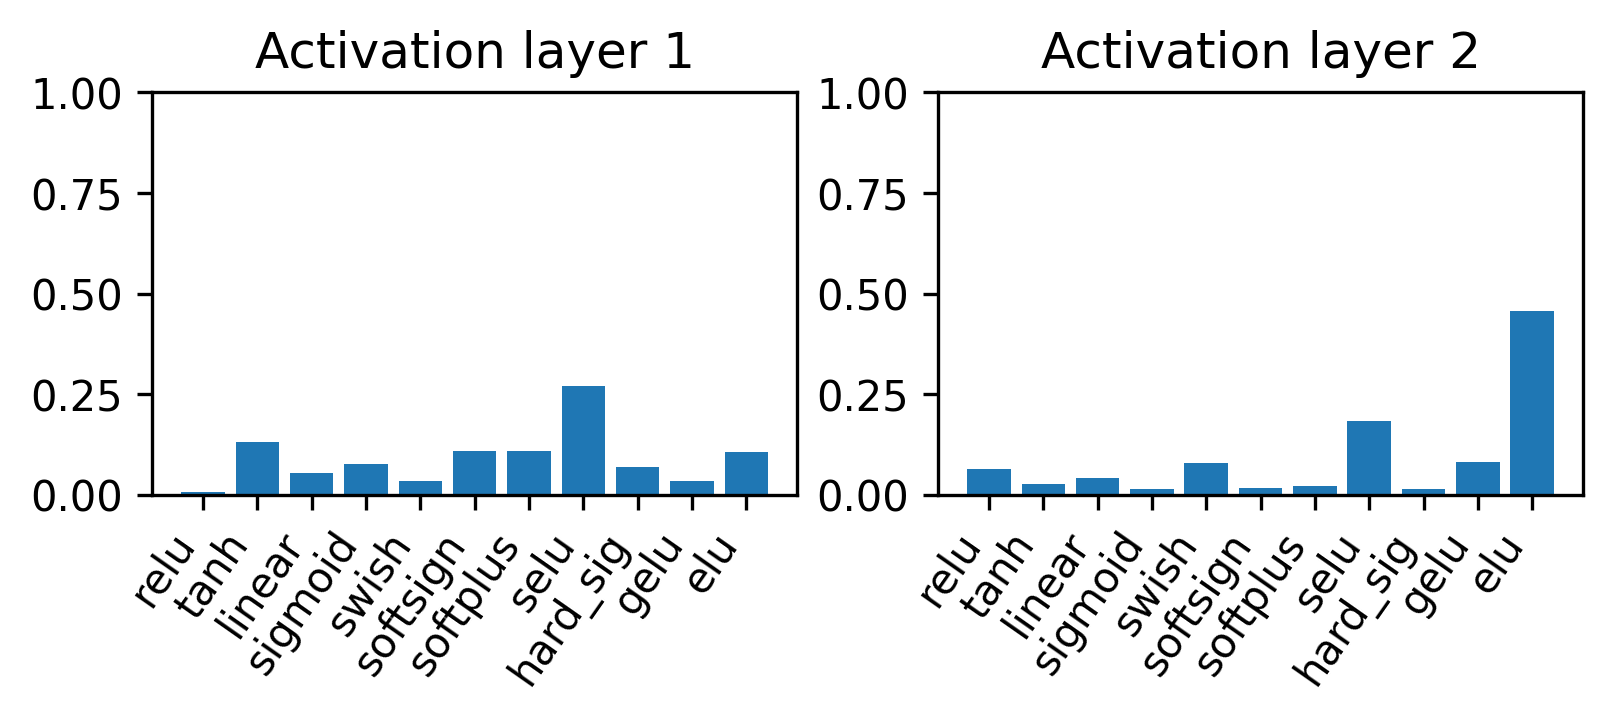

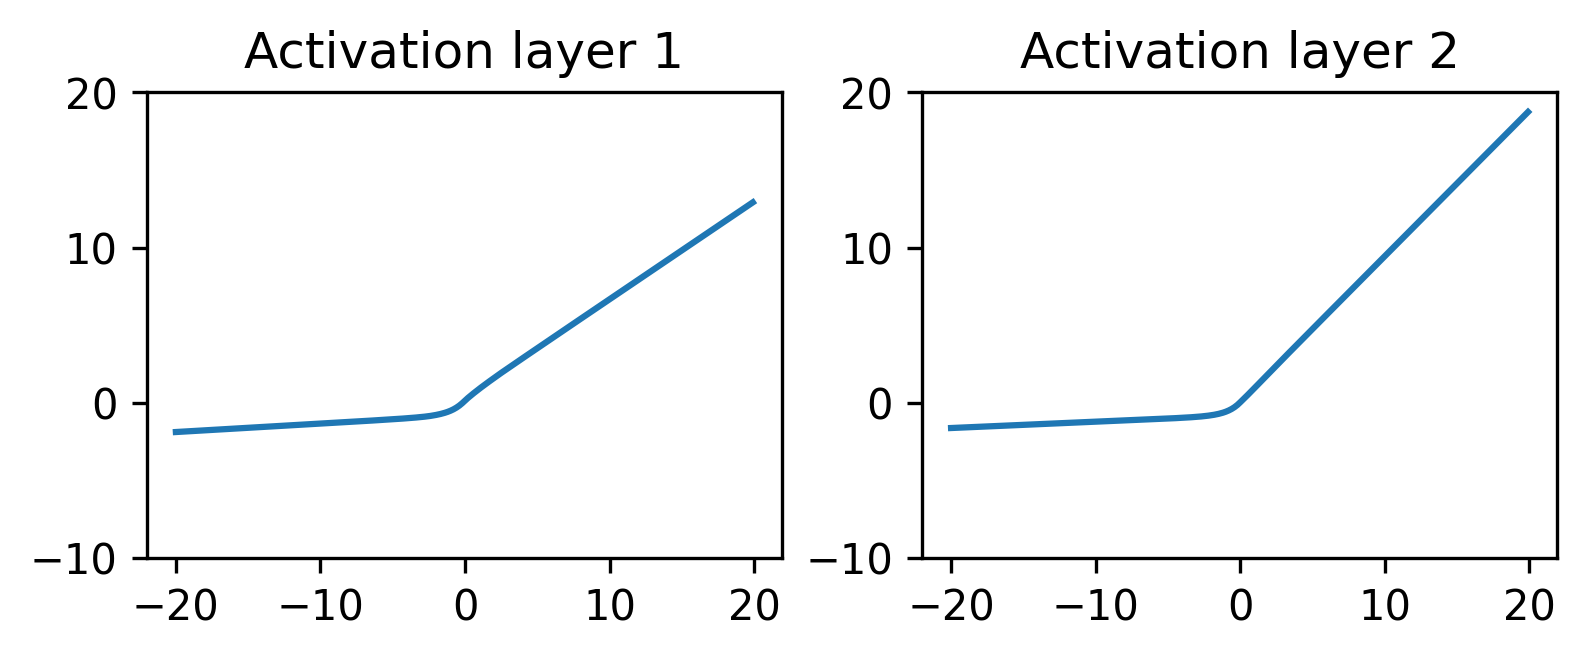

In [ ]:
for model_name in ['basic', 'normal']:
  for id in range(1, 4):
    model_path = f"{models_path}/dqn_CartPole-v0_{model_name}-{id}.h5f"
    model = load_model(model_path)
    plot_activation_functions_bars([model], width=5.5, height=2, mode='grid', n=2, m=2)
    plot_activation_functions([model], width=5.5, height=2, mode='grid')